In [ ]:
import os
import json
import collections
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

In [ ]:
!git clone https://gitlab.com/arabic-nlp/propaganda-detection.git
%cd propaganda-detection


Cloning into 'propaganda-detection'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 154 (delta 89), reused 5 (delta 3), pack-reused 0
Receiving objects: 100% (154/154), 245.60 KiB | 4.09 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/propaganda-detection


In [ ]:
import sys
import pandas as pd
import json
import random
import argparse
import warnings
import matplotlib.pyplot as plt
import torch
import time
import datetime
import numpy as np
import seaborn as sns

random.seed(42) # to make runs deterministic




In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
import re
import string
import sys
import argparse

arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)


def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text


def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text


def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

def clean_text(text):
    text = remove_punctuations(text)
    text = remove_diacritics(text)
    text = remove_repeating_char(text)
    return text

In [ ]:
!mkdir output
dev_file = 'data/task1_dev.json'
test_file = 'data/task1_test_gold_label_final.json'
train_file = 'data/task1_train.json'

task_output_file= 'output/baseline-output-task1.json'

propaganda_techniques_file = "techniques_list_task1-2.txt"


In [ ]:
def get_labels(propaganda_techniques_names,techniques_names):
    labels = []
    for name in propaganda_techniques_names:
        if name in techniques_names:
           labels.append(1)
        else:
           labels.append(0)
    return labels
    

In [ ]:
def load_df(jsonobj,get_label):
    df = []
    for example in jsonobj:
        techniques_list = []
        tmp_propaganda_techniques_names = propaganda_techniques_names[:]
        if get_label:
            row = get_labels(propaganda_techniques_names,example['labels'])
            row.insert(0, example['text'])
            row.insert(0, example['id'])
        else:
            row = [example['id'],example['text']]
        df.append(row)

    if get_label:
        df = pd.DataFrame(df, columns=['id','text']+propaganda_techniques_names)
        df['text'] = df['text'].apply(lambda x: clean_text(x))
    else:
        df = pd.DataFrame(df, columns=['id','text'])
        df['text'] = df['text'].apply(lambda x: clean_text(x))
        
    return df

try:
    with open(dev_file, "r") as f:
        devjsonobj = json.load(f)
    with open(test_file, "r") as f:
        testjsonobj = json.load(f)
    with open(train_file, "r") as f:
        trainjsonobj = json.load(f)
except:
    sys.exit("ERROR: cannot load json file")

with open(propaganda_techniques_file, "r") as f:
    propaganda_techniques_names = [ line.rstrip() for line in f.readlines() if len(line)>2 ]

propaganda_techniques_names = propaganda_techniques_names[:-2]
dev_df = load_df(devjsonobj,True)
test_df =load_df(testjsonobj,True)
train_df =load_df(trainjsonobj,True)
train_dev_df = pd.concat([train_df, dev_df], ignore_index=True)
train_dev_test_df = pd.concat([train_dev_df, test_df], ignore_index=True)


In [ ]:
train_df.shape,dev_df.shape,test_df.shape

((504, 21), (52, 21), (323, 21))

In [ ]:
train_df = train_dev_df

In [ ]:
train_df.shape

(556, 21)

In [ ]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning


  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-timr5jgp
  Running command git clone --filter=blob:none --quiet https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-timr5jgp
  Resolved https://github.com/PyTorchLightning/pytorch-lightning to commit be7bfdba27363f2edc3561e461b9cc2ee7cc15fb
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 264.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 785.2 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 9.6 MB/s eta 0:00:00:00:010:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from torchmetrics.functional import accuracy,auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
pl.seed_everything(RANDOM_SEED)

42

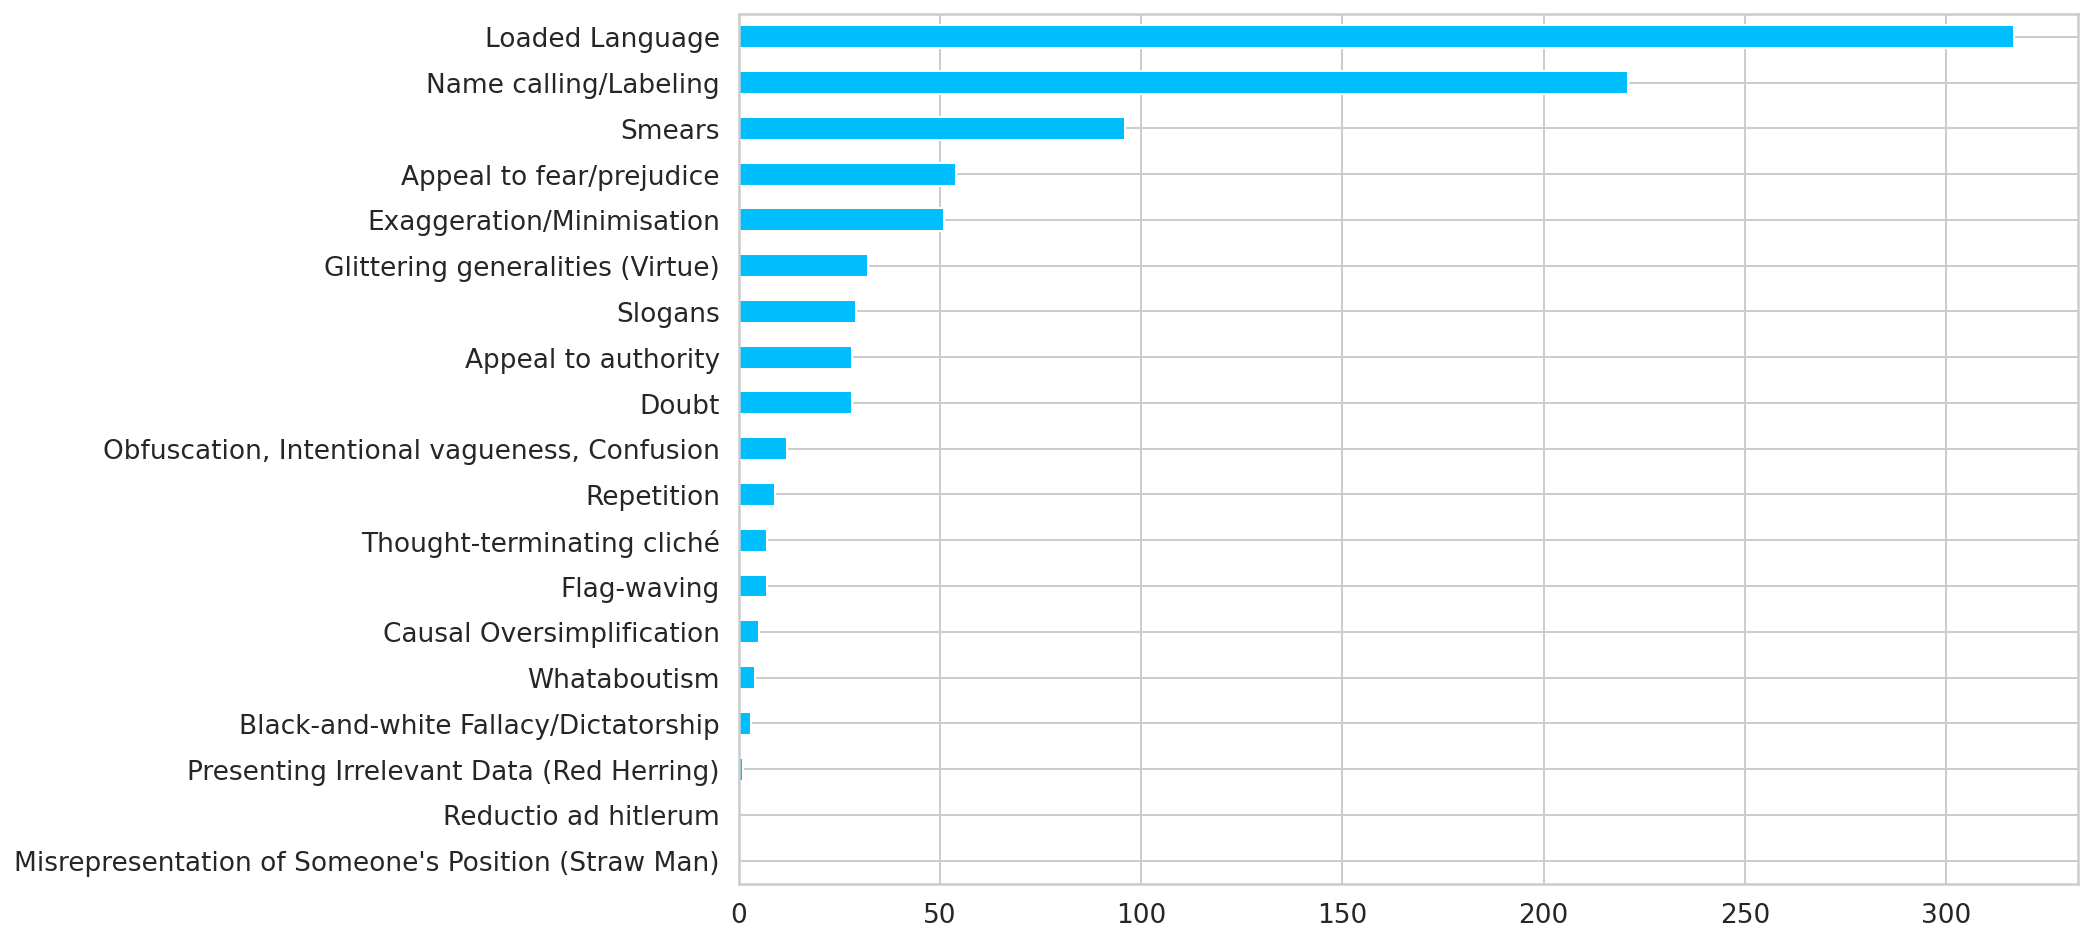

In [ ]:
train_df[propaganda_techniques_names].sum().sort_values().plot(kind="barh");


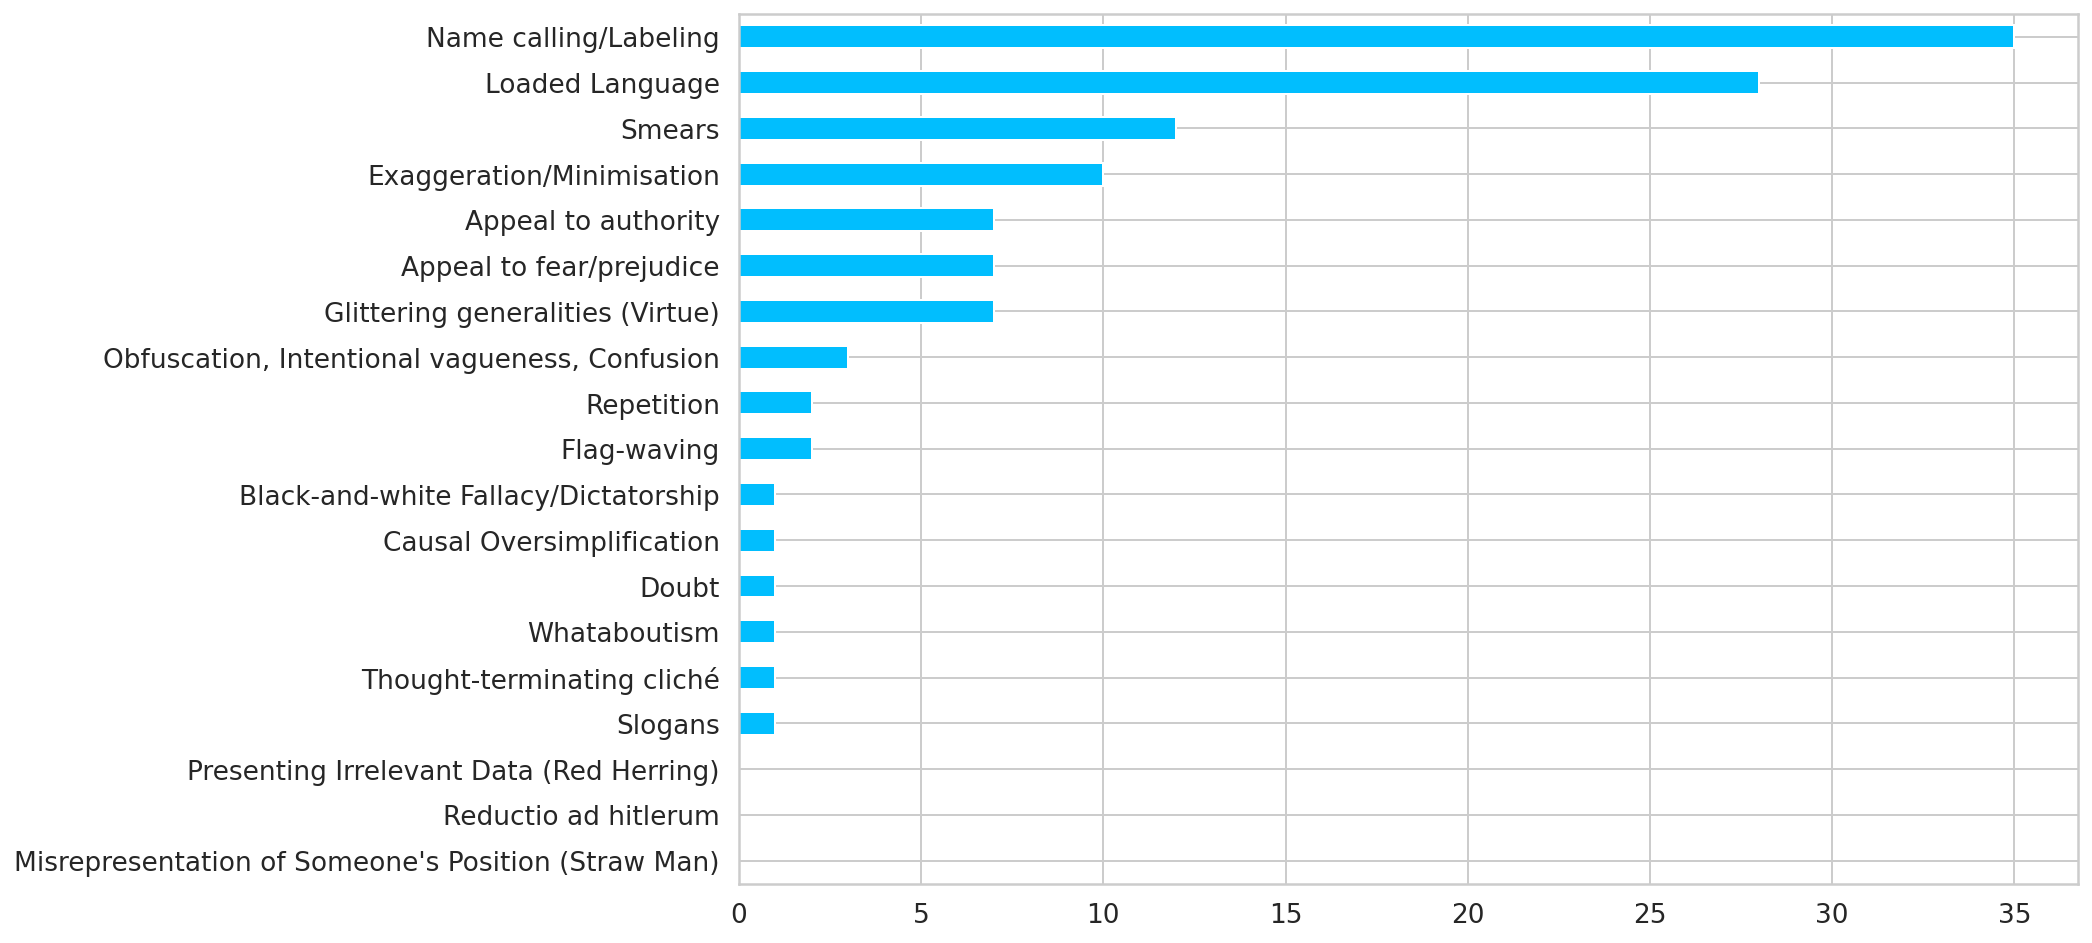

In [ ]:
dev_df[propaganda_techniques_names].sum().sort_values().plot(kind="barh");


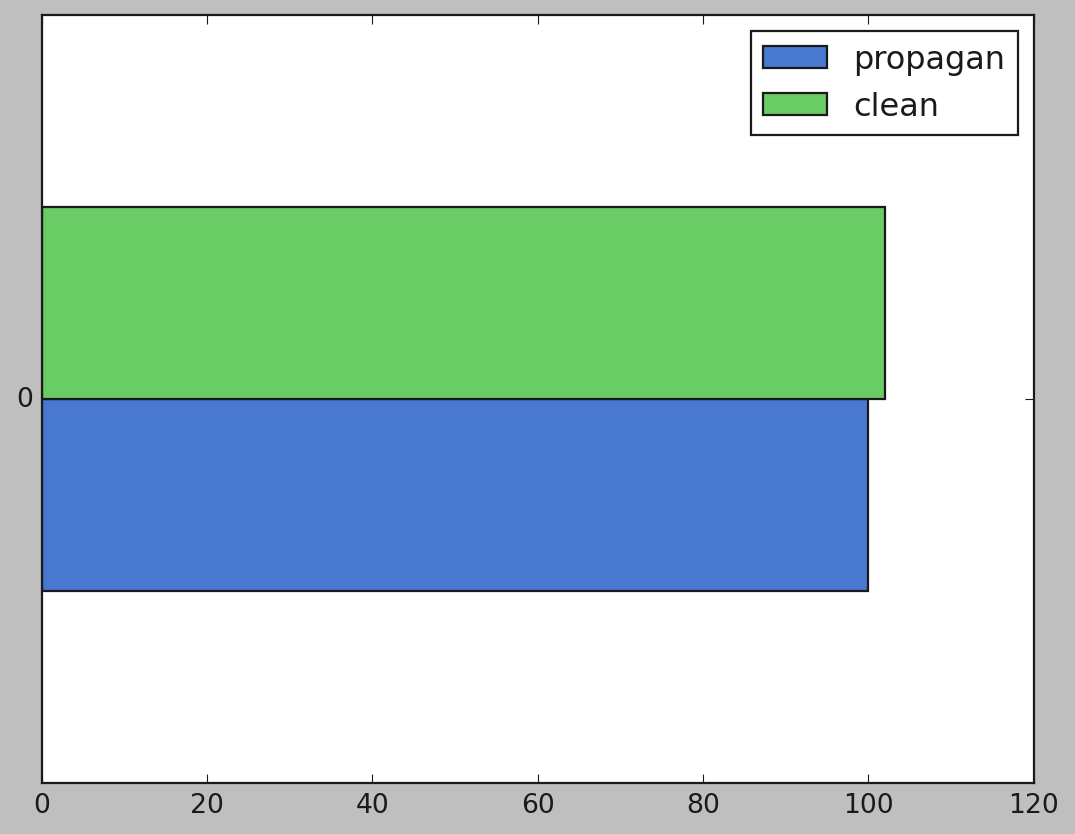

In [ ]:
train_propagan = train_df[train_df[propaganda_techniques_names].sum(axis=1) > 0]
train_clean = train_df[train_df[propaganda_techniques_names].sum(axis=1) == 0]
pd.DataFrame(dict(
  propagan=[len(train_propagan)],
  clean=[len(train_clean)]
)).plot(kind='barh');

In [ ]:
train_df = pd.concat([
  train_propagan.sample(100),
  train_clean
])
train_df.shape

(202, 21)

In [ ]:
BERT_MODEL_NAME = "asafaya/bert-base-arabic"
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/326k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

In [ ]:
sample_row = train_df.iloc[16]
sample_comment = sample_row.text
sample_labels = sample_row[propaganda_techniques_names]
print(sample_comment)
print()
print(sample_labels.to_dict())

قائد حماس يكشف أعداد المقاتلين الفلسطينين الذين فقدوا أرواحهم خلال الحرب الأخيرة مع إسرائيل

{'Appeal to authority': 0, 'Appeal to fear/prejudice': 0, 'Black-and-white Fallacy/Dictatorship': 0, 'Causal Oversimplification': 0, 'Doubt': 0, 'Exaggeration/Minimisation': 0, 'Flag-waving': 0, 'Glittering generalities (Virtue)': 0, 'Loaded Language': 1, "Misrepresentation of Someone's Position (Straw Man)": 0, 'Name calling/Labeling': 1, 'Obfuscation, Intentional vagueness, Confusion': 0, 'Presenting Irrelevant Data (Red Herring)': 0, 'Reductio ad hitlerum': 0, 'Repetition': 0, 'Slogans': 0, 'Smears': 0, 'Thought-terminating cliché': 0, 'Whataboutism': 0}


In [ ]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [ ]:
encoding["input_ids"].squeeze()[:20]

tensor([    2,  6188,  7413,  9237,  5087, 24726,  4012,  1017,  2481,  2677,
         1751, 15939,  1759,  2054,  3774,  3358,  1776,  3300,     3,     0])

In [ ]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])


['[CLS]', 'قايد', 'حماس', 'يكشف', 'اعداد', 'المقاتلين', 'الفلسطيني', '##ن', 'الذين', 'فقد', '##وا', 'ارواح', '##هم', 'خلال', 'الحرب', 'الاخيرة', 'مع', 'اسراييل', '[SEP]', '[PAD]']


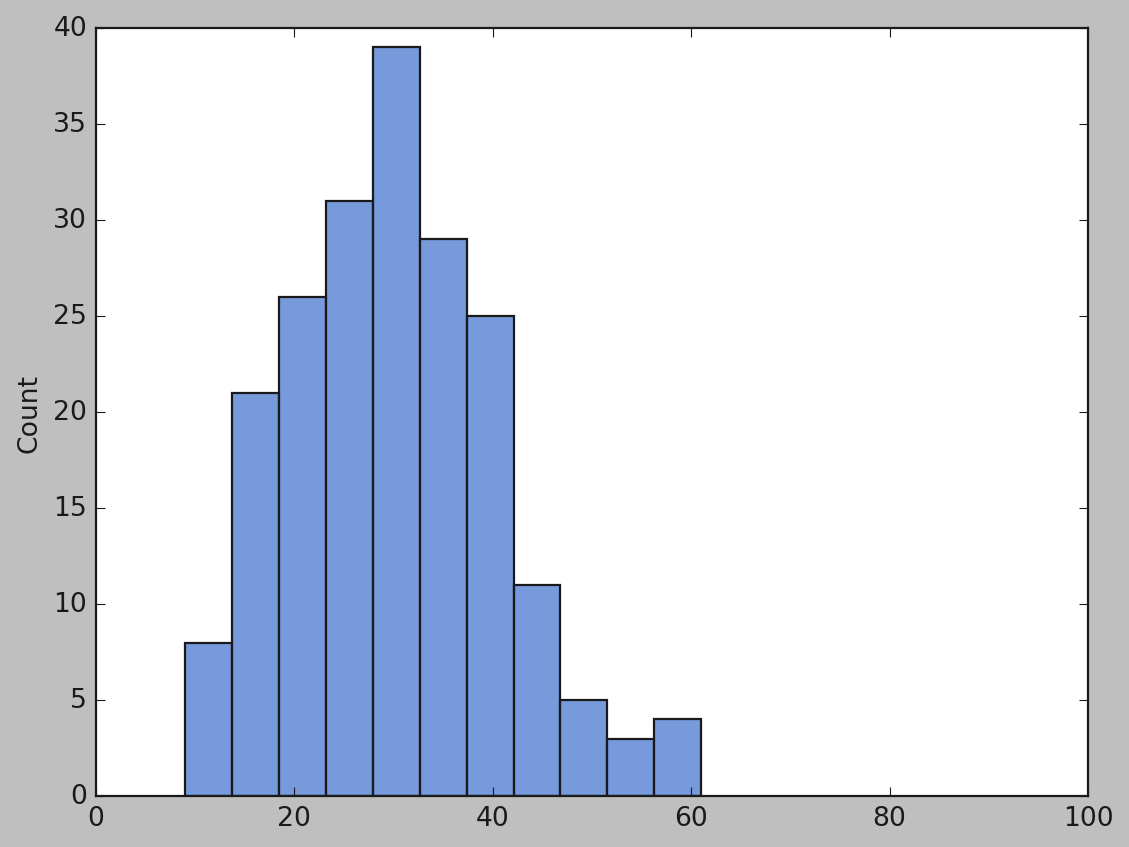

In [ ]:
token_counts = []
for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [ ]:
MAX_TOKEN_COUNT = 70


In [ ]:
class propaganCommentsDataset(Dataset):
  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    comment_text = data_row.text
    labels = data_row[propaganda_techniques_names]
    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [ ]:
train_dataset = propaganCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
sample_item["comment_text"]


'RT SaudiNews50 الدفاع المدني الألعاب النارية خطر يهد الأطفالاتعكروا فرحة العيد باقتنائها'

In [ ]:
sample_item["labels"]


tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])

In [ ]:
sample_item["input_ids"].shape


torch.Size([70])

In [ ]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(torch.Size([8, 70]), torch.Size([8, 70]))

In [ ]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])


In [ ]:
output.last_hidden_state.shape, output.pooler_output.shape


(torch.Size([8, 70, 768]), torch.Size([8, 768]))

In [ ]:
bert_model.config.hidden_size


768

In [ ]:
class propaganCommentDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
  def setup(self, stage=None):
    self.train_dataset = propaganCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )
    self.test_dataset = propaganCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )
  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )
  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 12
data_module = propaganCommentDataModule(
  train_df,
  dev_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
class propaganCommentTagger(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss
  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    for i, name in enumerate(propaganda_techniques_names):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [ ]:
'''dummy_model = nn.Linear(2, 1)
optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)
warmup_steps = 20
total_training_steps = 100
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)
learning_rate_history = []
for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();'''

'dummy_model = nn.Linear(2, 1)\noptimizer = AdamW(params=dummy_model.parameters(), lr=0.001)\nwarmup_steps = 20\ntotal_training_steps = 100\nscheduler = get_linear_schedule_with_warmup(\n  optimizer,\n  num_warmup_steps=warmup_steps,\n  num_training_steps=total_training_steps\n)\nlearning_rate_history = []\nfor step in range(total_training_steps):\n  optimizer.step()\n  scheduler.step()\n  learning_rate_history.append(optimizer.param_groups[0][\'lr\'])\nplt.plot(learning_rate_history, label="learning rate")\nplt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")\nplt.legend()\nplt.xlabel("Step")\nplt.ylabel("Learning rate")\nplt.tight_layout();'

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(32, 160)

In [ ]:
model = propaganCommentTagger(
  n_classes=len(propaganda_techniques_names),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
criterion = nn.BCELoss()
prediction = torch.FloatTensor(
  [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor(
  [1., 0., 0., 0., 1., 0.]
)
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [ ]:
criterion(torch.sigmoid(prediction), labels)


tensor(0.8725)

In [ ]:
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

tensor([[0.5010, 0.5137, 0.4140, 0.4823, 0.4370, 0.6020, 0.4326, 0.6048, 0.4907,
         0.5438, 0.5188, 0.4421, 0.5584, 0.6021, 0.4317, 0.5473, 0.4527, 0.6214,
         0.5760],
        [0.4653, 0.5012, 0.4488, 0.4689, 0.4560, 0.5786, 0.4450, 0.6605, 0.5195,
         0.5486, 0.4654, 0.4185, 0.5512, 0.5537, 0.4685, 0.5081, 0.4326, 0.6126,
         0.5721],
        [0.5199, 0.5496, 0.4487, 0.5113, 0.4502, 0.5822, 0.4581, 0.5952, 0.5282,
         0.5356, 0.4746, 0.4157, 0.5387, 0.5267, 0.4731, 0.5296, 0.4288, 0.5677,
         0.5612],
        [0.5399, 0.6103, 0.4390, 0.4575, 0.5595, 0.6479, 0.4698, 0.5528, 0.4923,
         0.5314, 0.4699, 0.3335, 0.5816, 0.5291, 0.6133, 0.4630, 0.5635, 0.5242,
         0.4881],
        [0.5483, 0.6139, 0.4396, 0.4979, 0.5514, 0.6204, 0.5022, 0.5515, 0.5079,
         0.4578, 0.4479, 0.3781, 0.5780, 0.5697, 0.5857, 0.5055, 0.5264, 0.5431,
         0.5167],
        [0.4810, 0.4925, 0.4194, 0.4348, 0.4283, 0.6119, 0.4567, 0.5927, 0.5274,
         0.5546, 0.

In [ ]:
criterion(predictions, sample_batch["labels"])


tensor(0.7261, grad_fn=<BinaryCrossEntropyBackward0>)

In [ ]:
'''from sklearn import metrics
fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]
tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]
_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show();'''

'from sklearn import metrics\nfpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,\n       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]\ntpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,\n       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]\n_, ax = plt.subplots()\nax.plot(fpr, tpr, label="ROC")\nax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")\nax.legend(loc=4)\nax.set_xlabel("False positive rate")\nax.set_ylabel("True positive rate")\nax.set_title("Example ROC curve")\nplt.show();'

In [ ]:
'''checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)'''

'checkpoint_callback = ModelCheckpoint(\n  dirpath="checkpoints",\n  filename="best-checkpoint",\n  save_top_k=1,\n  verbose=True,\n  monitor="val_loss",\n  mode="min"\n)'

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="propagan-comments")


In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)


In [ ]:
trainer = pl.Trainer(
    logger=logger,
#     checkpoint_callback=checkpoint_callback,
    callbacks=[early_stopping_callback],
    max_epochs=N_EPOCHS,   
    gpus=1,
)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"


In [ ]:
trainer.fit(model, data_module)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Sanity Checking: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1566: PossibleUserWarning: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tok

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# trainer.test()


In [ ]:
trained_model = propaganCommentTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(propaganda_techniques_names)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def pred(test_comment):
    encoding = tokenizer.encode_plus(
      test_comment,
      add_special_tokens=True,
      max_length=512,
      return_token_type_ids=False,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt',
    )
    _, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
    test_prediction = test_prediction.flatten().numpy()
    return test_prediction
    

In [ ]:
def get_pred_labels(test_comment):
    test_prediction = pred(test_comment)
    predictions = []
    for label, prediction in zip(propaganda_techniques_names, test_prediction):
        if prediction < THRESHOLDS[label]:
            continue
        predictions.append(label)
    if len(predictions) == 0:
        predictions.append('no technique')
    return predictions

In [ ]:
for um , n in enumerate(propaganda_techniques_names):
    print(um , n)

0 Appeal to authority
1 Appeal to fear/prejudice
2 Black-and-white Fallacy/Dictatorship
3 Causal Oversimplification
4 Doubt
5 Exaggeration/Minimisation
6 Flag-waving
7 Glittering generalities (Virtue)
8 Loaded Language
9 Misrepresentation of Someone's Position (Straw Man)
10 Name calling/Labeling
11 Obfuscation, Intentional vagueness, Confusion
12 Presenting Irrelevant Data (Red Herring)
13 Reductio ad hitlerum
14 Repetition
15 Slogans
16 Smears
17 Thought-terminating cliché
18 Whataboutism


In [ ]:
scoress = [pred(row['text']) for index, row in dev_df.iterrows()]


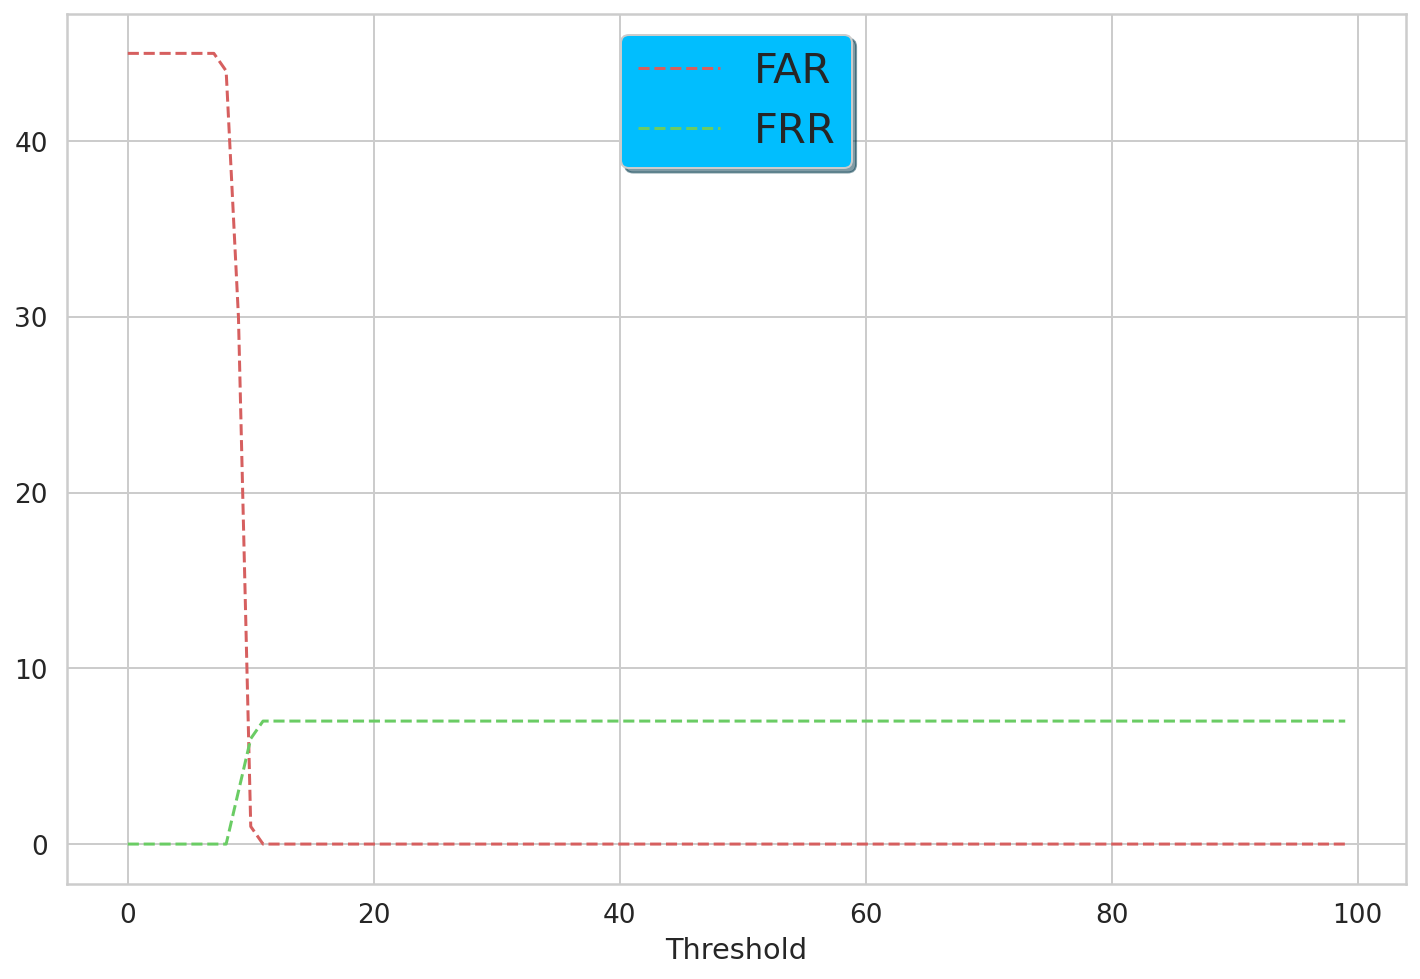

In [ ]:
i = 0
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

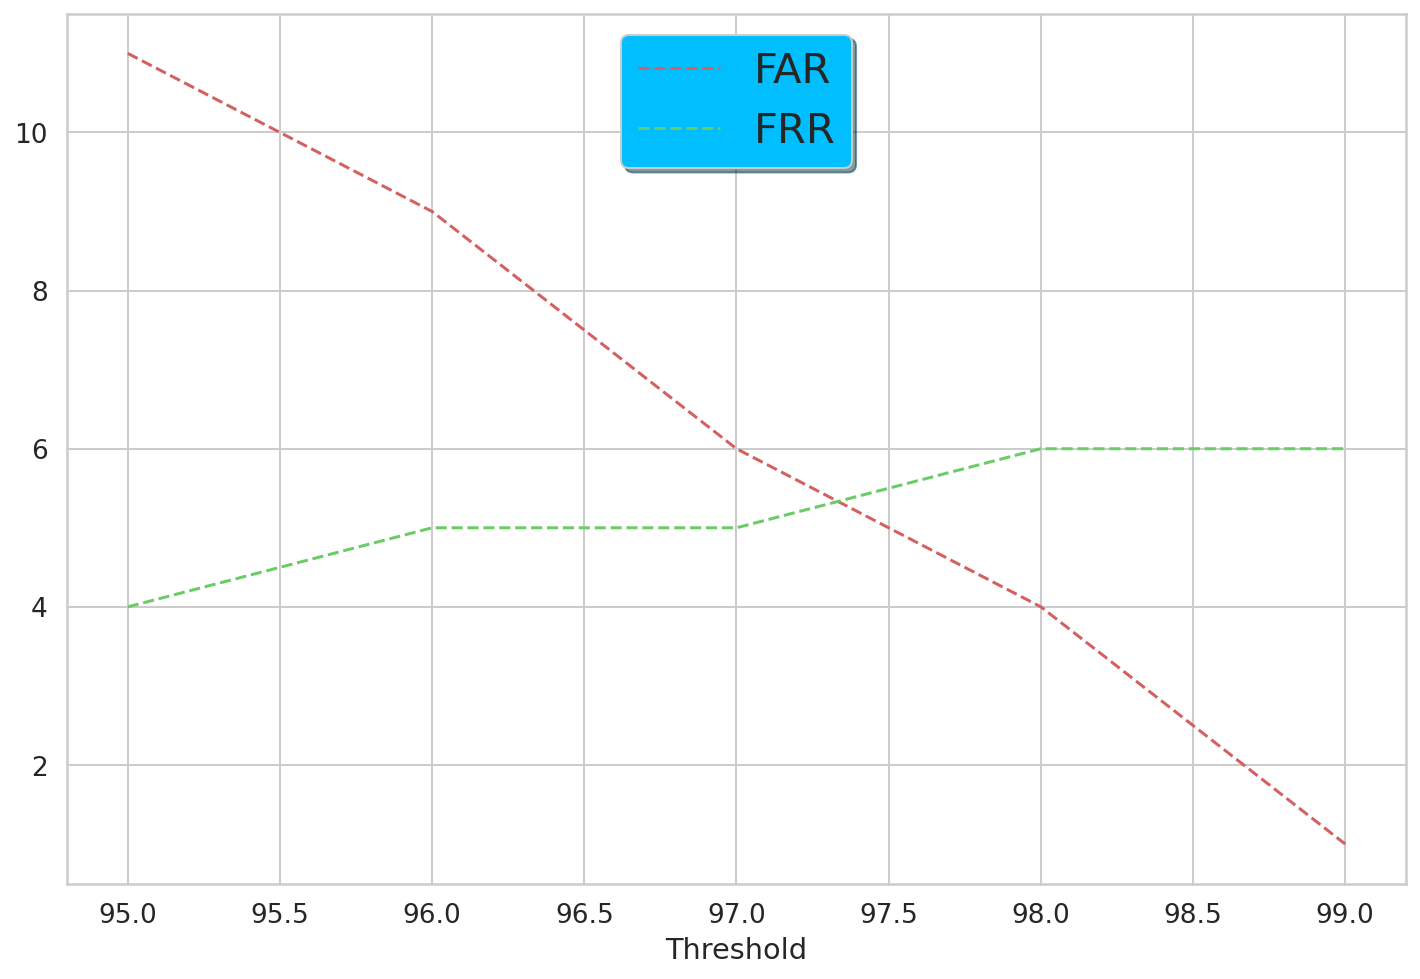

In [ ]:
i = 0
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(95,100,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(95,100,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

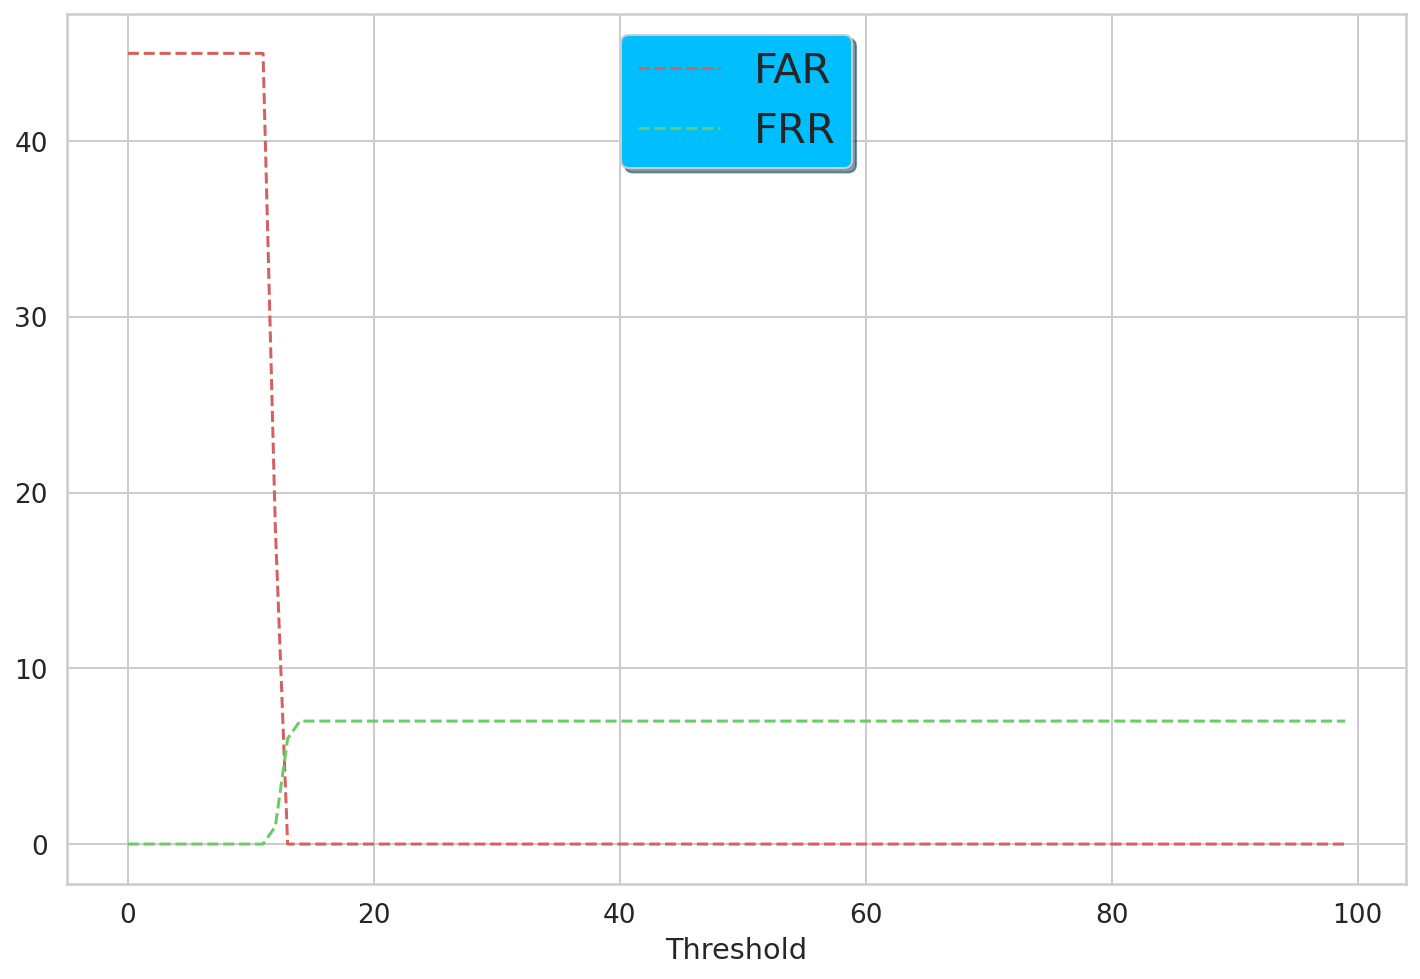

In [ ]:
i = 1
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

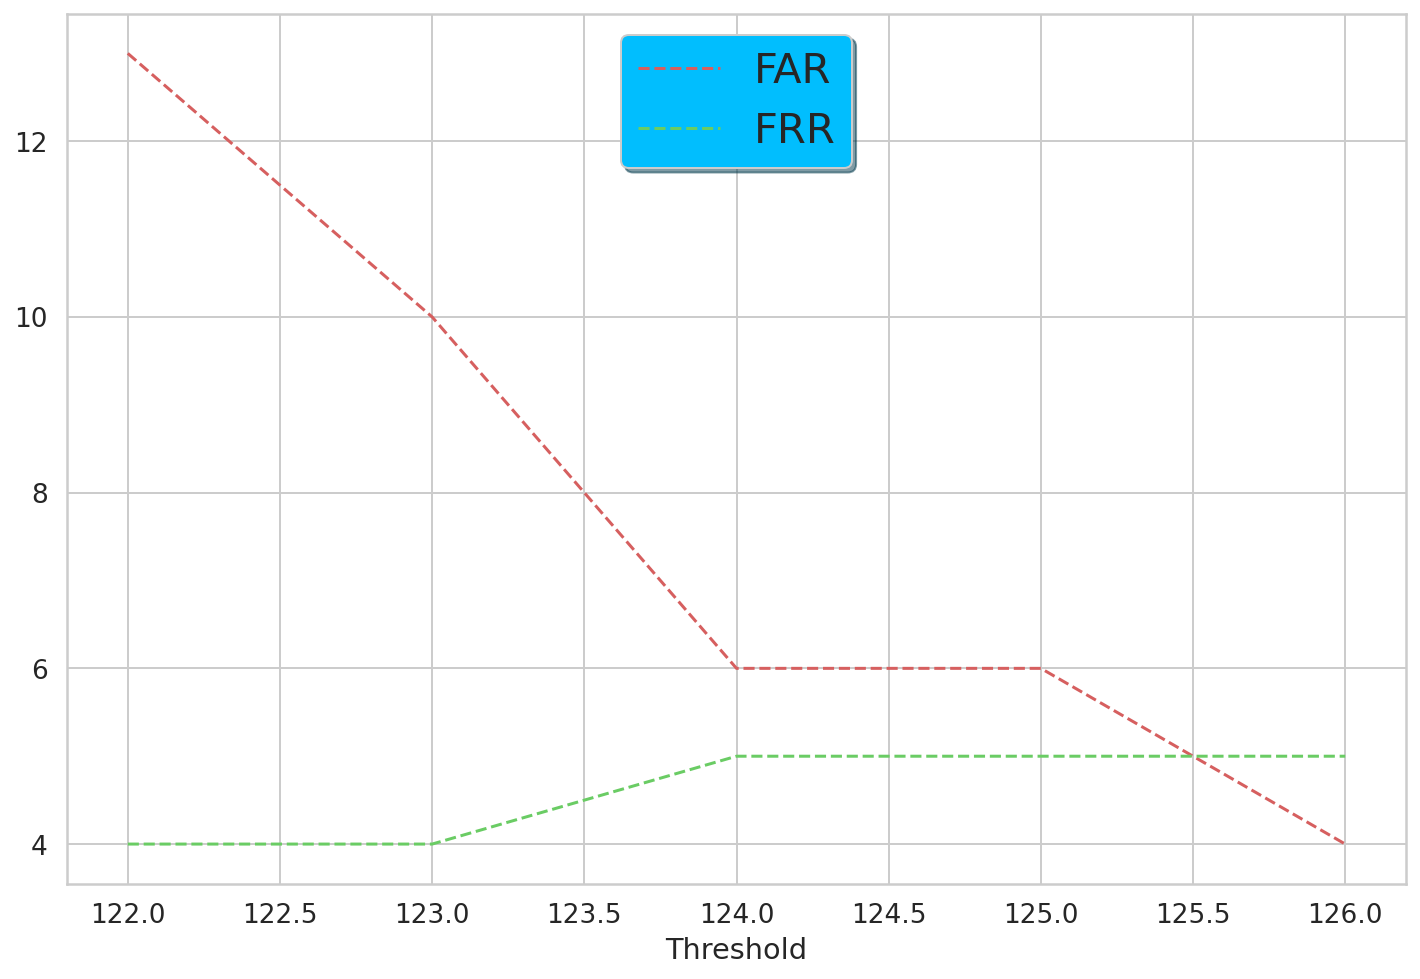

In [ ]:
i = 1
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(122,127,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(122,127,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

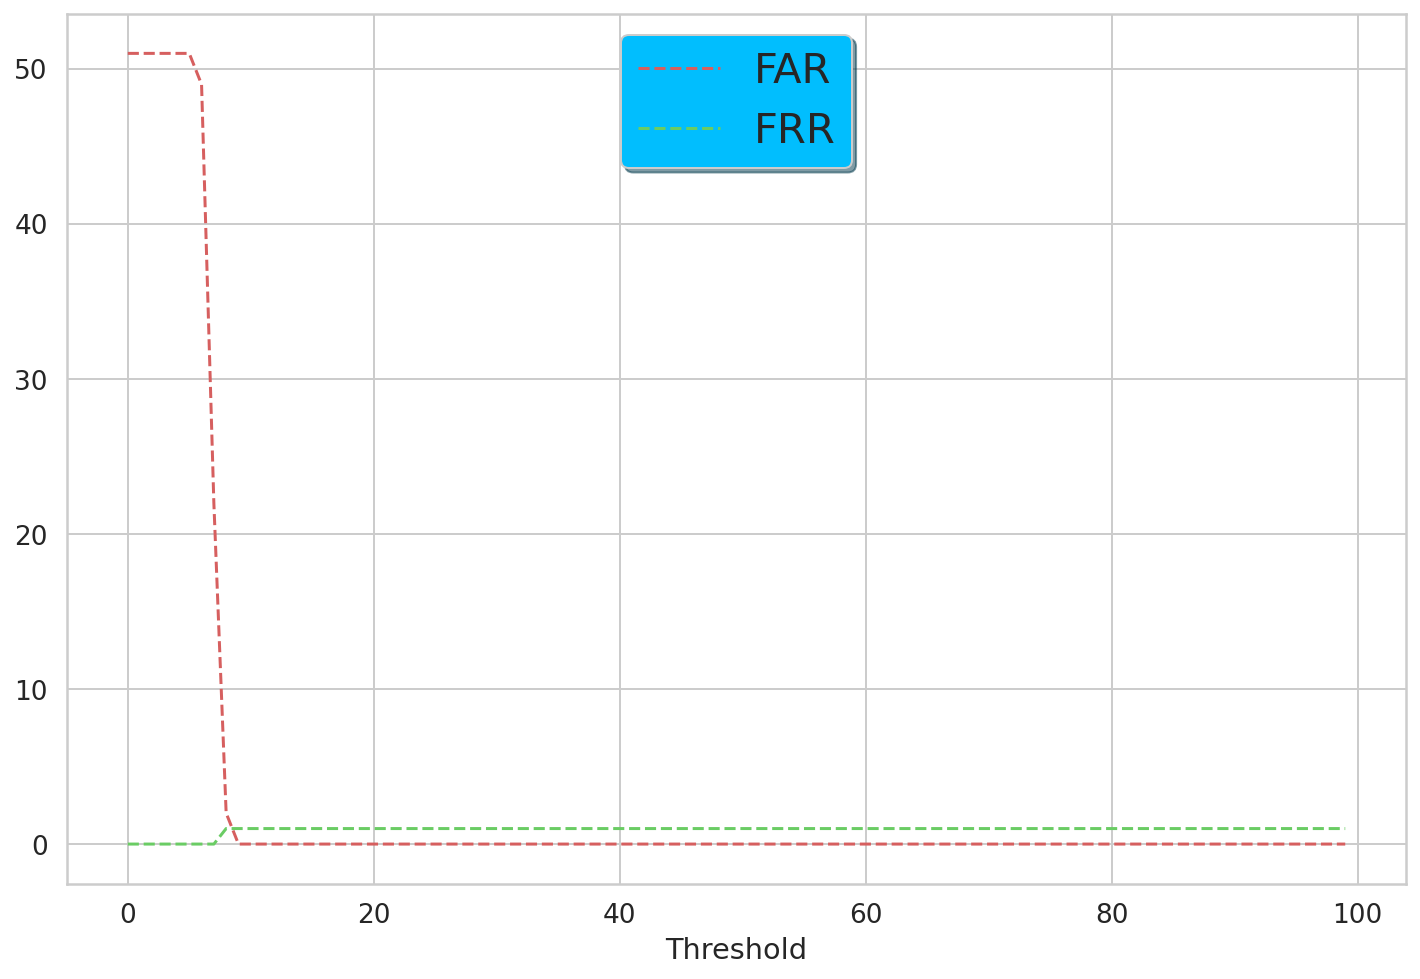

In [ ]:
i = 2
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

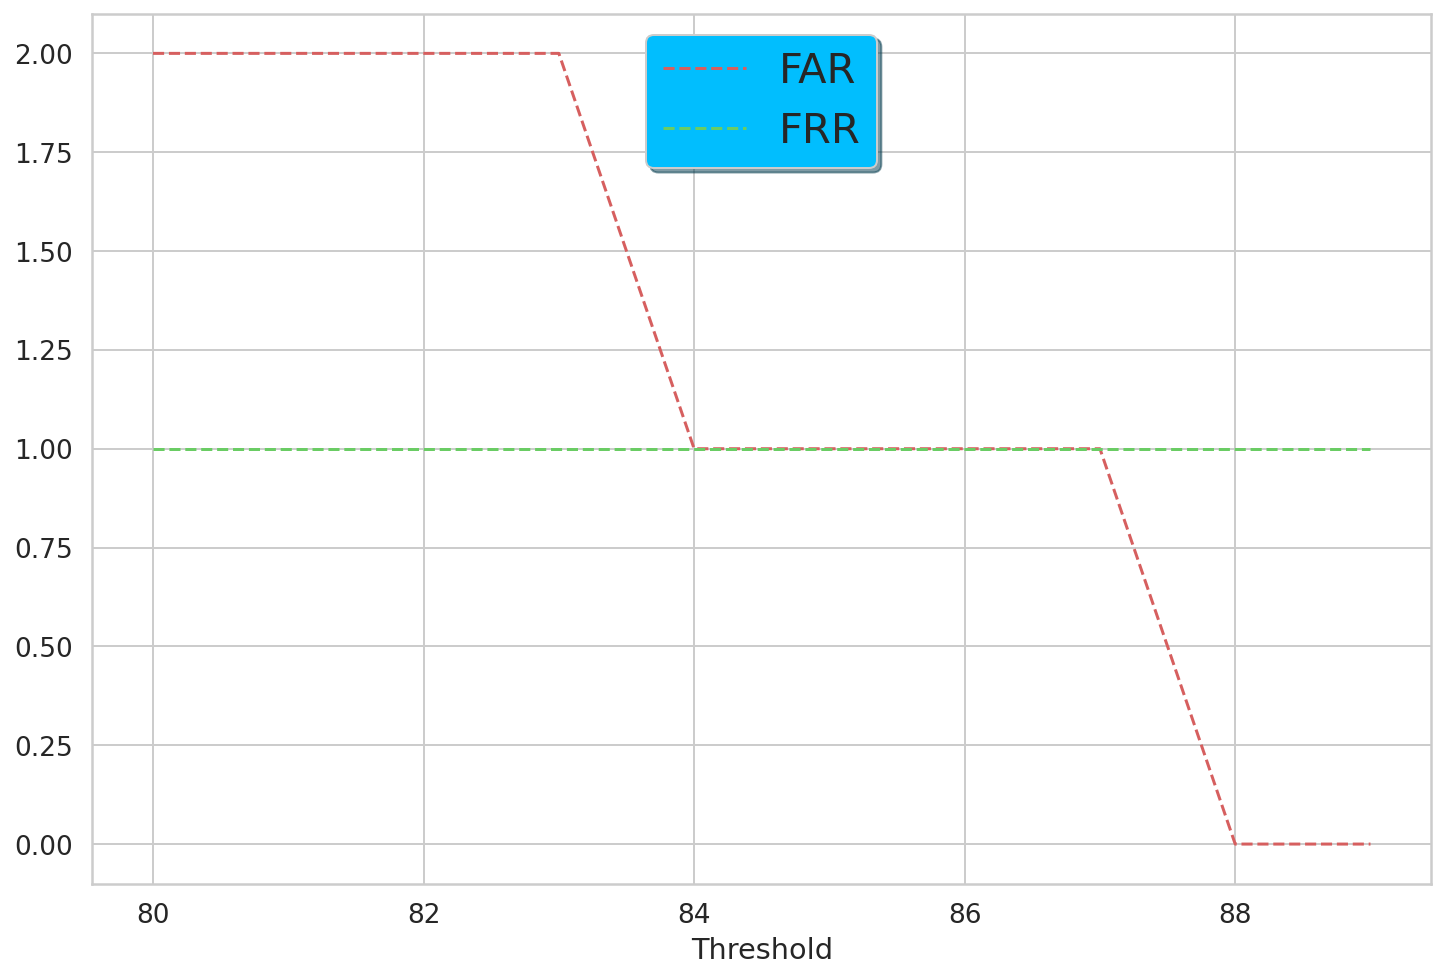

In [ ]:
i = 2
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(80,90,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(80,90,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

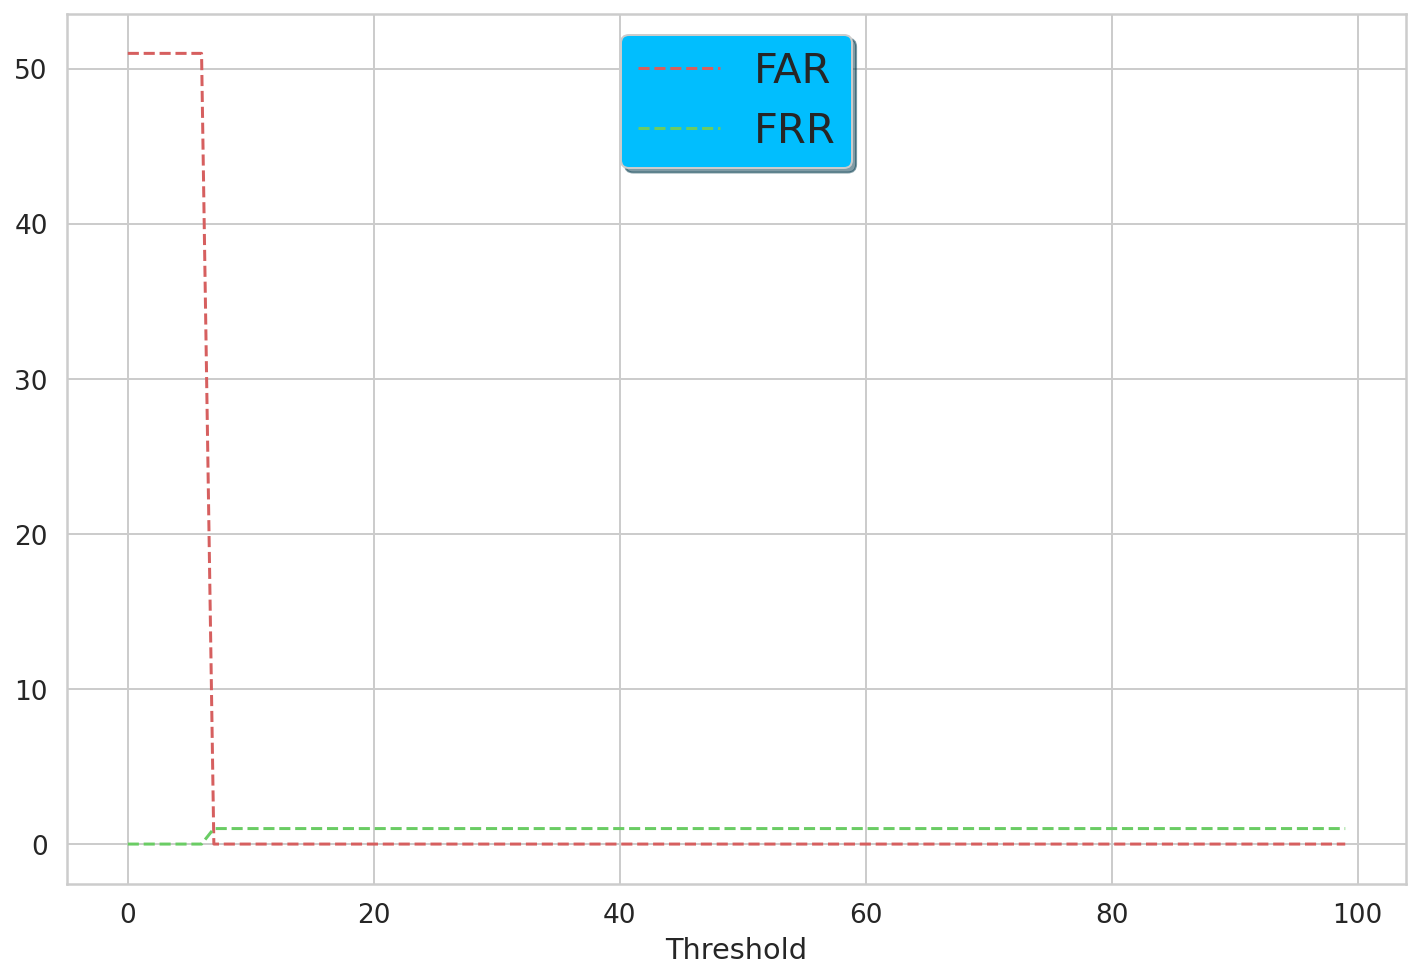

In [ ]:
i = 3
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

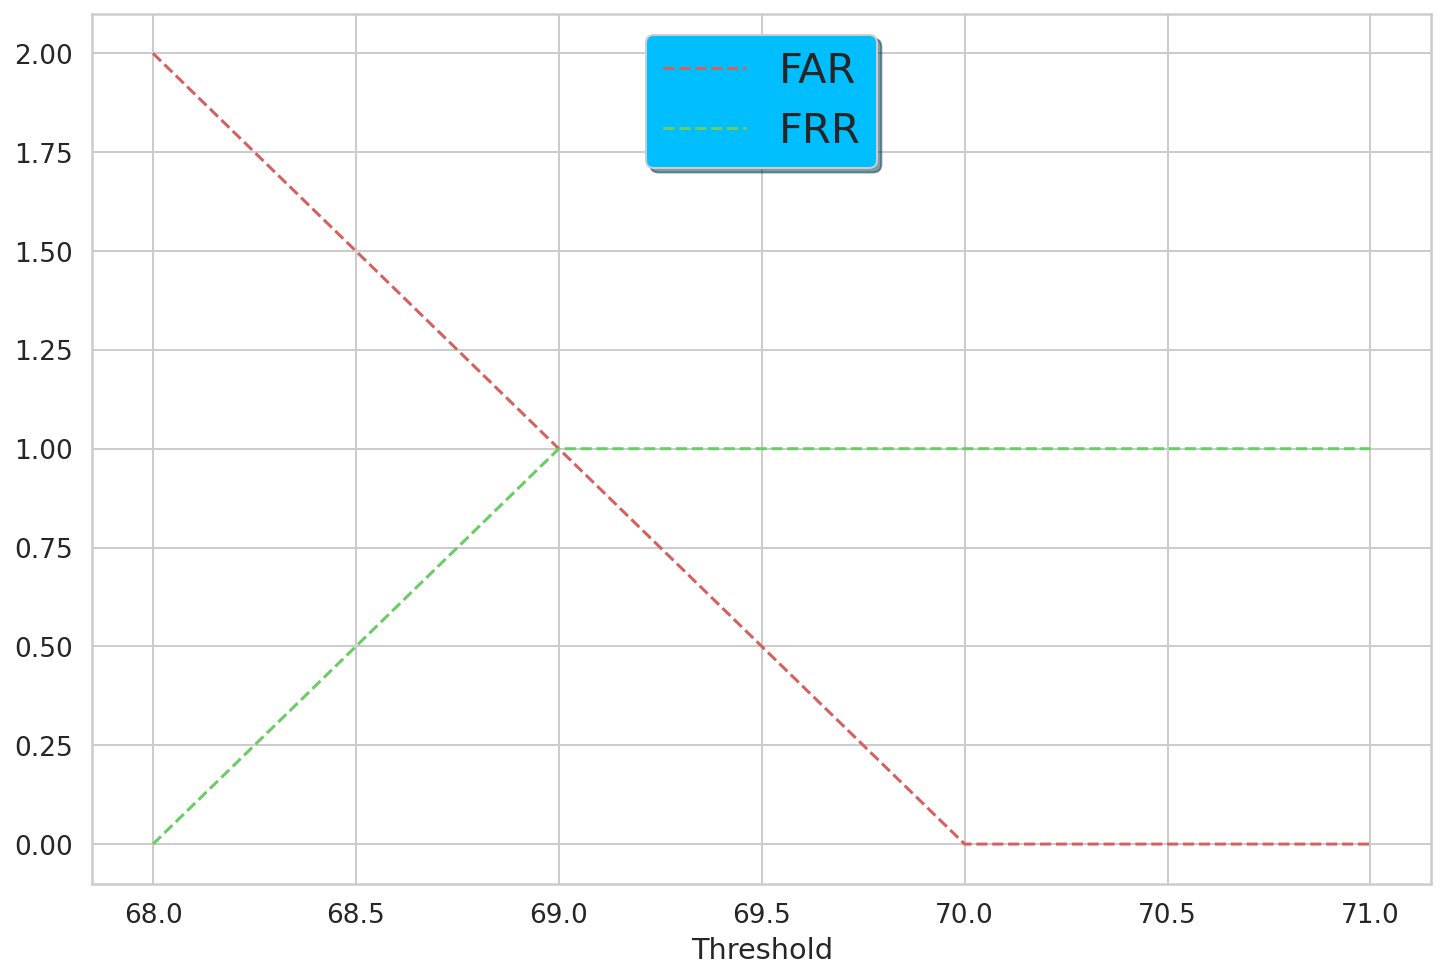

In [ ]:
i = 3
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(68,72,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(68,72,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

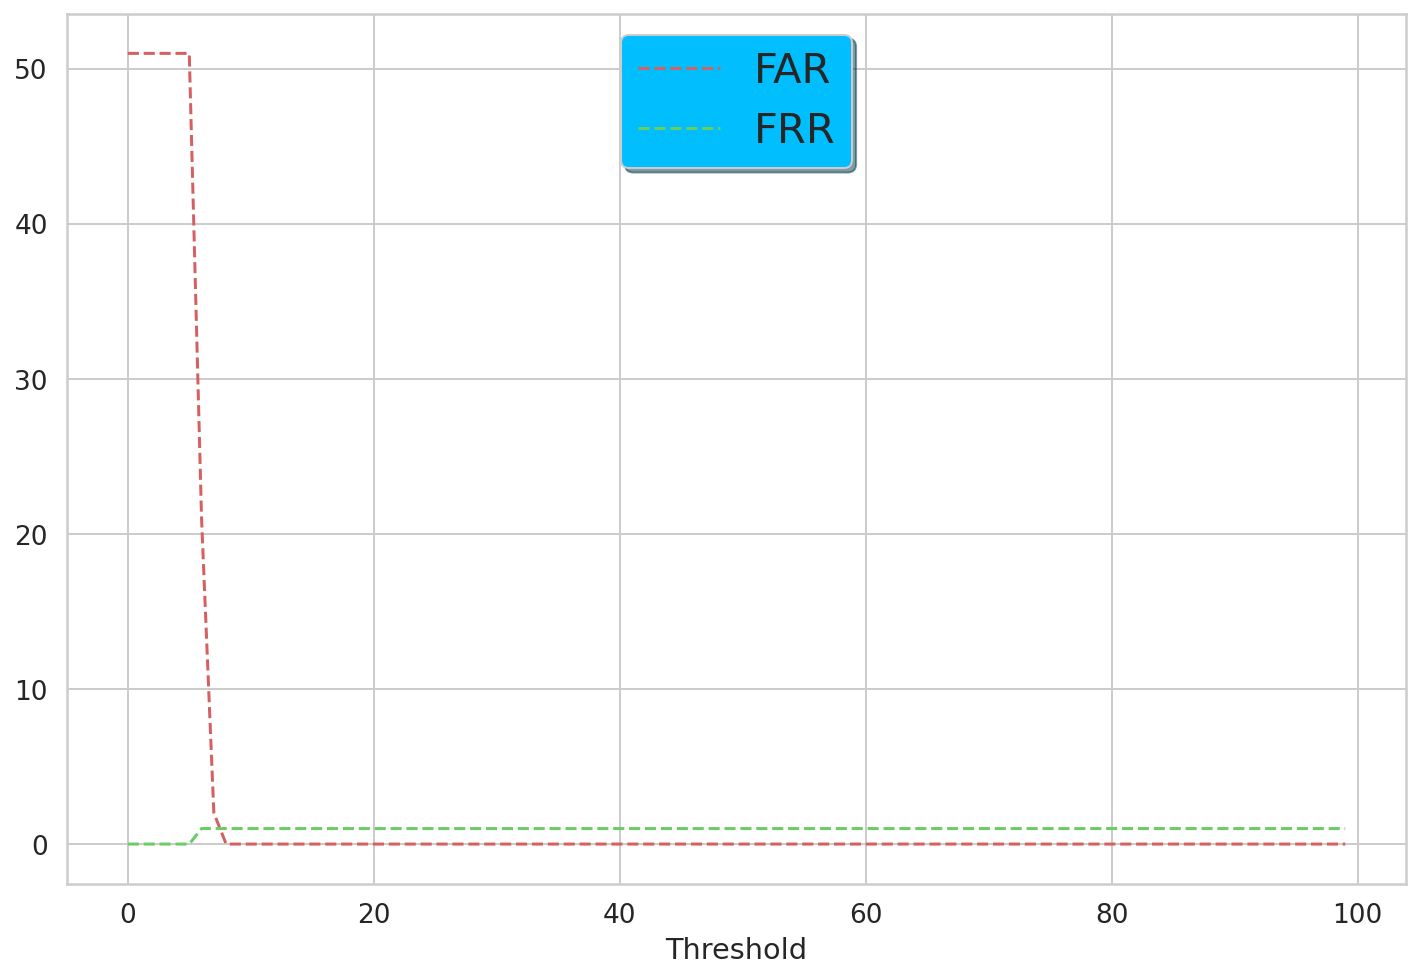

In [ ]:
i = 4
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

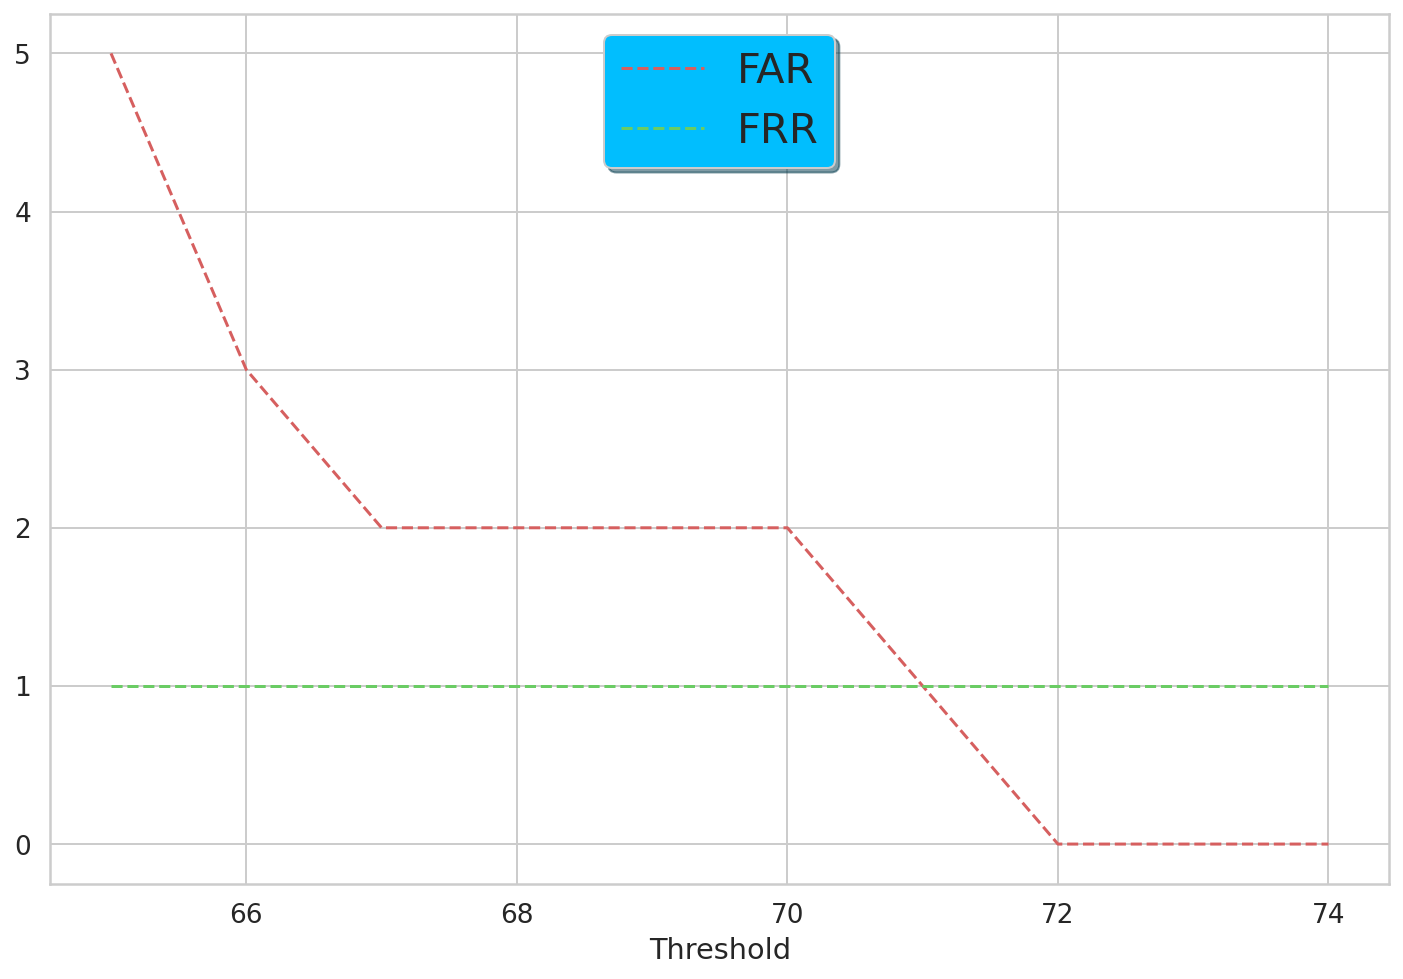

In [ ]:
i = 4
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(65,75,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(65,75,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

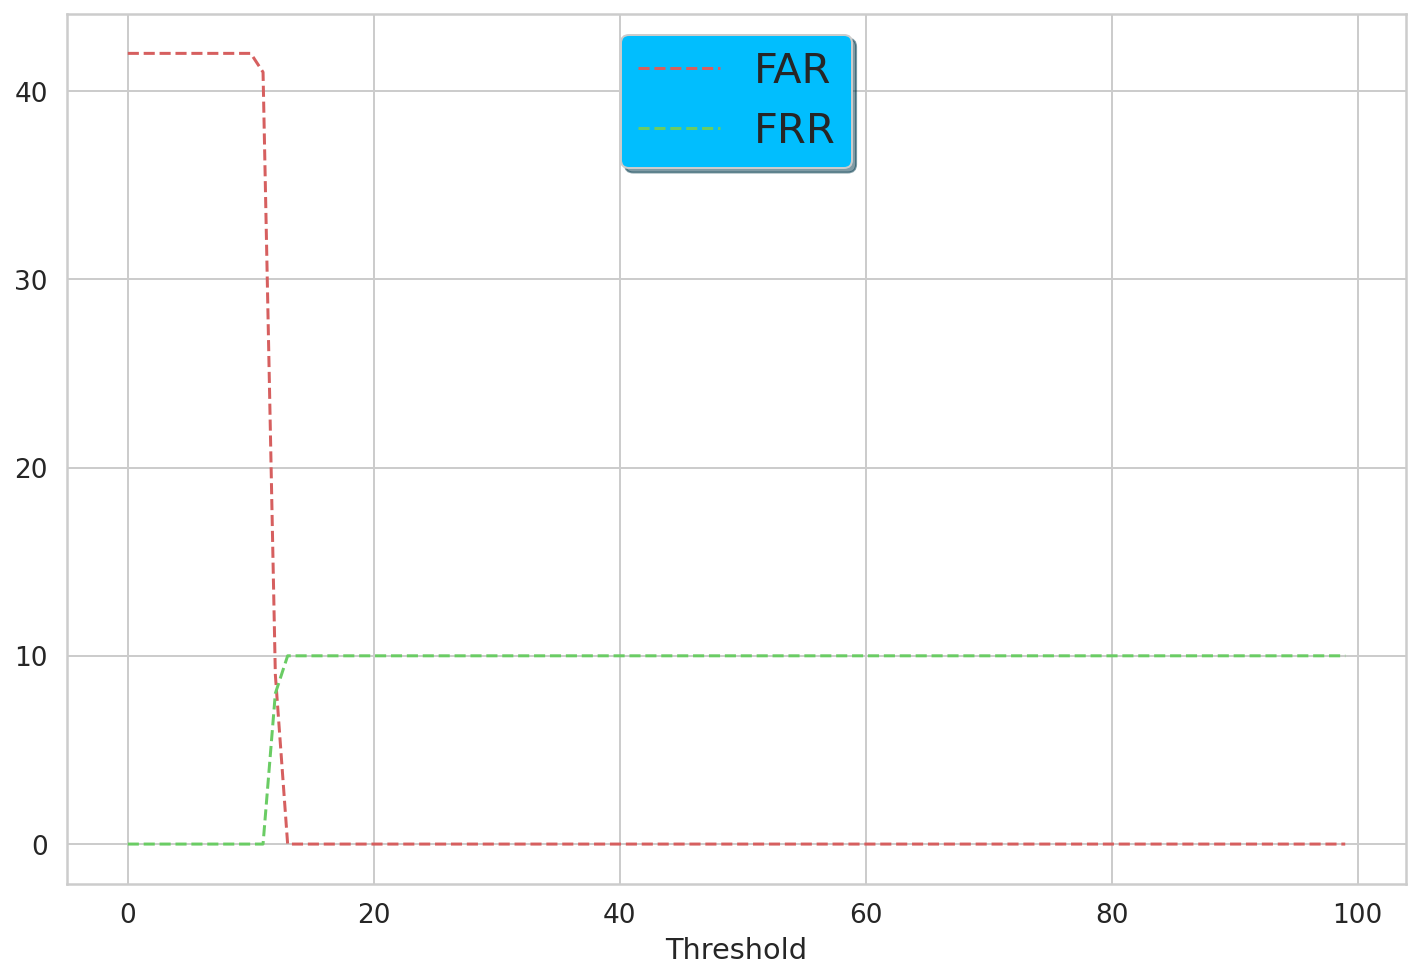

In [ ]:
i = 5
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

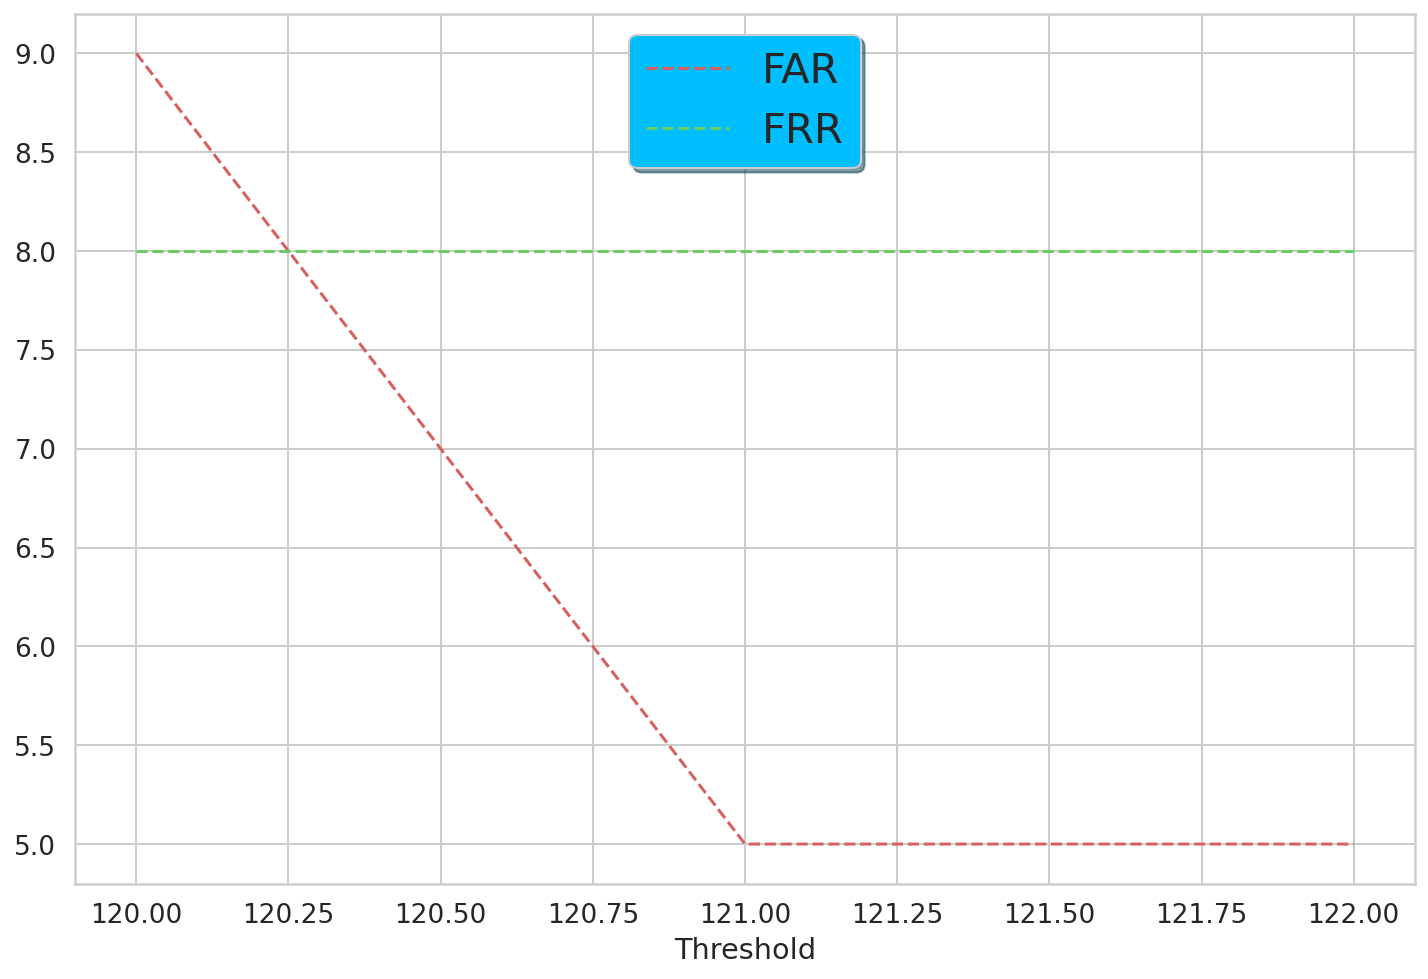

In [ ]:
i = 5
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(120,123,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(120,123,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

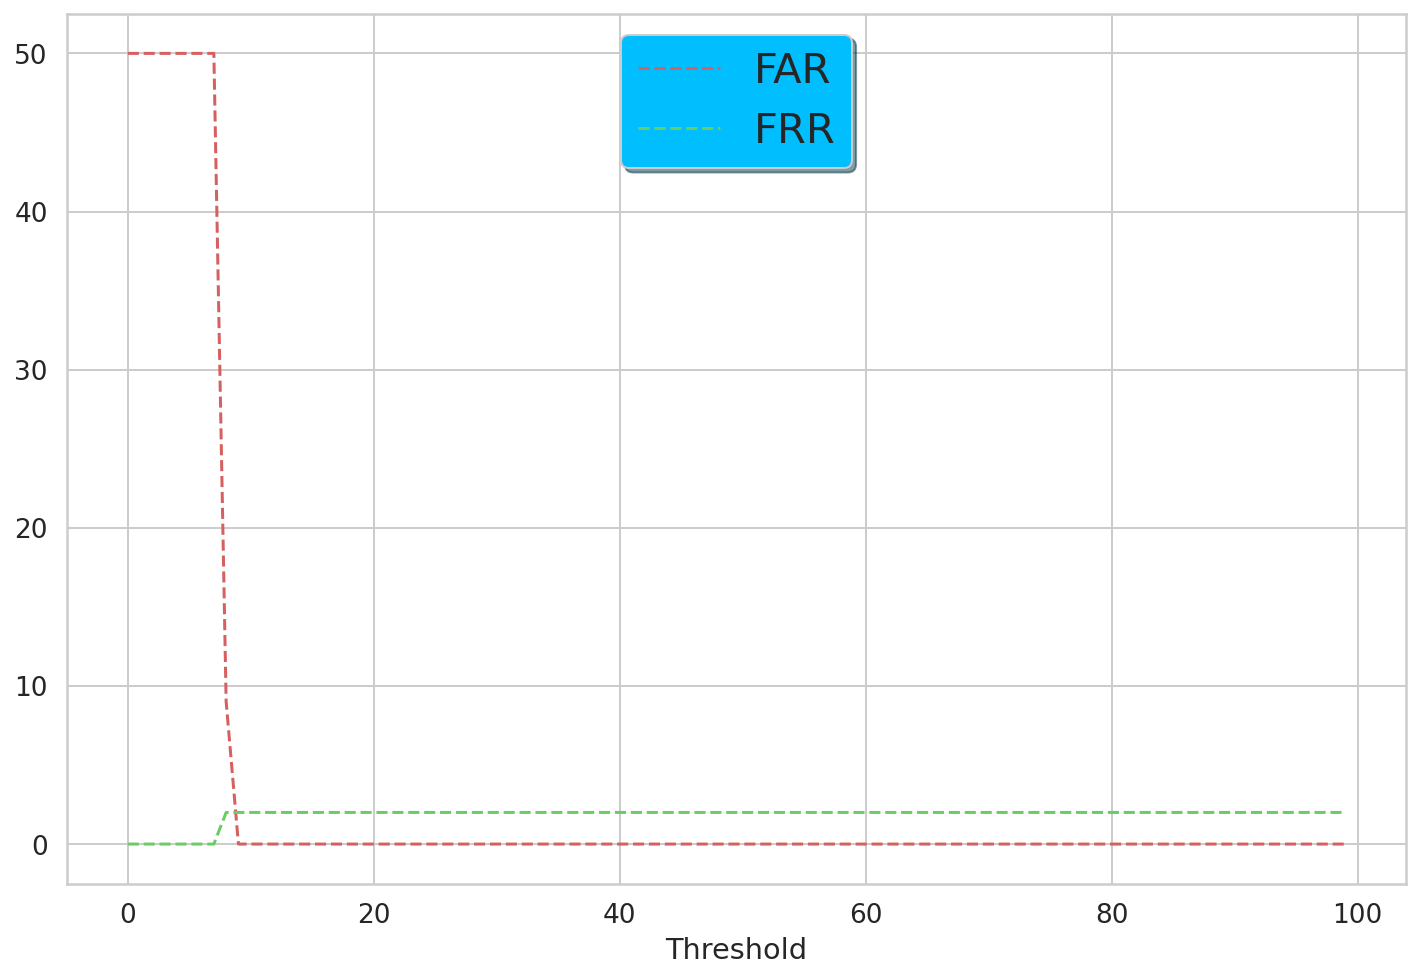

In [ ]:
i = 6
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

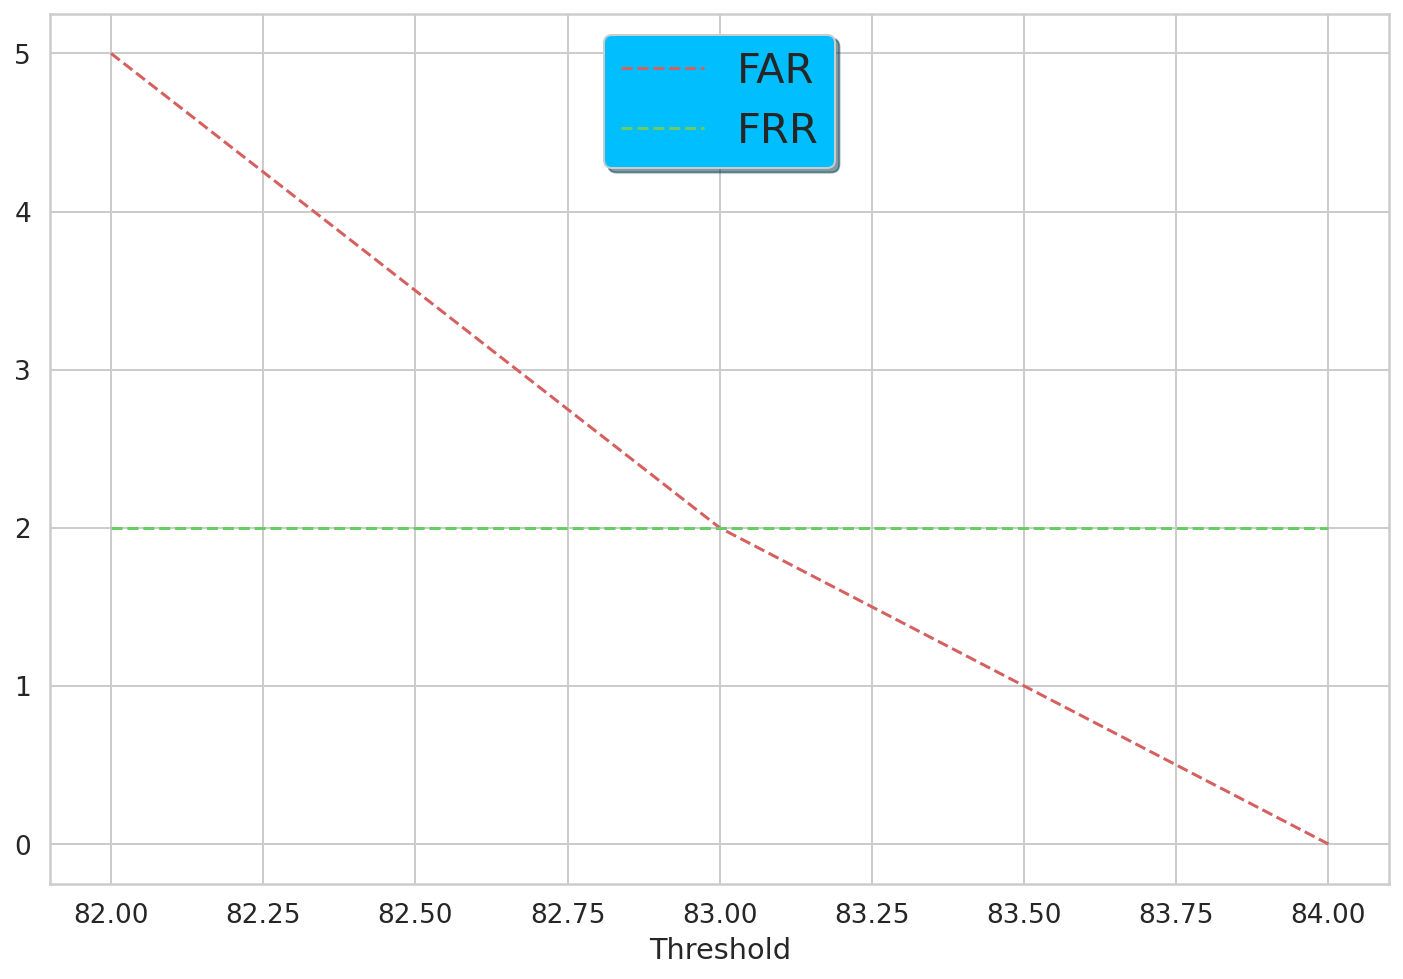

In [ ]:
i = 6
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(82,85,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(82,85,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

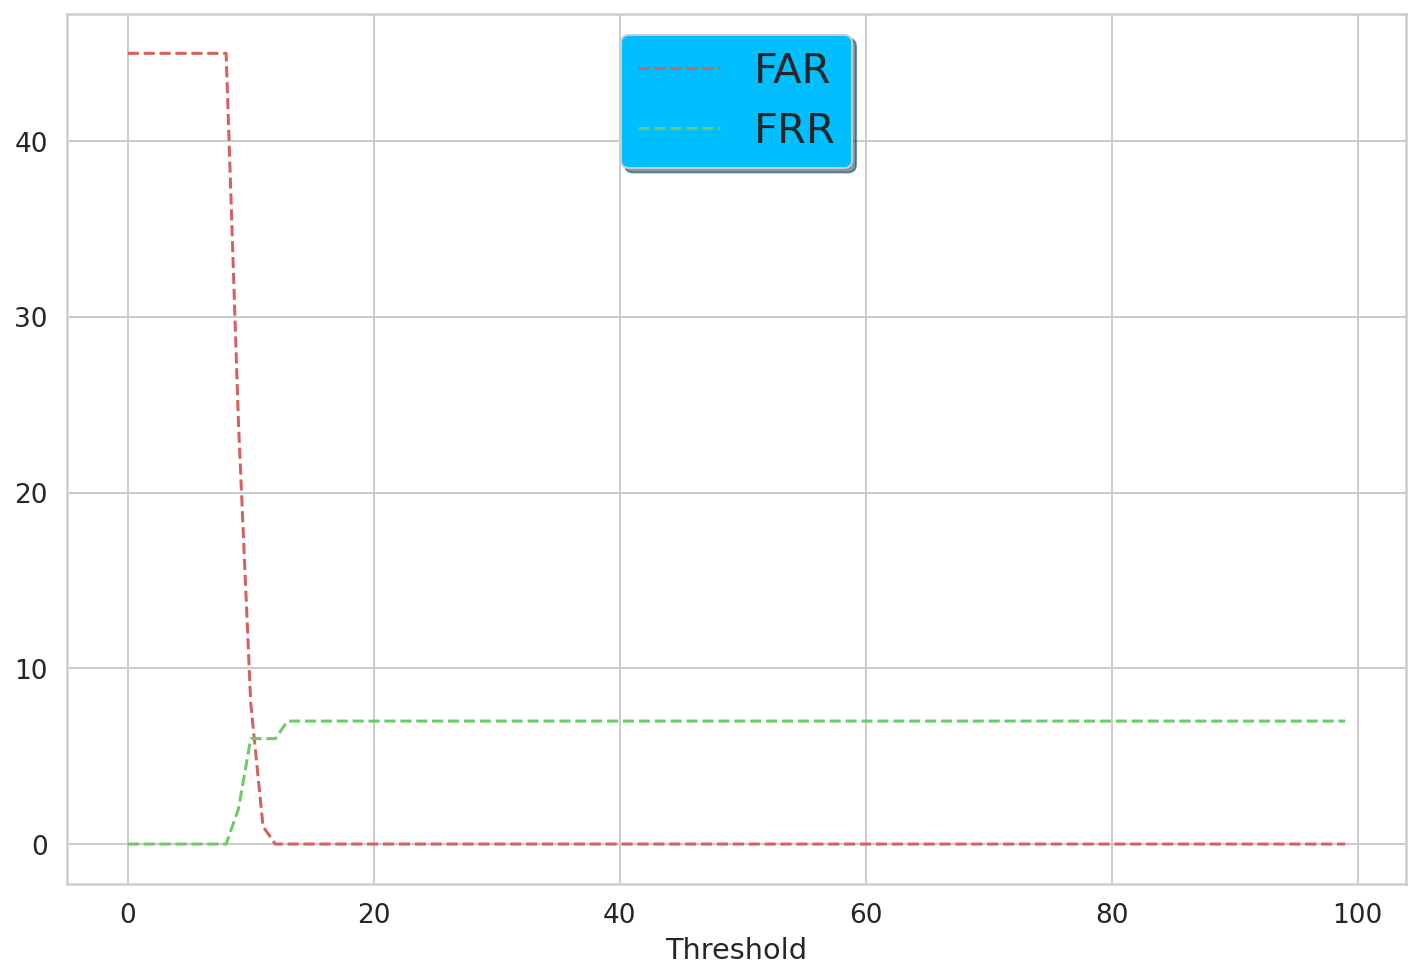

In [ ]:
i = 7
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

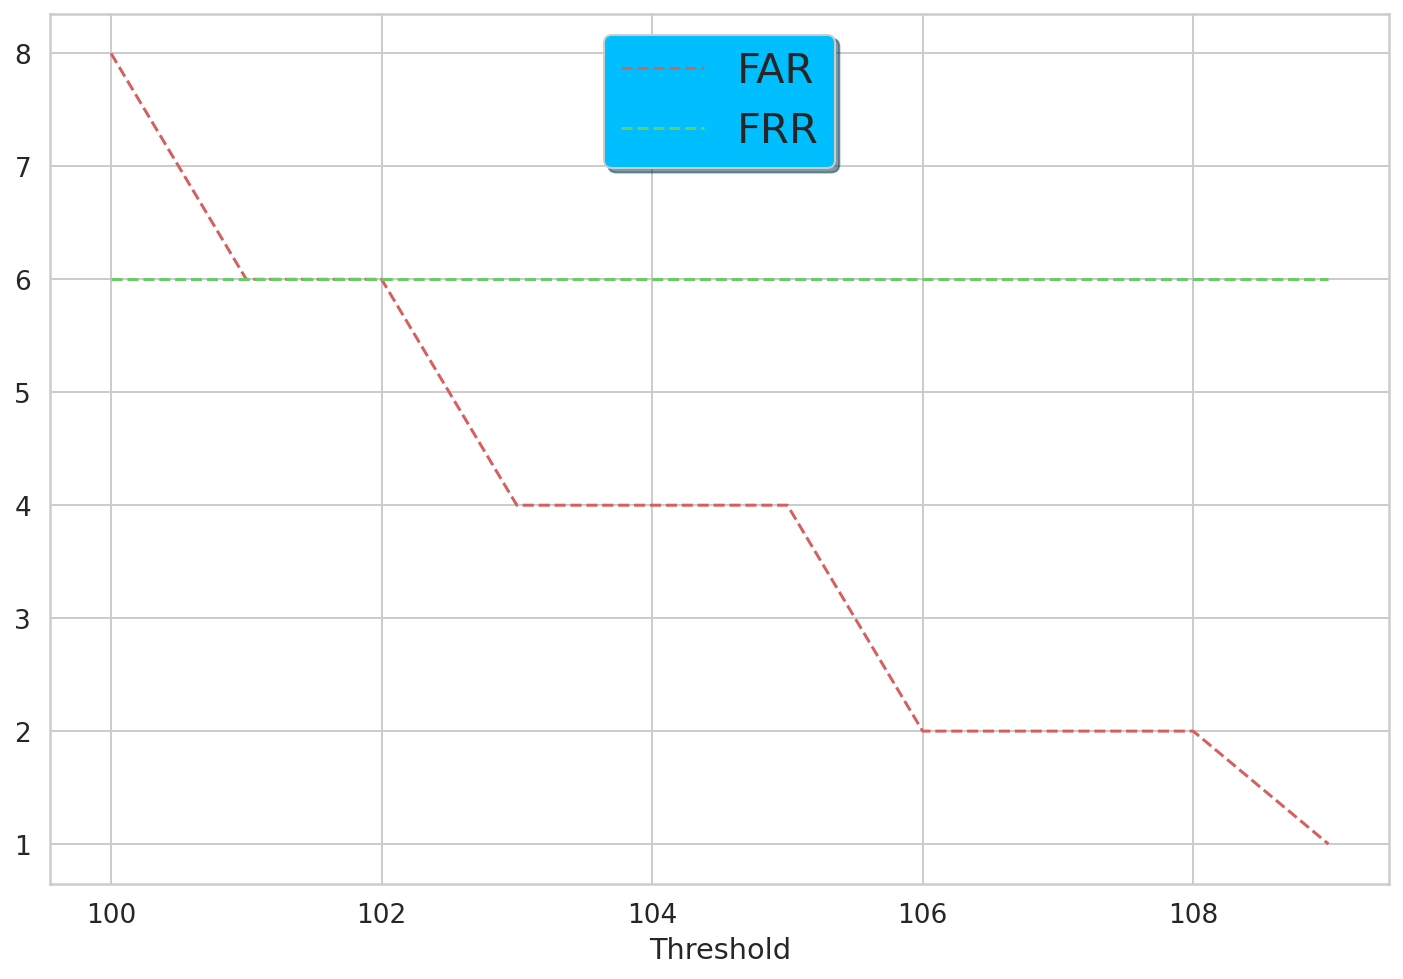

In [ ]:
i = 7
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100,110,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100,110,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

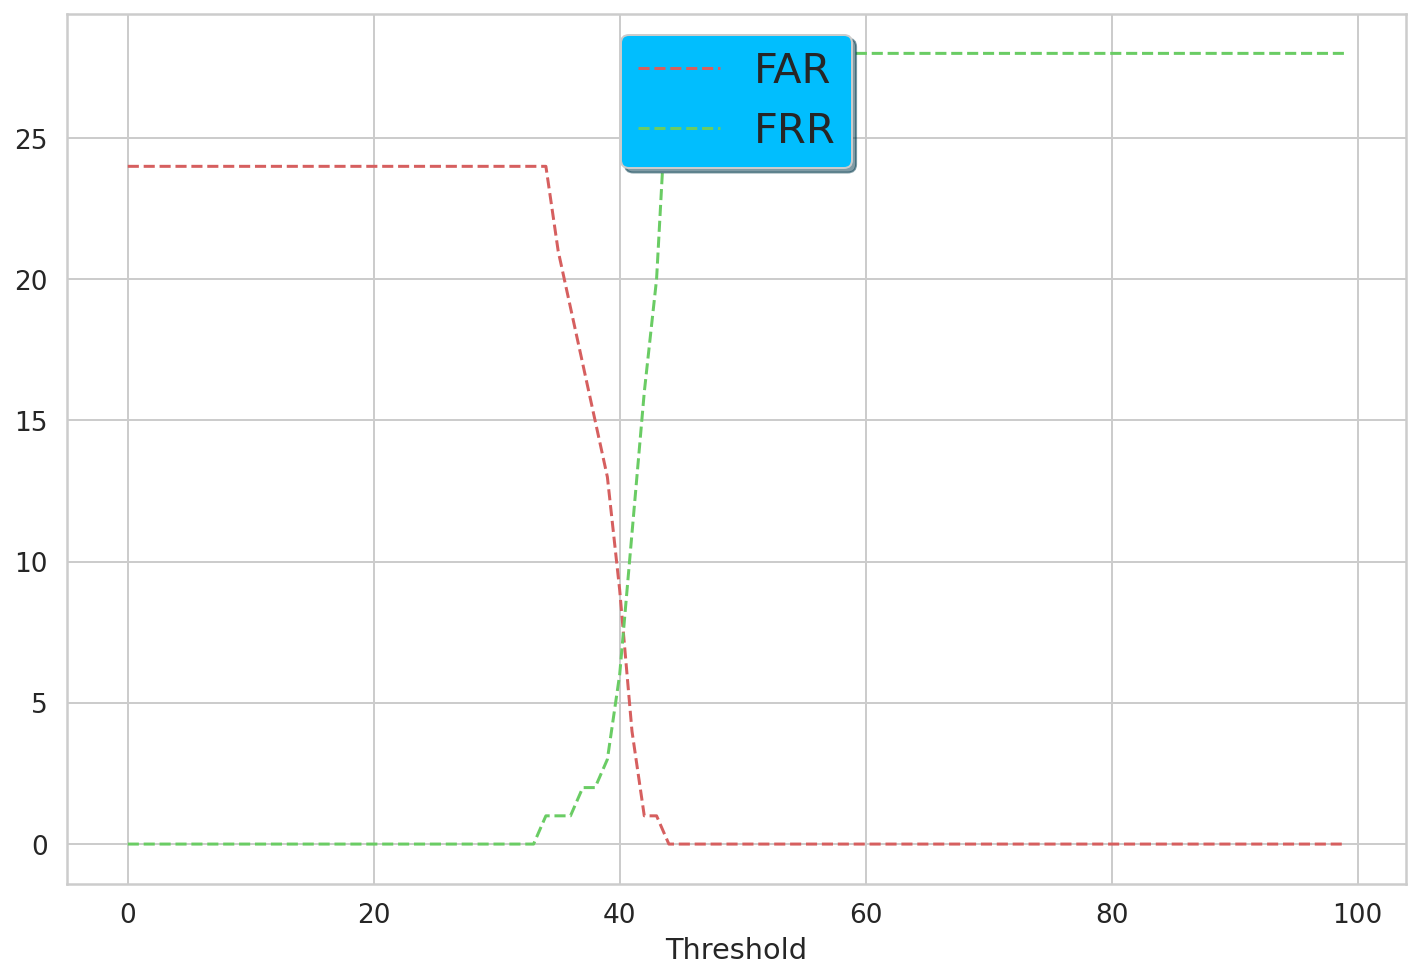

In [ ]:
i = 8
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

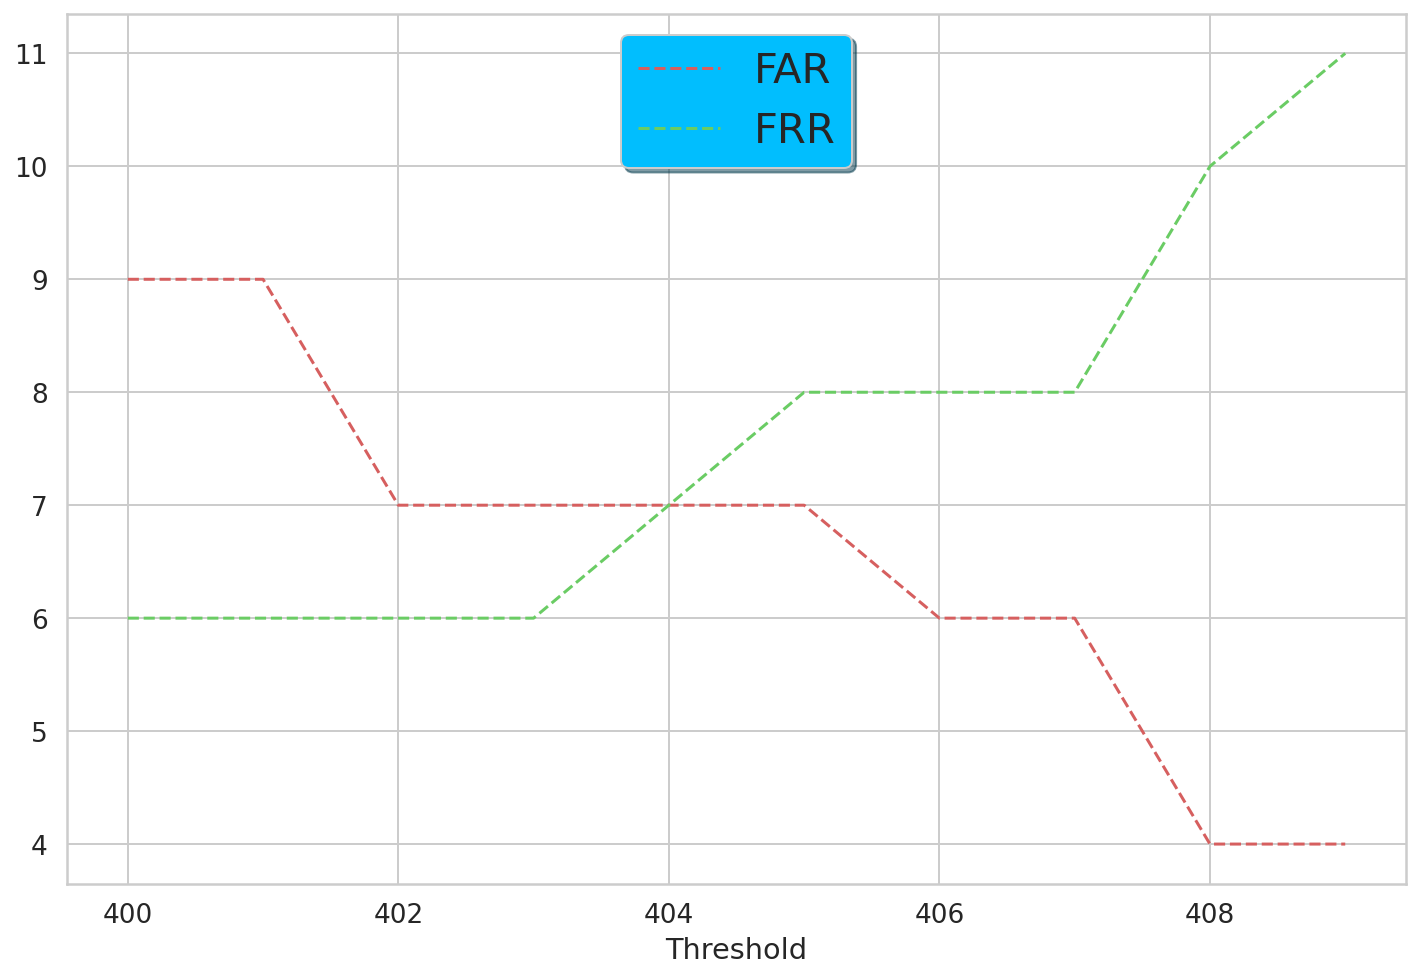

In [ ]:
i = 8
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(400,410,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(400,410,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

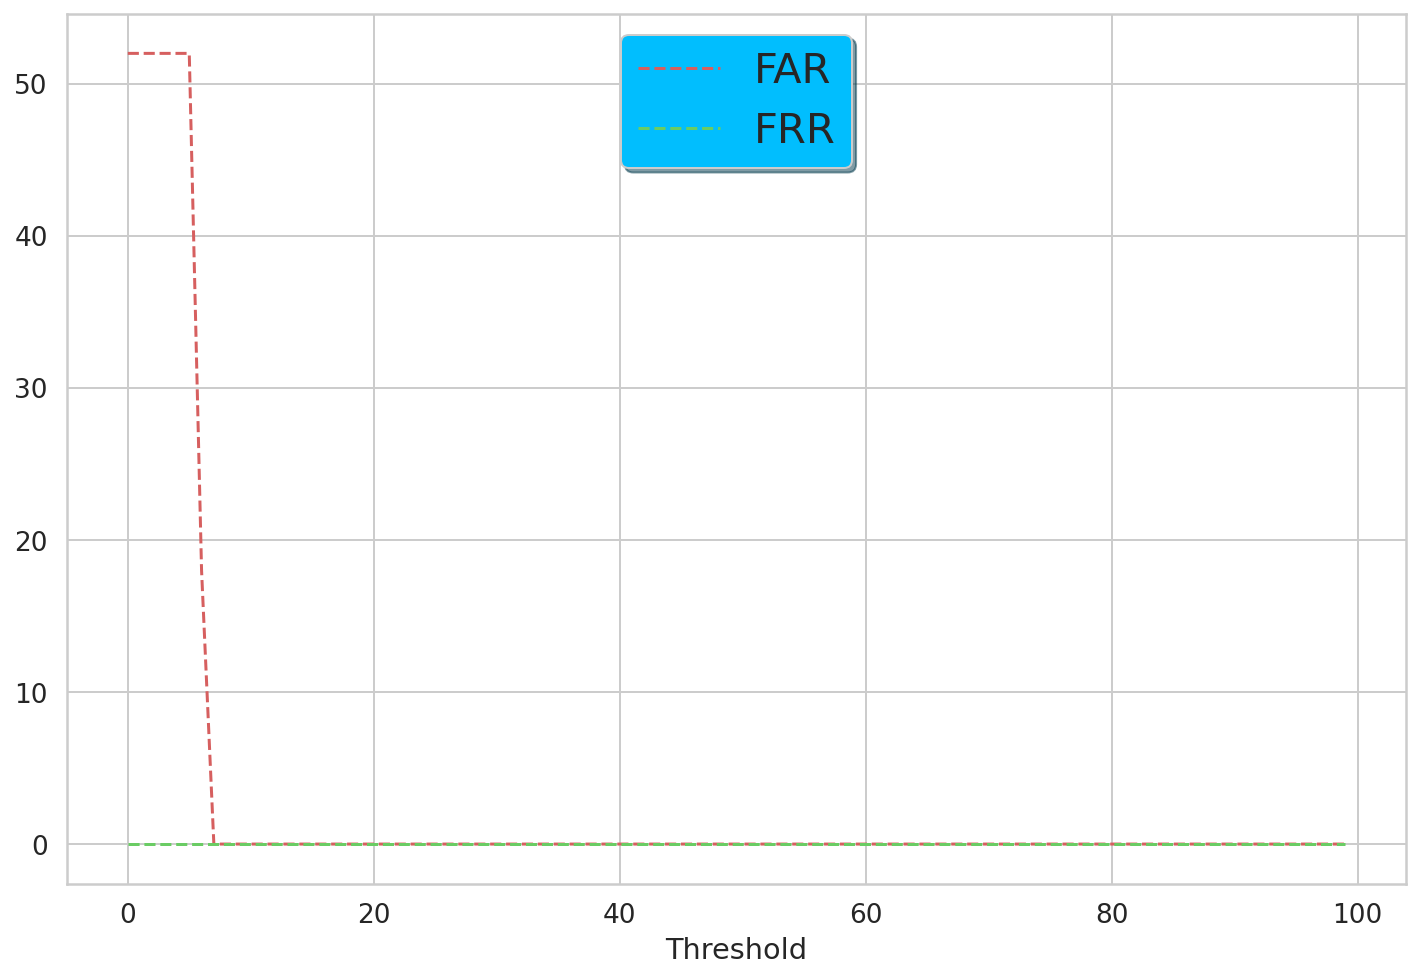

In [ ]:
i = 9
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

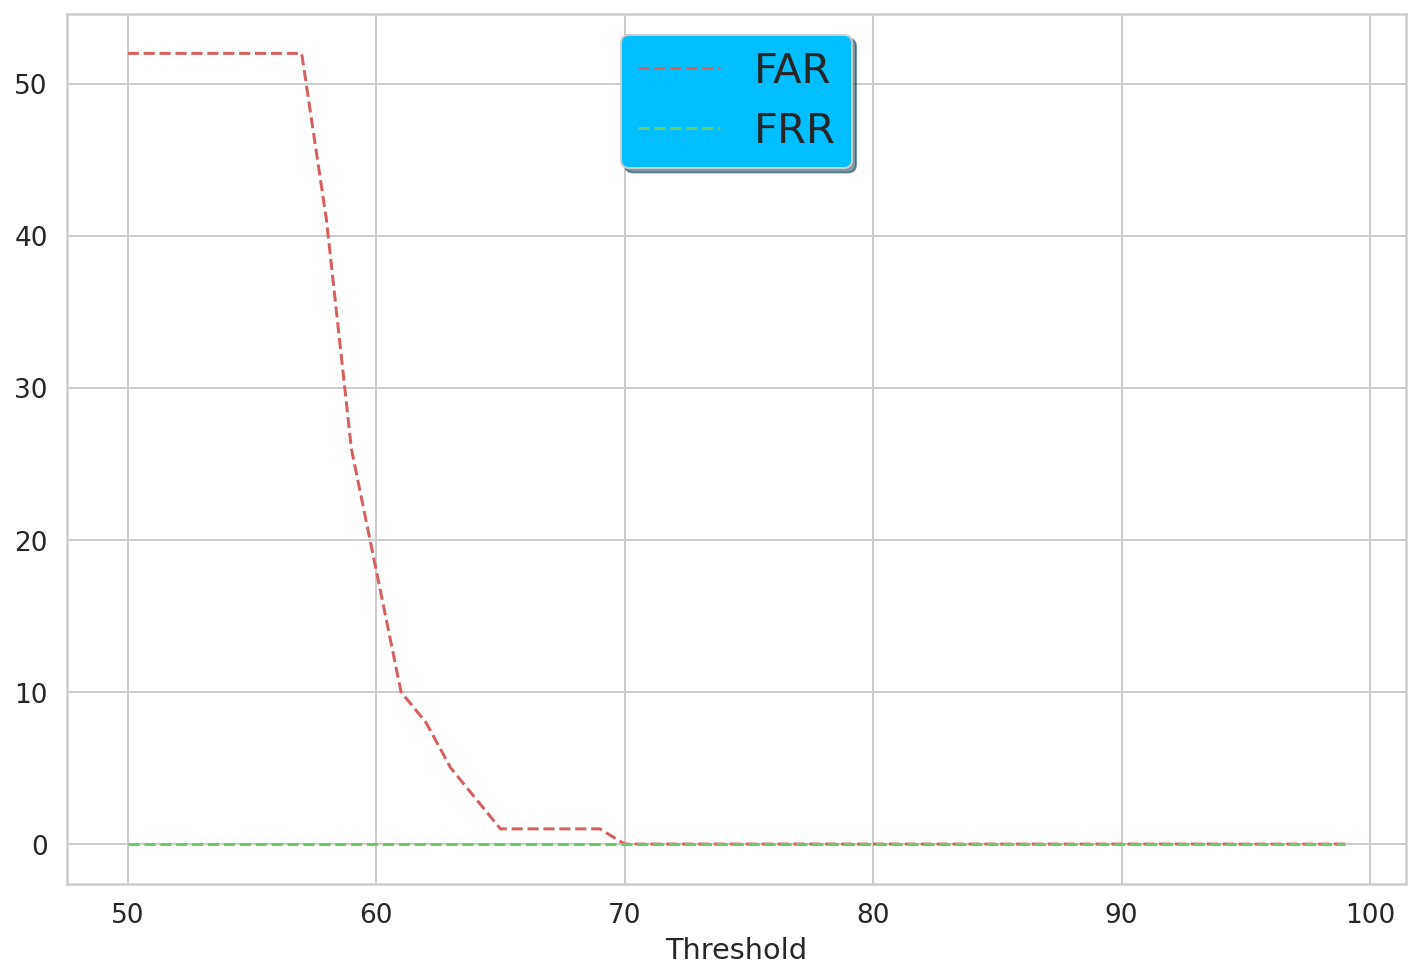

In [ ]:
i = 9
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(50,100,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(50,100,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

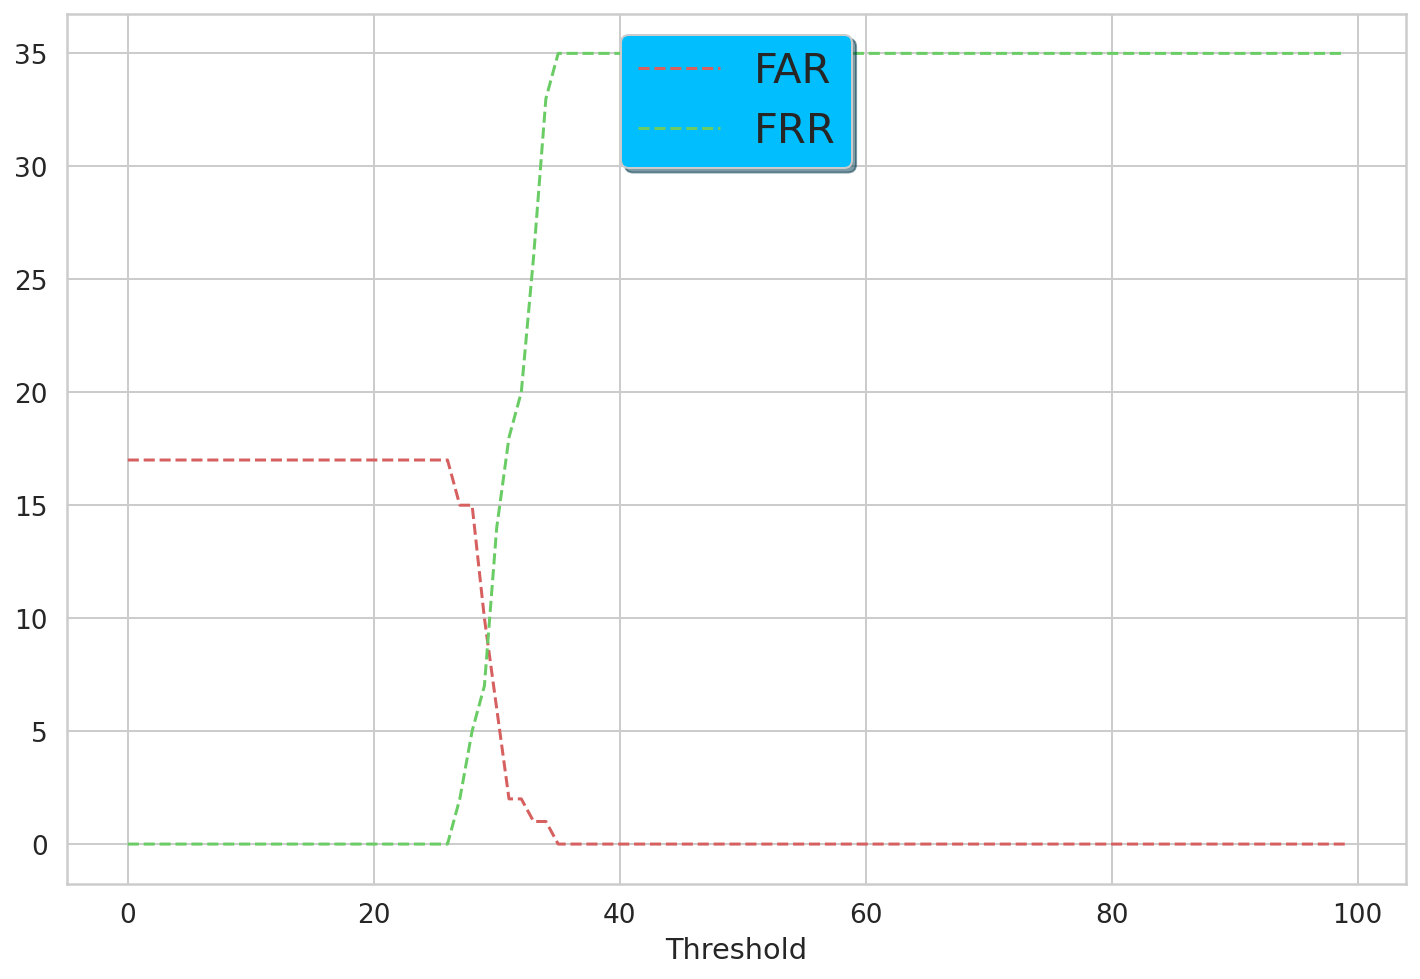

In [ ]:
i = 10
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

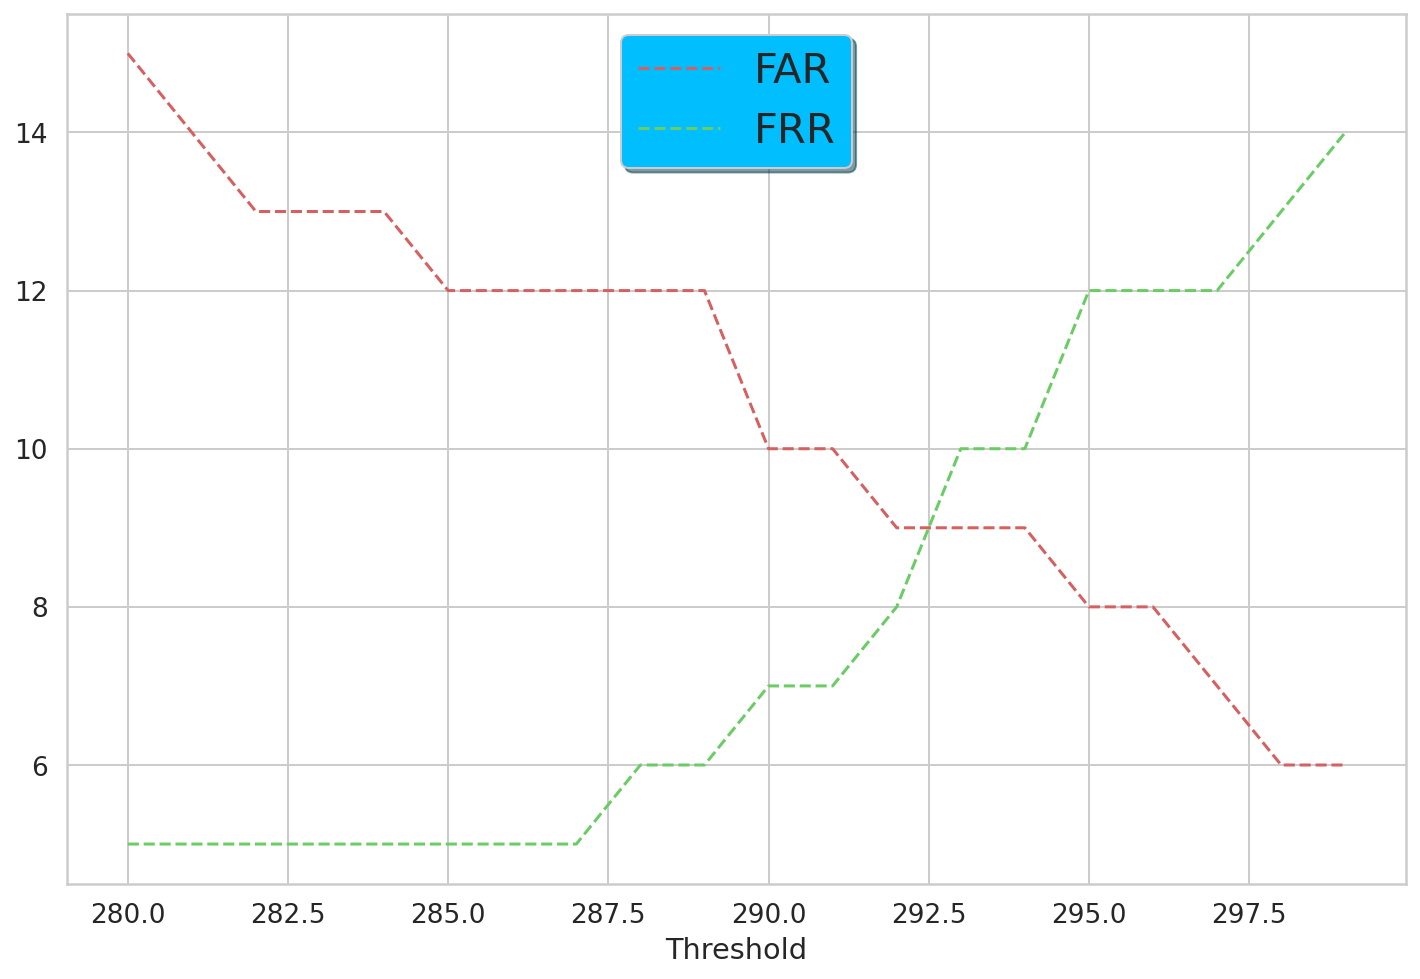

In [ ]:
i = 10
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(280,300,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(280,300,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

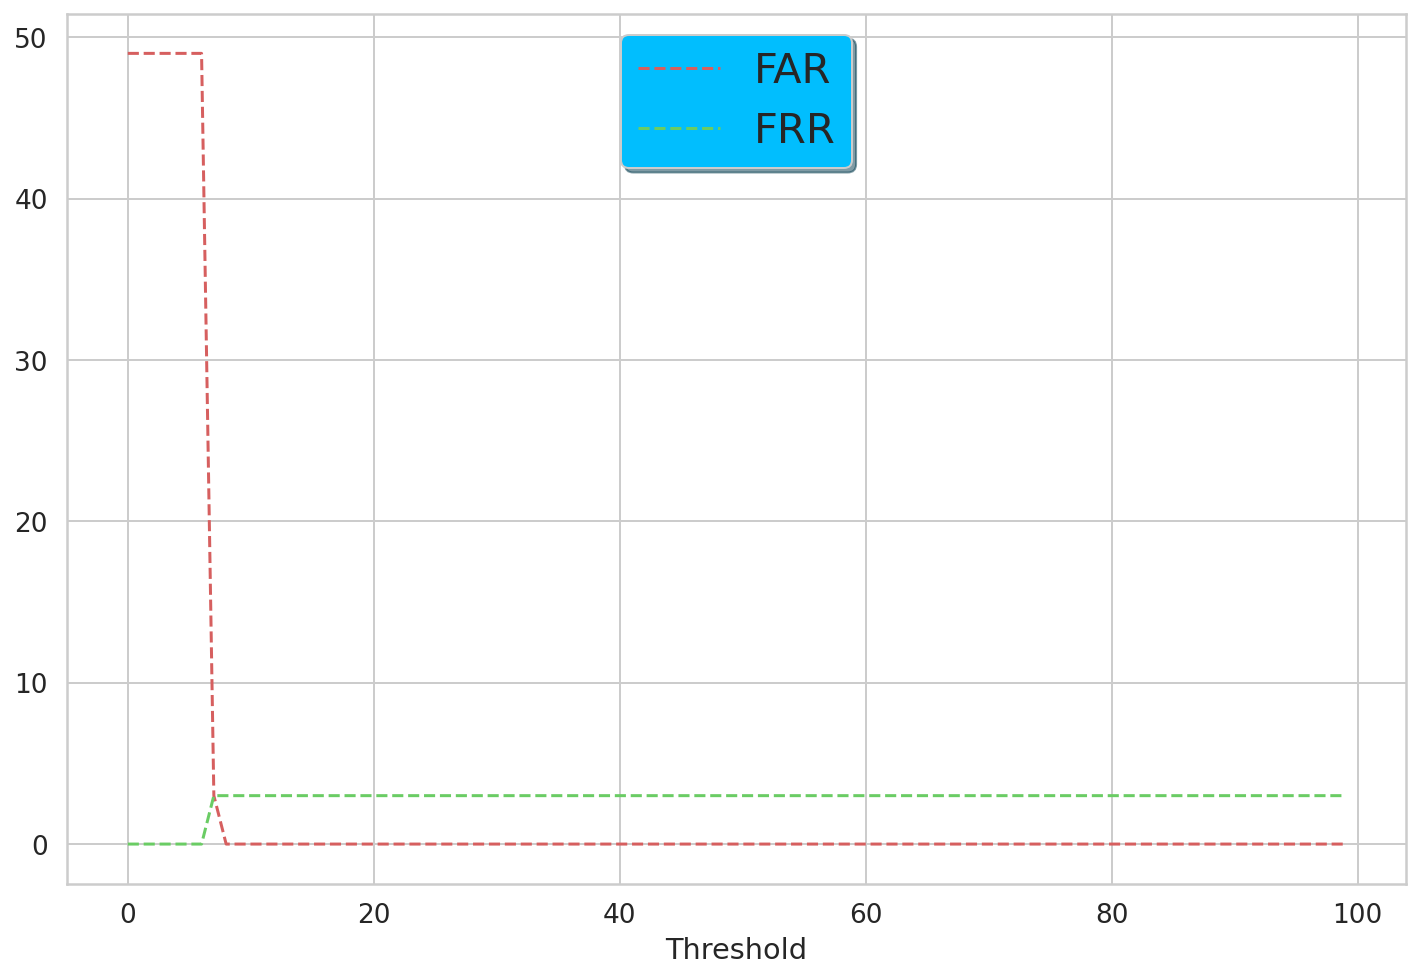

In [ ]:
i =11
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

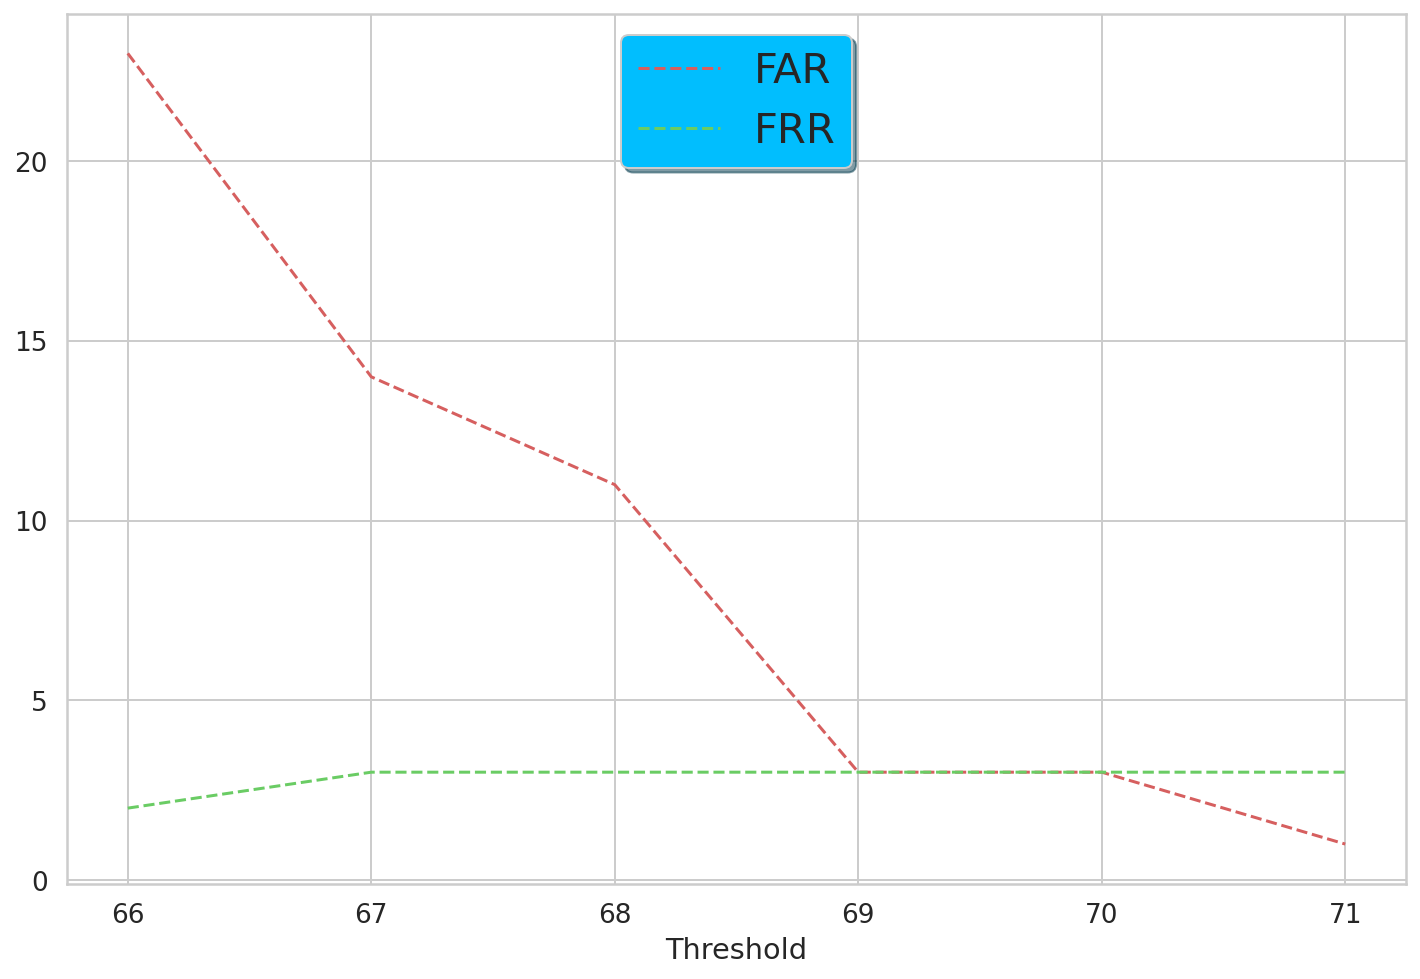

In [ ]:
i = 11
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(66,72,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(66,72,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

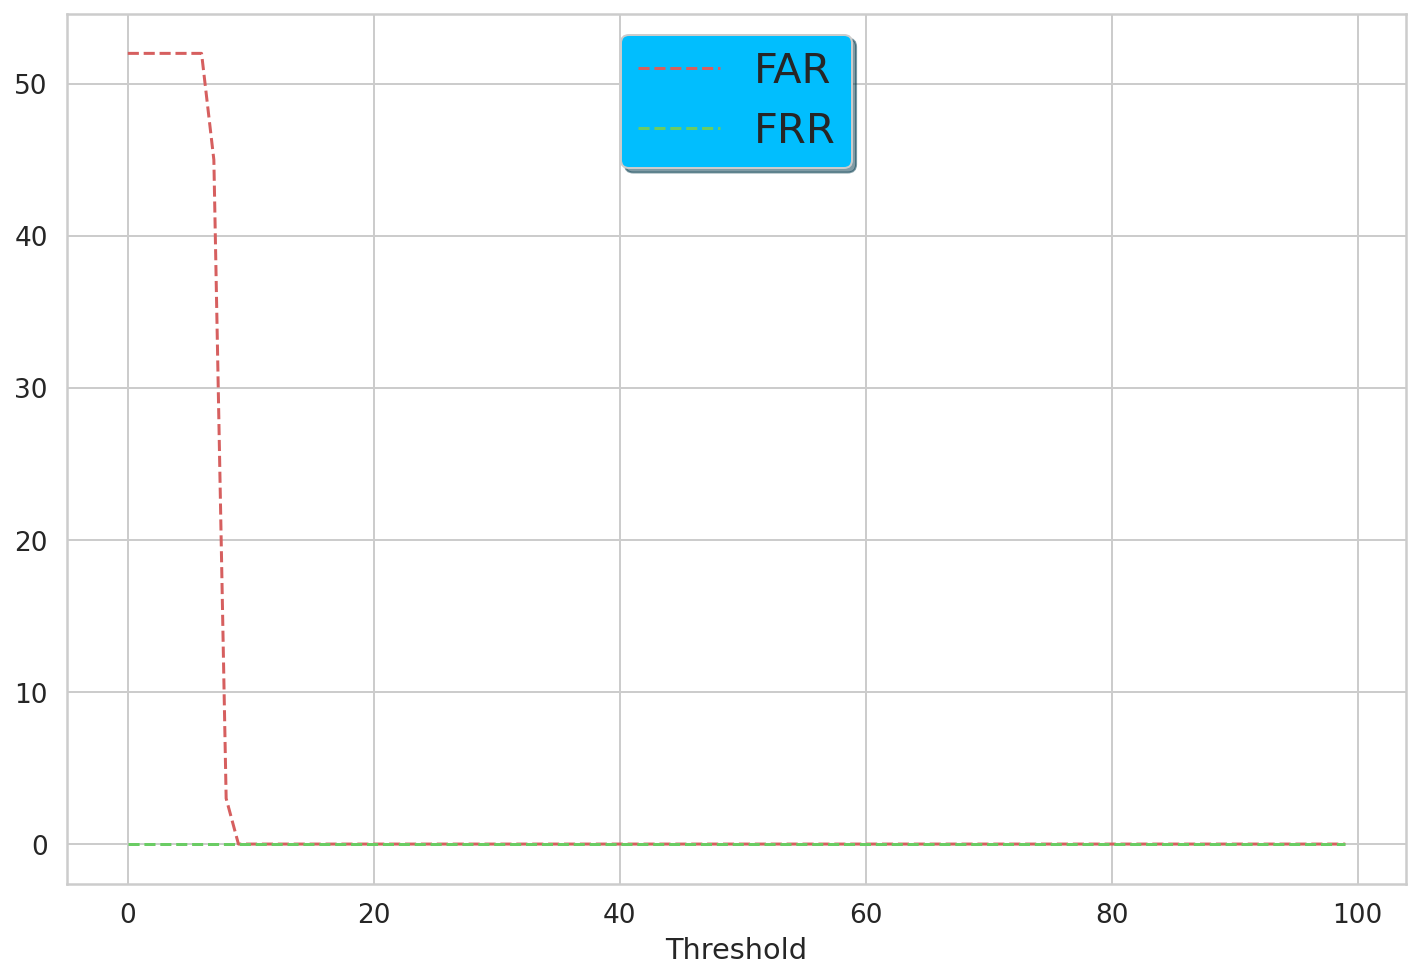

In [ ]:
i = 12
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

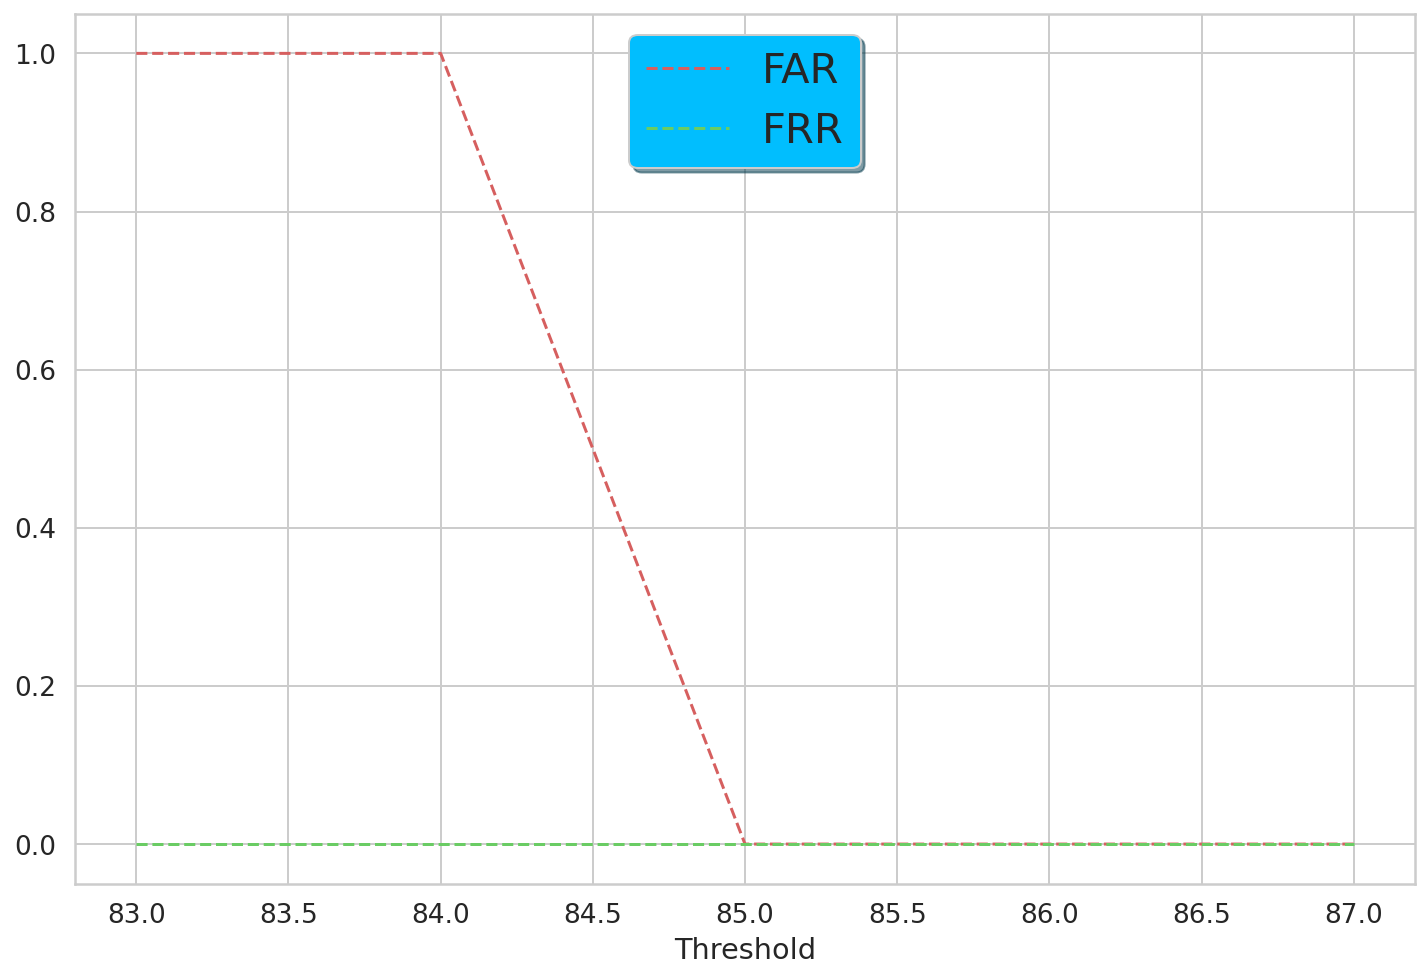

In [ ]:
i = 12
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(83,88,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(83,88,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

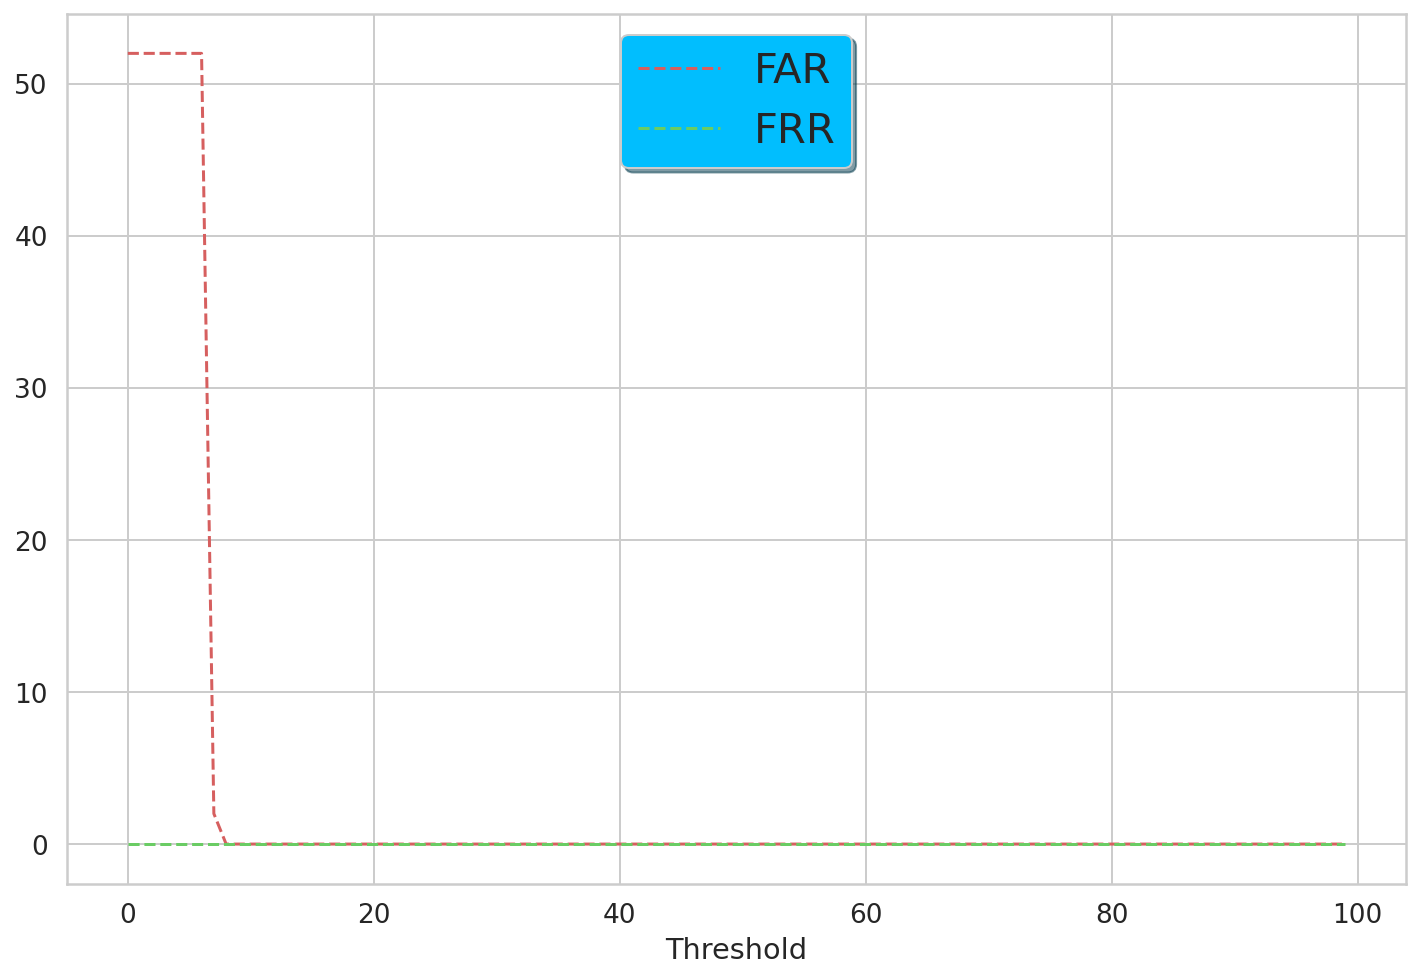

In [ ]:
i = 13
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

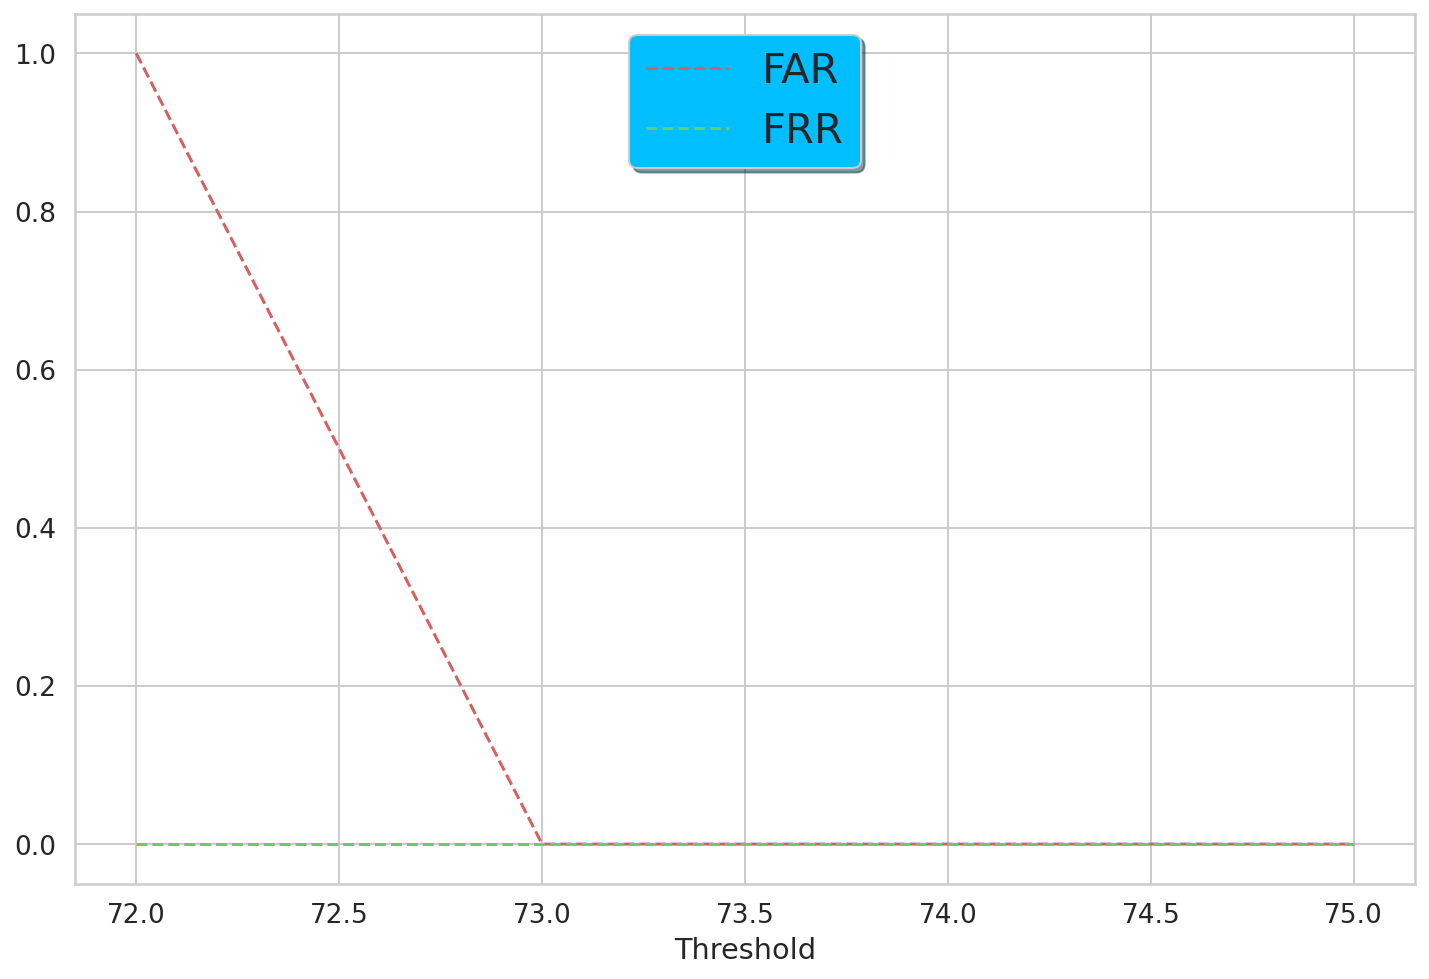

In [ ]:
i = 13
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(72,76,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(72,76,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

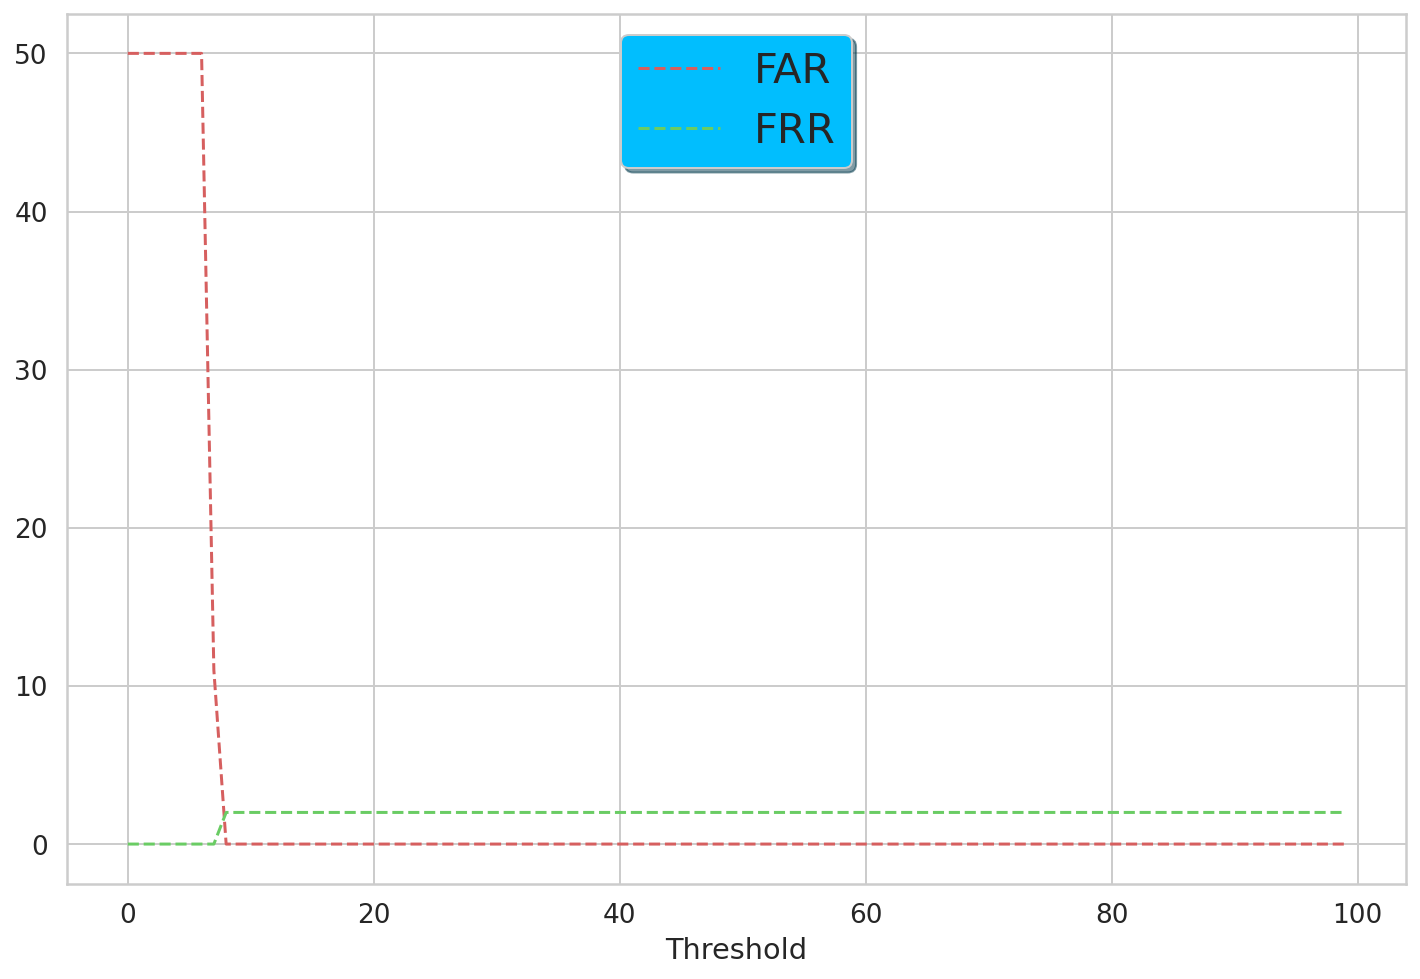

In [ ]:
i = 14
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

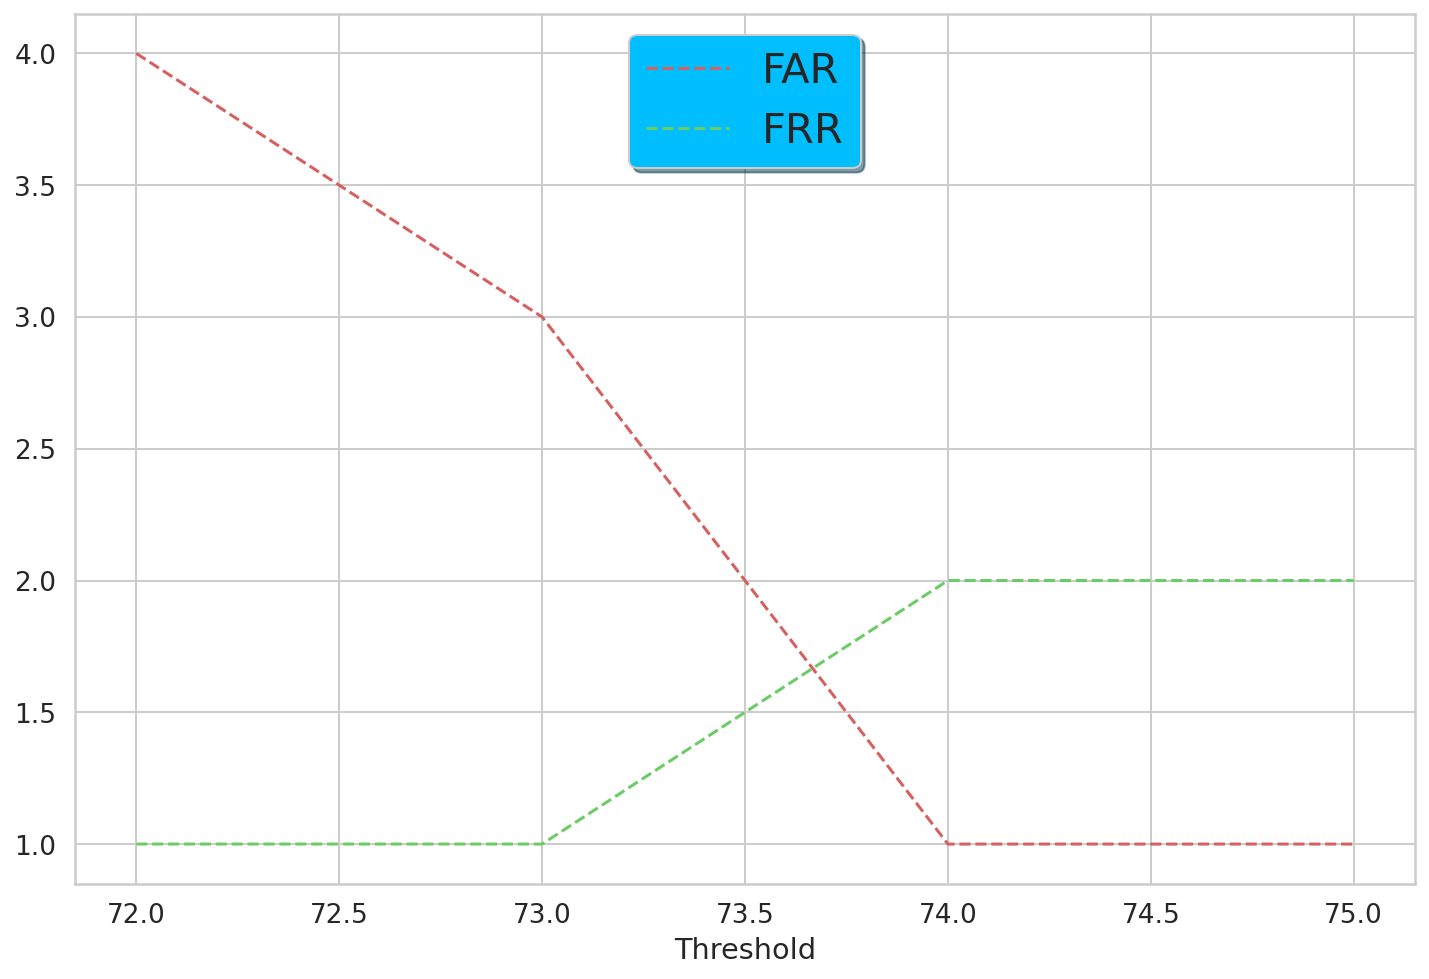

In [ ]:
i = 14
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(72,76,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(72,76,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

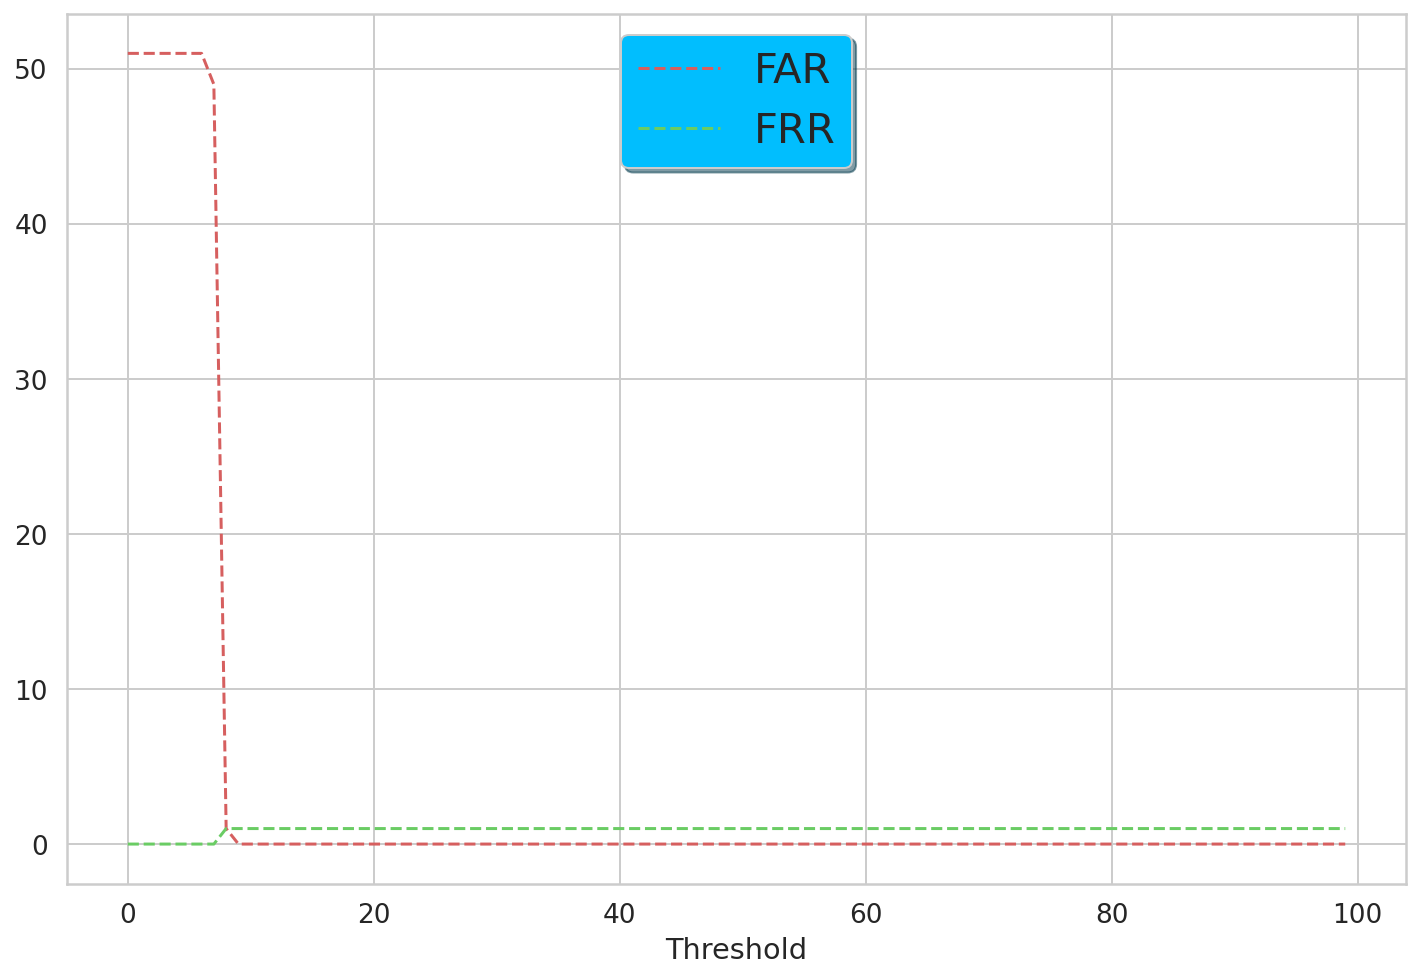

In [ ]:
i = 15
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

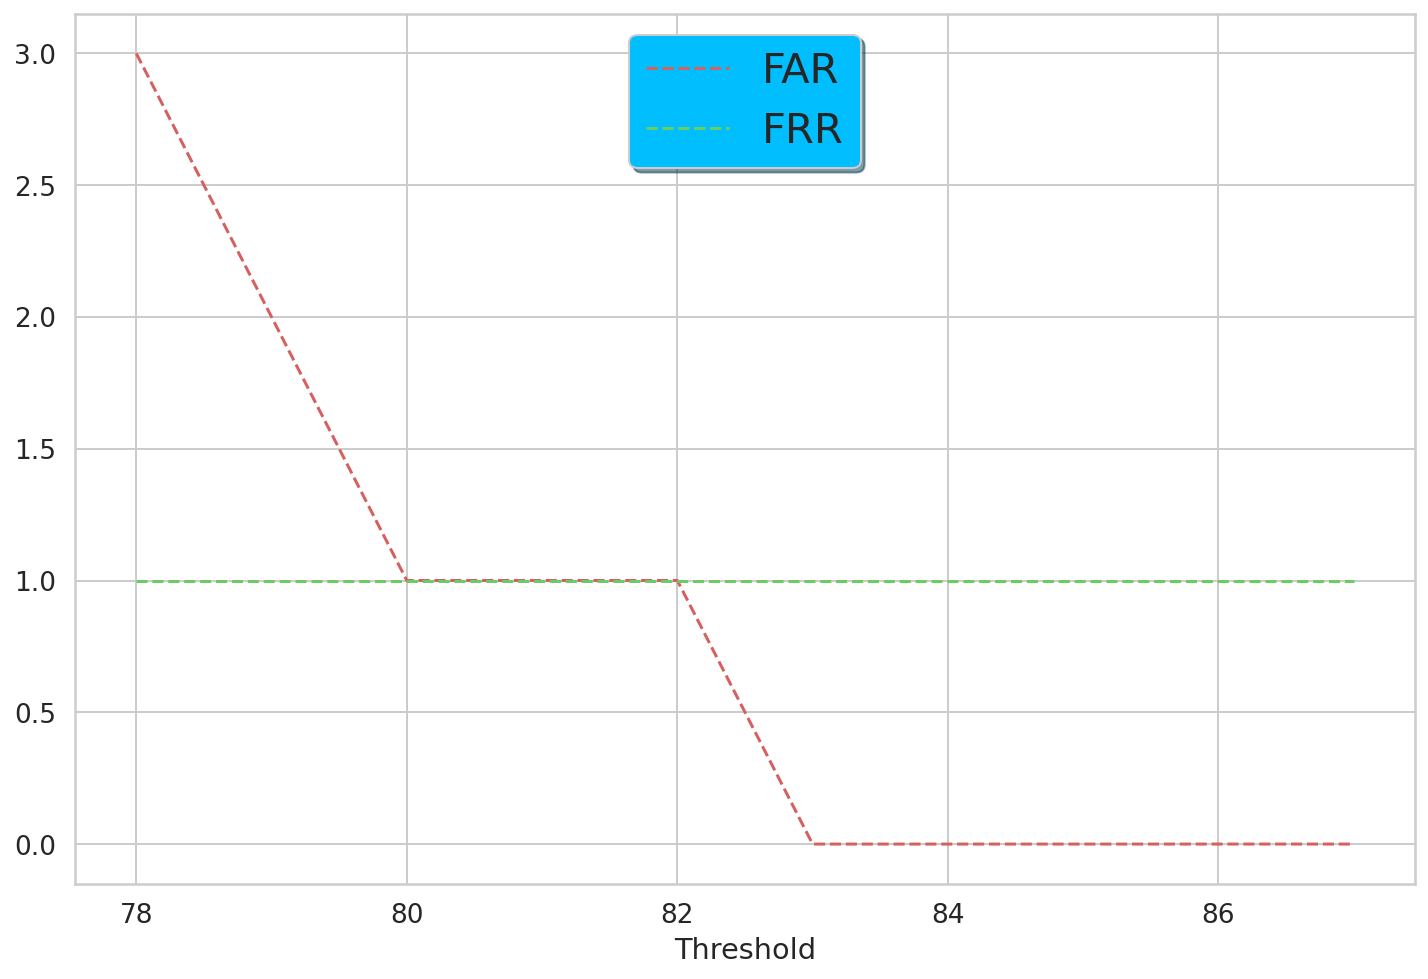

In [ ]:
i = 15
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(78,88,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(78,88,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

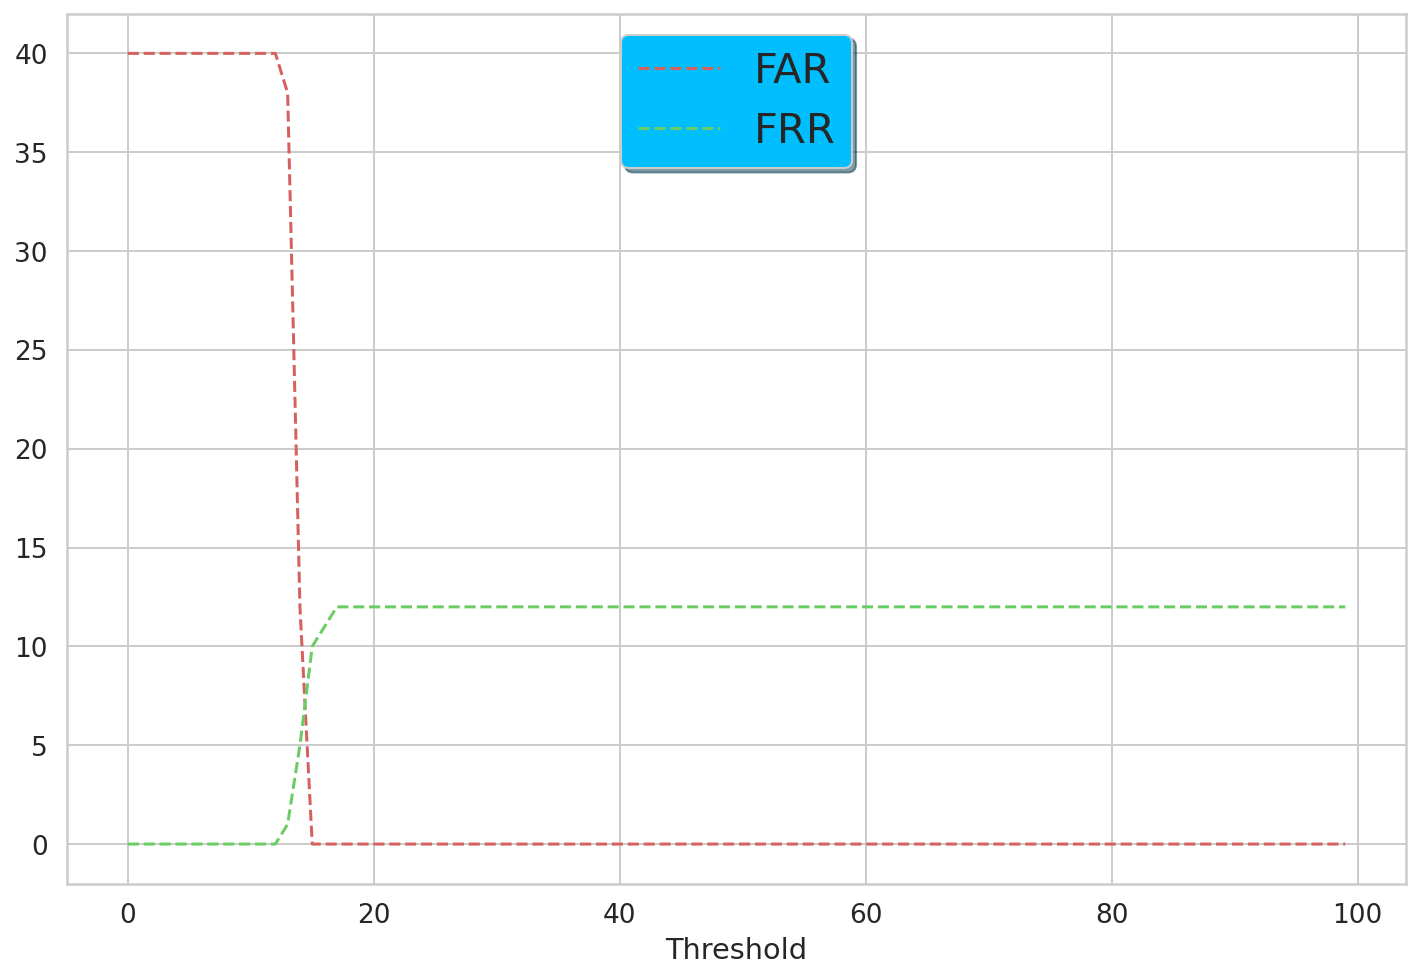

In [ ]:
i = 16
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

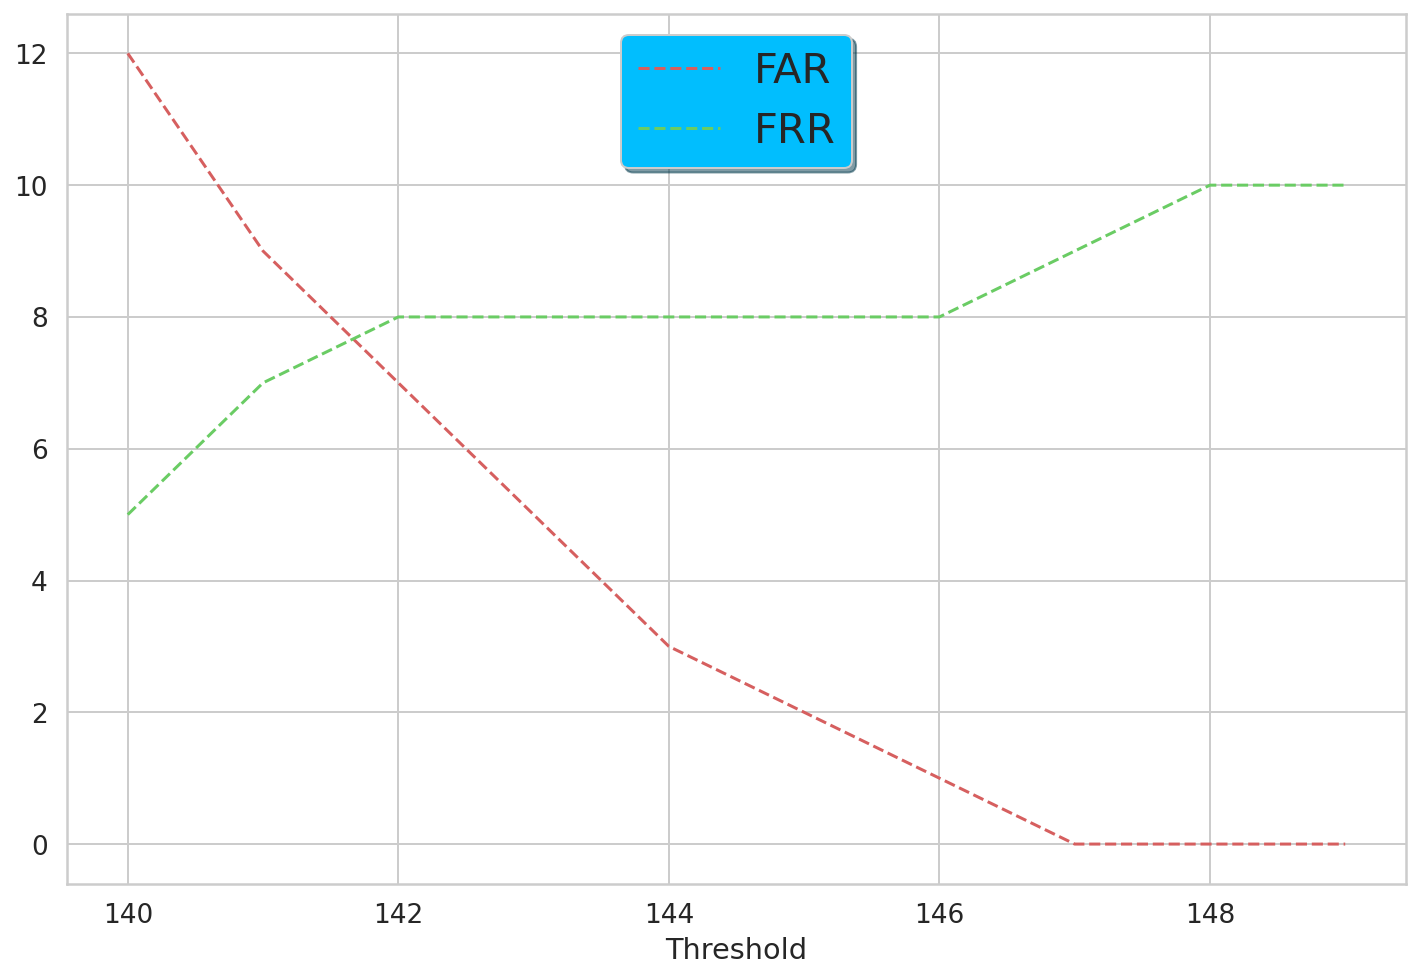

In [ ]:
i = 16
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(140,150,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(140,150,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

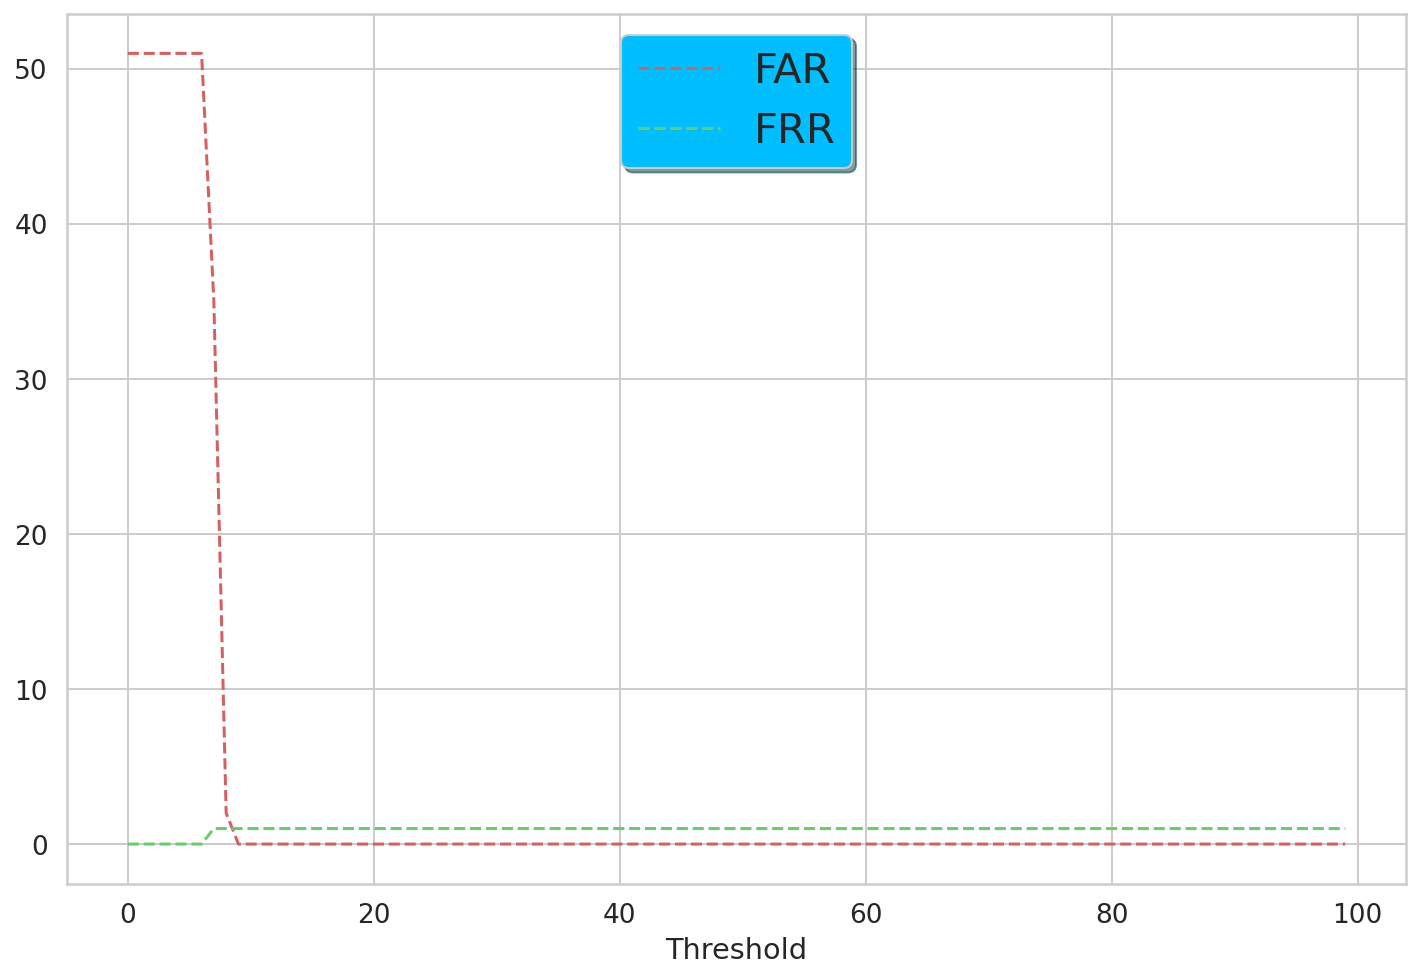

In [ ]:
i = 17
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

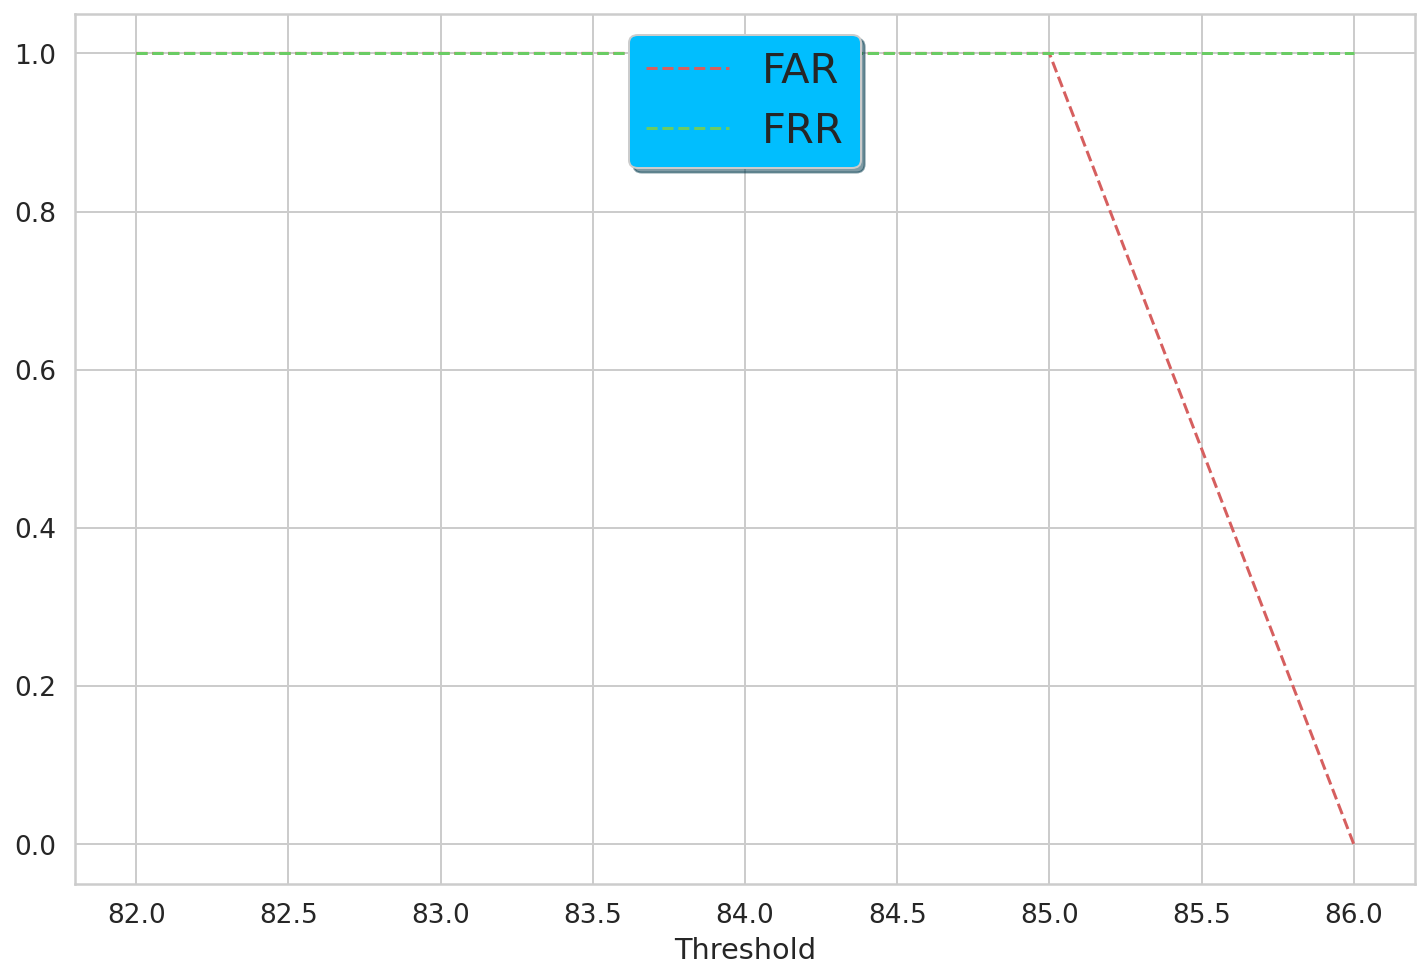

In [ ]:
i = 17
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(82,87,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(82,87,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

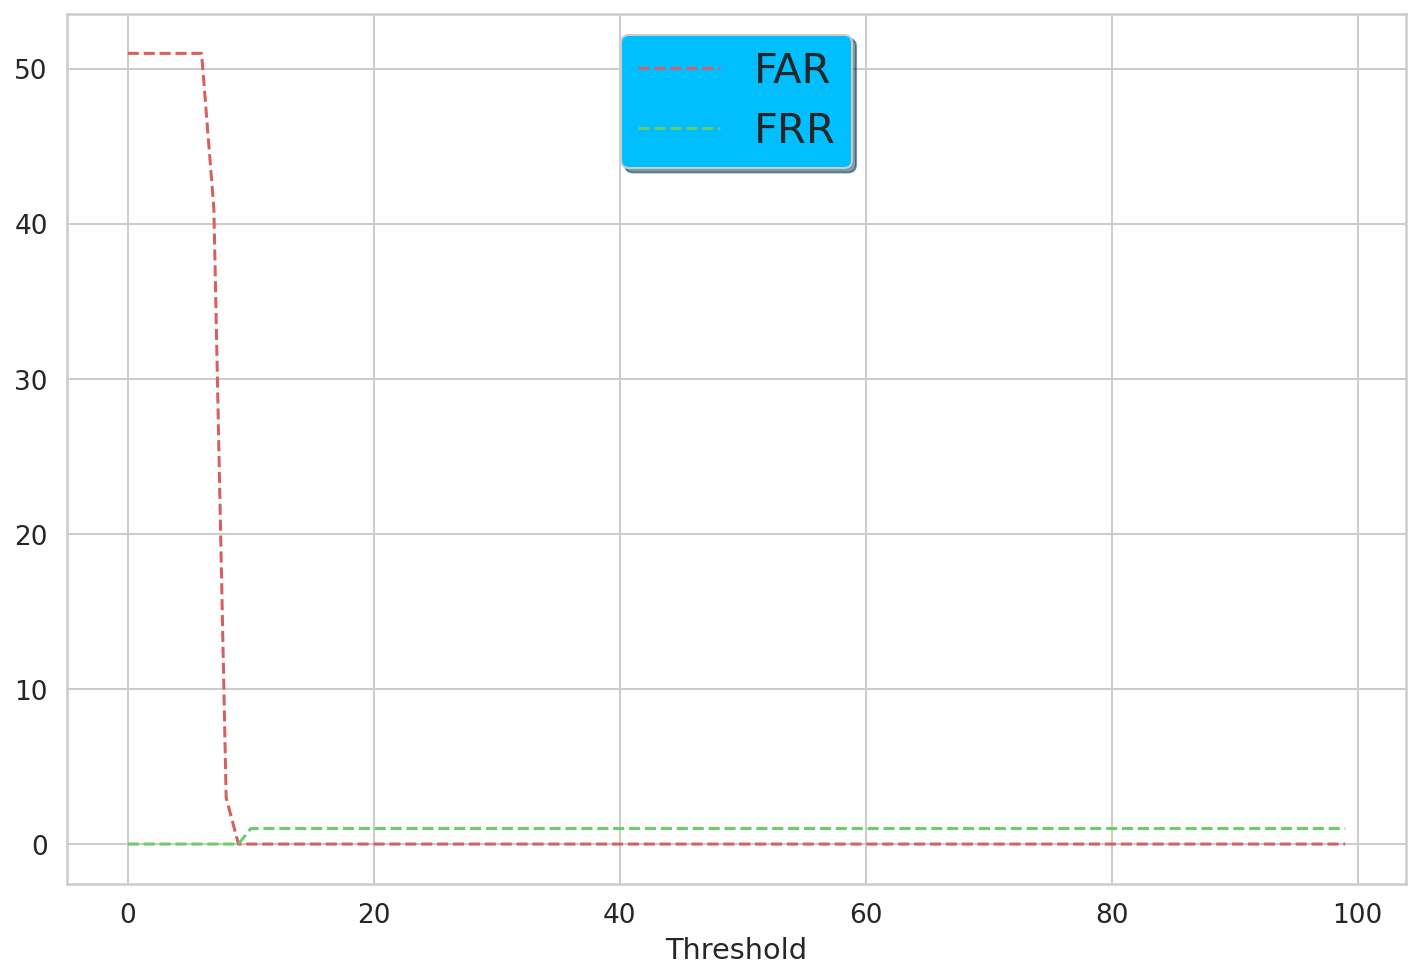

In [ ]:
i = 18
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

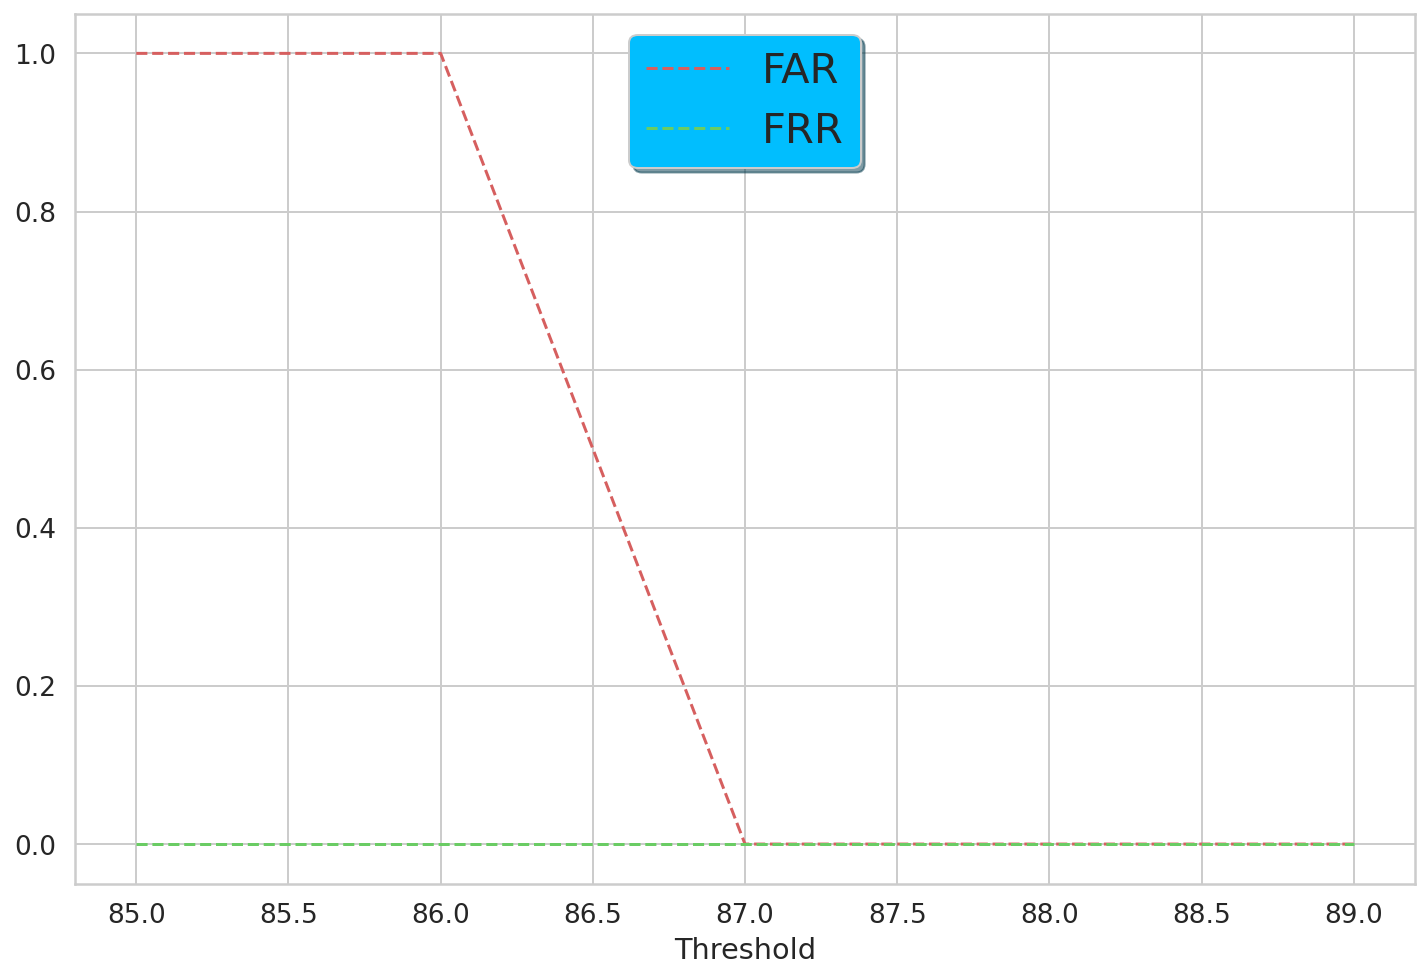

In [ ]:
i = 18
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(85,90,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(85,90,1):
    num = 0

    for s,l in zip(scores,labels):
        if (s*1000)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [ ]:

THRESHOLDS = {}
THRESHOLDS[propaganda_techniques_names[0]] = 0.097
THRESHOLDS[propaganda_techniques_names[1]] = 0.125
THRESHOLDS[propaganda_techniques_names[2]] = 0.086
THRESHOLDS[propaganda_techniques_names[3]] = 0.069
THRESHOLDS[propaganda_techniques_names[4]] = 0.071
THRESHOLDS[propaganda_techniques_names[5]] = 0.120
THRESHOLDS[propaganda_techniques_names[6]] = 0.083
THRESHOLDS[propaganda_techniques_names[7]] = 0.101
THRESHOLDS[propaganda_techniques_names[8]] = 0.404
THRESHOLDS[propaganda_techniques_names[9]] = 0.070
THRESHOLDS[propaganda_techniques_names[10]] = 0.292
THRESHOLDS[propaganda_techniques_names[11]] = 0.069
THRESHOLDS[propaganda_techniques_names[12]] = 0.085
THRESHOLDS[propaganda_techniques_names[13]] = 0.073
THRESHOLDS[propaganda_techniques_names[14]] = 0.073
THRESHOLDS[propaganda_techniques_names[15]] = 0.081
THRESHOLDS[propaganda_techniques_names[16]] = 0.142
THRESHOLDS[propaganda_techniques_names[17]] = 0.083
THRESHOLDS[propaganda_techniques_names[18]] = 0.087


0.5333571428571429


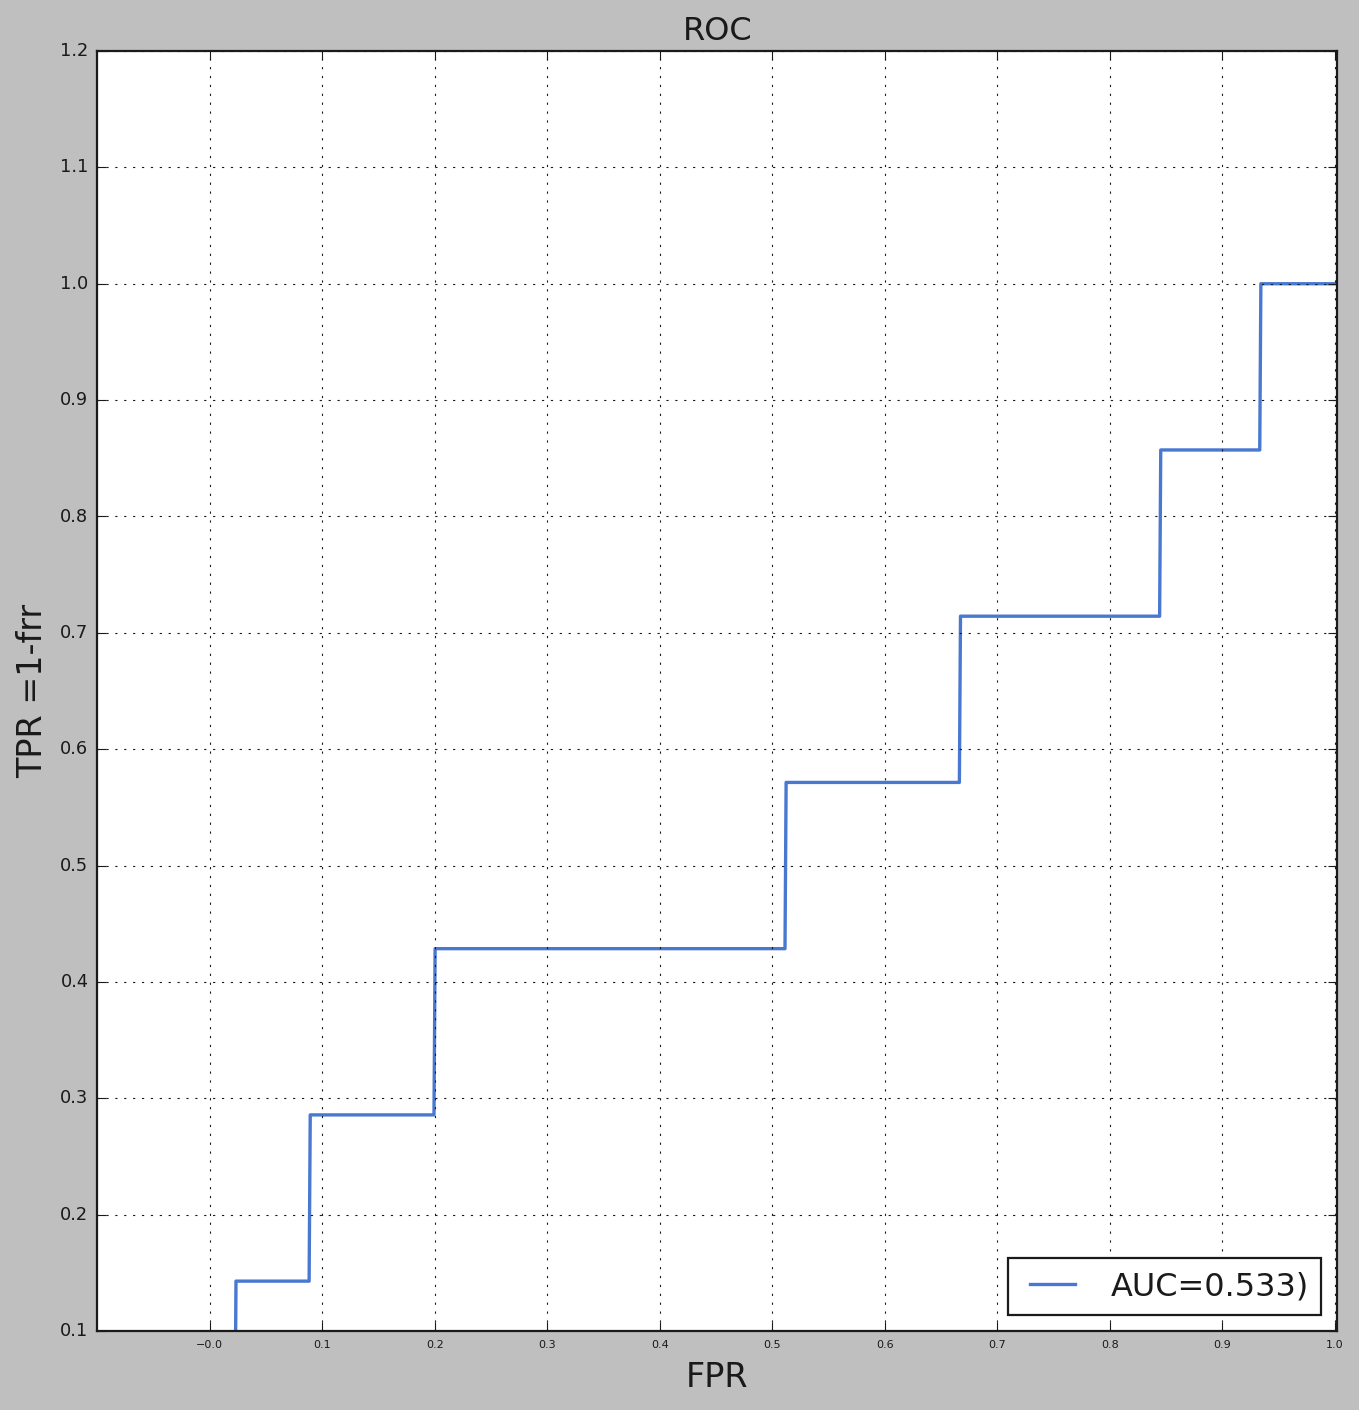

0.7142857142857143


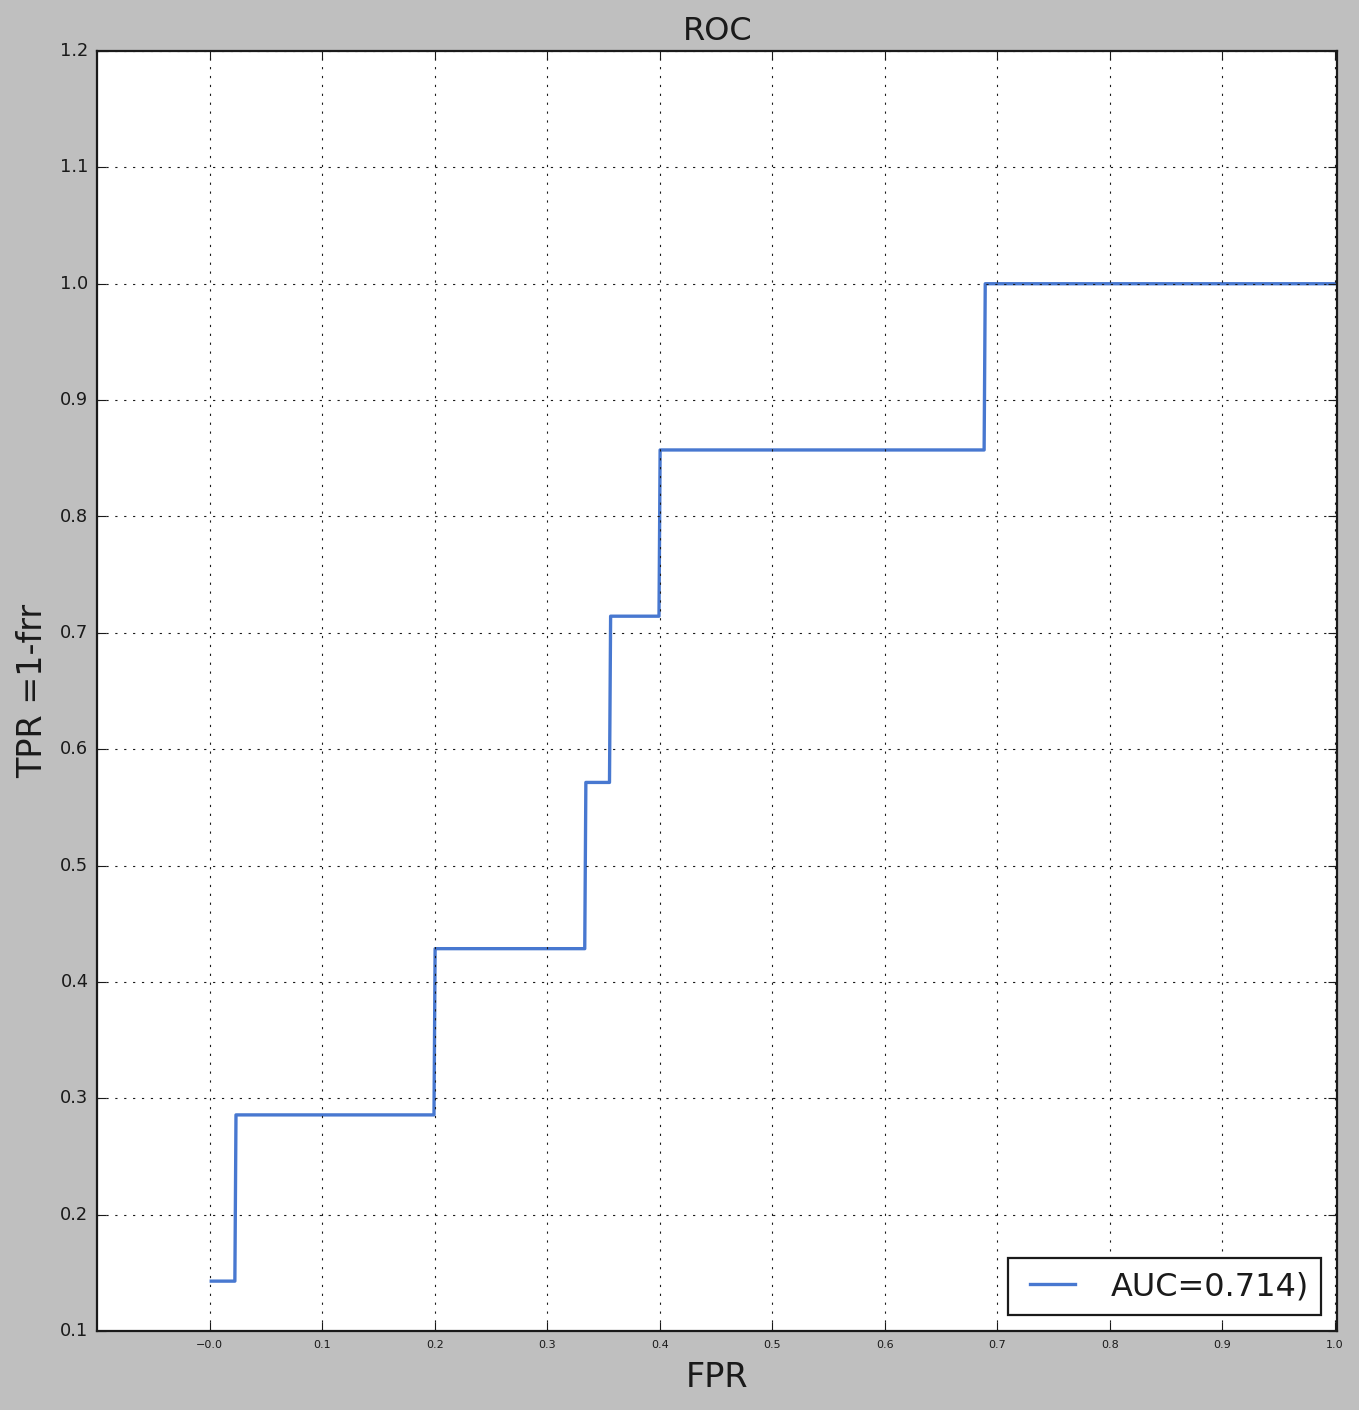

0.8235


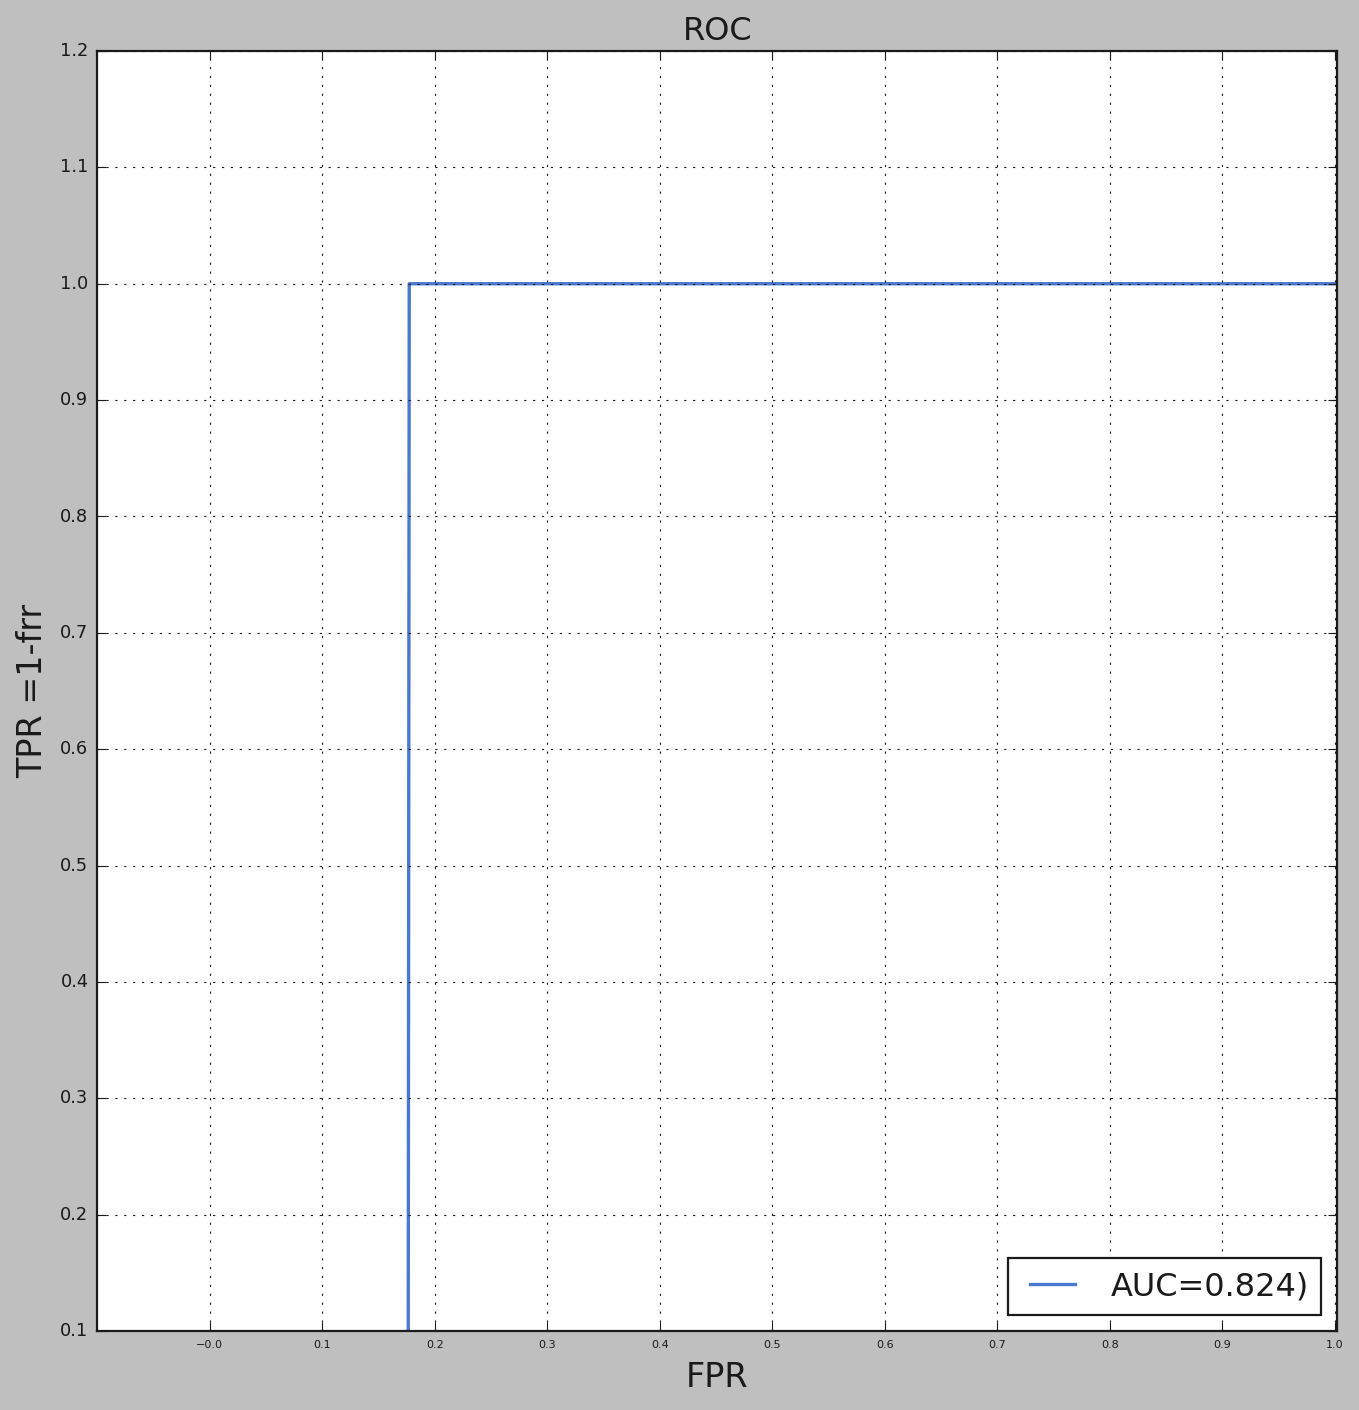

0.9804999999999999


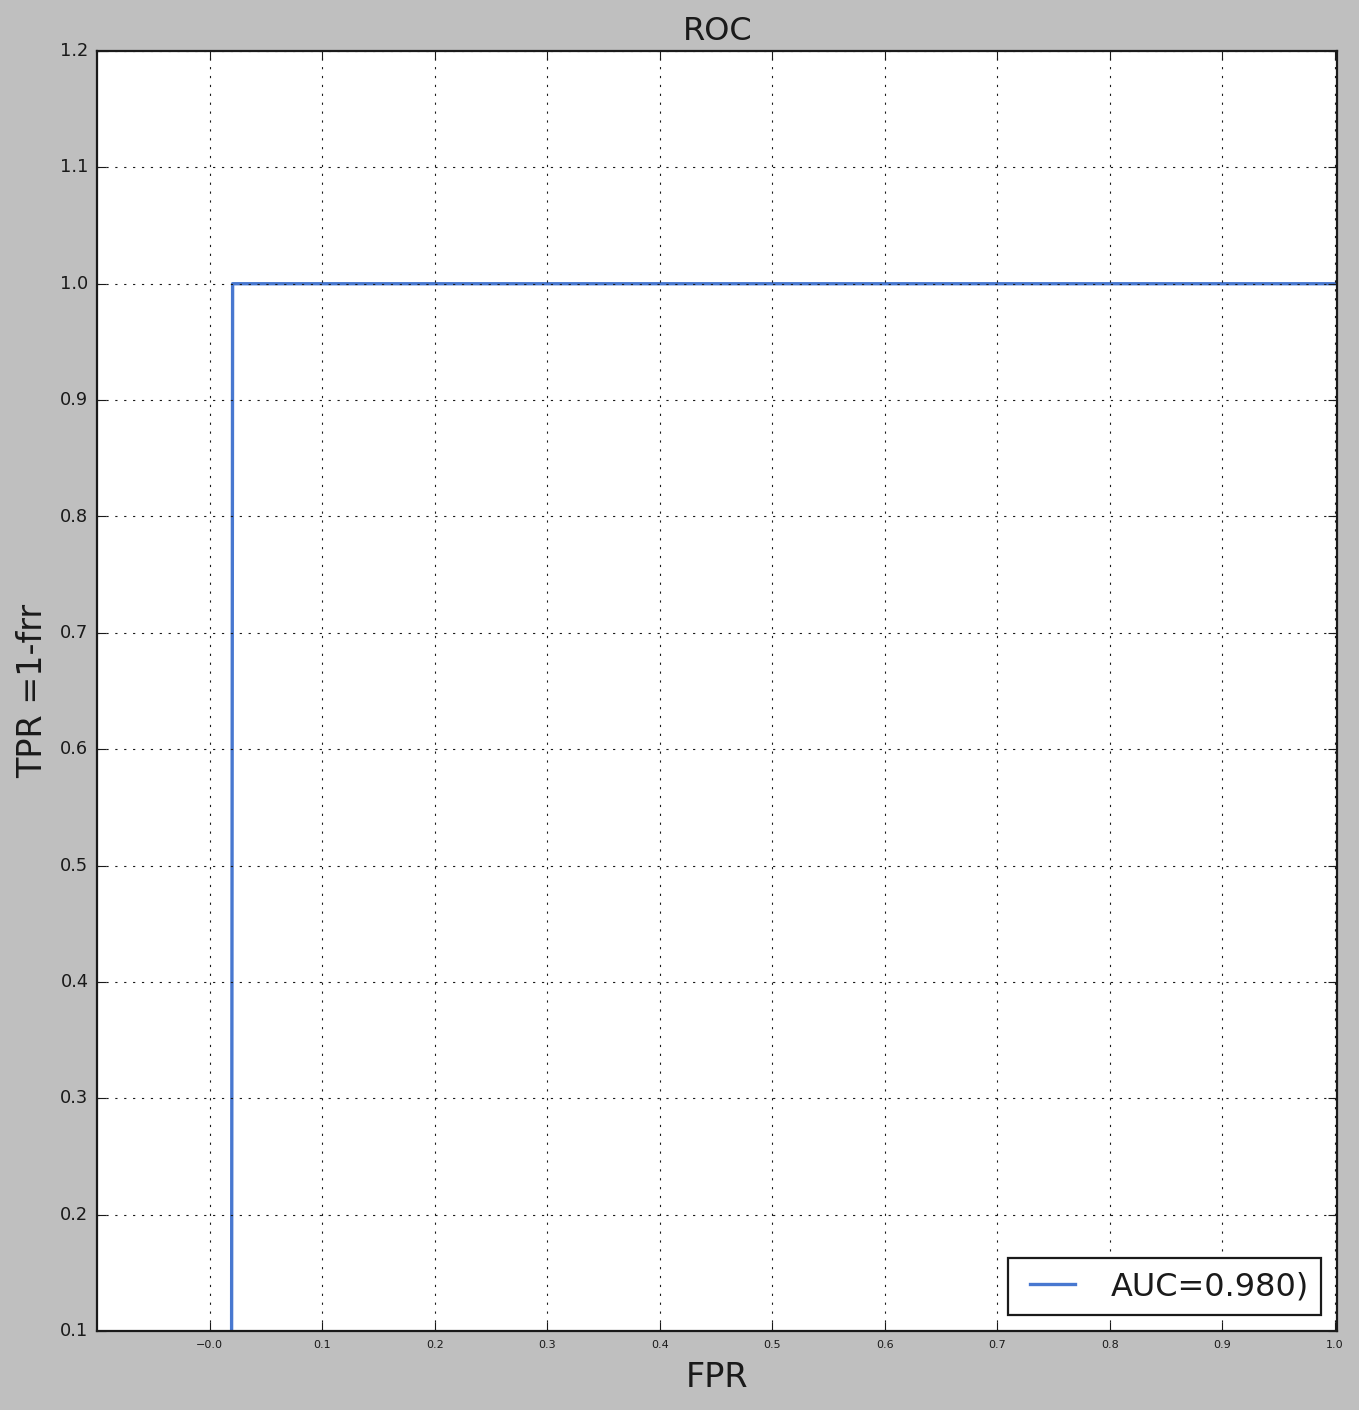

0.05849999999999994


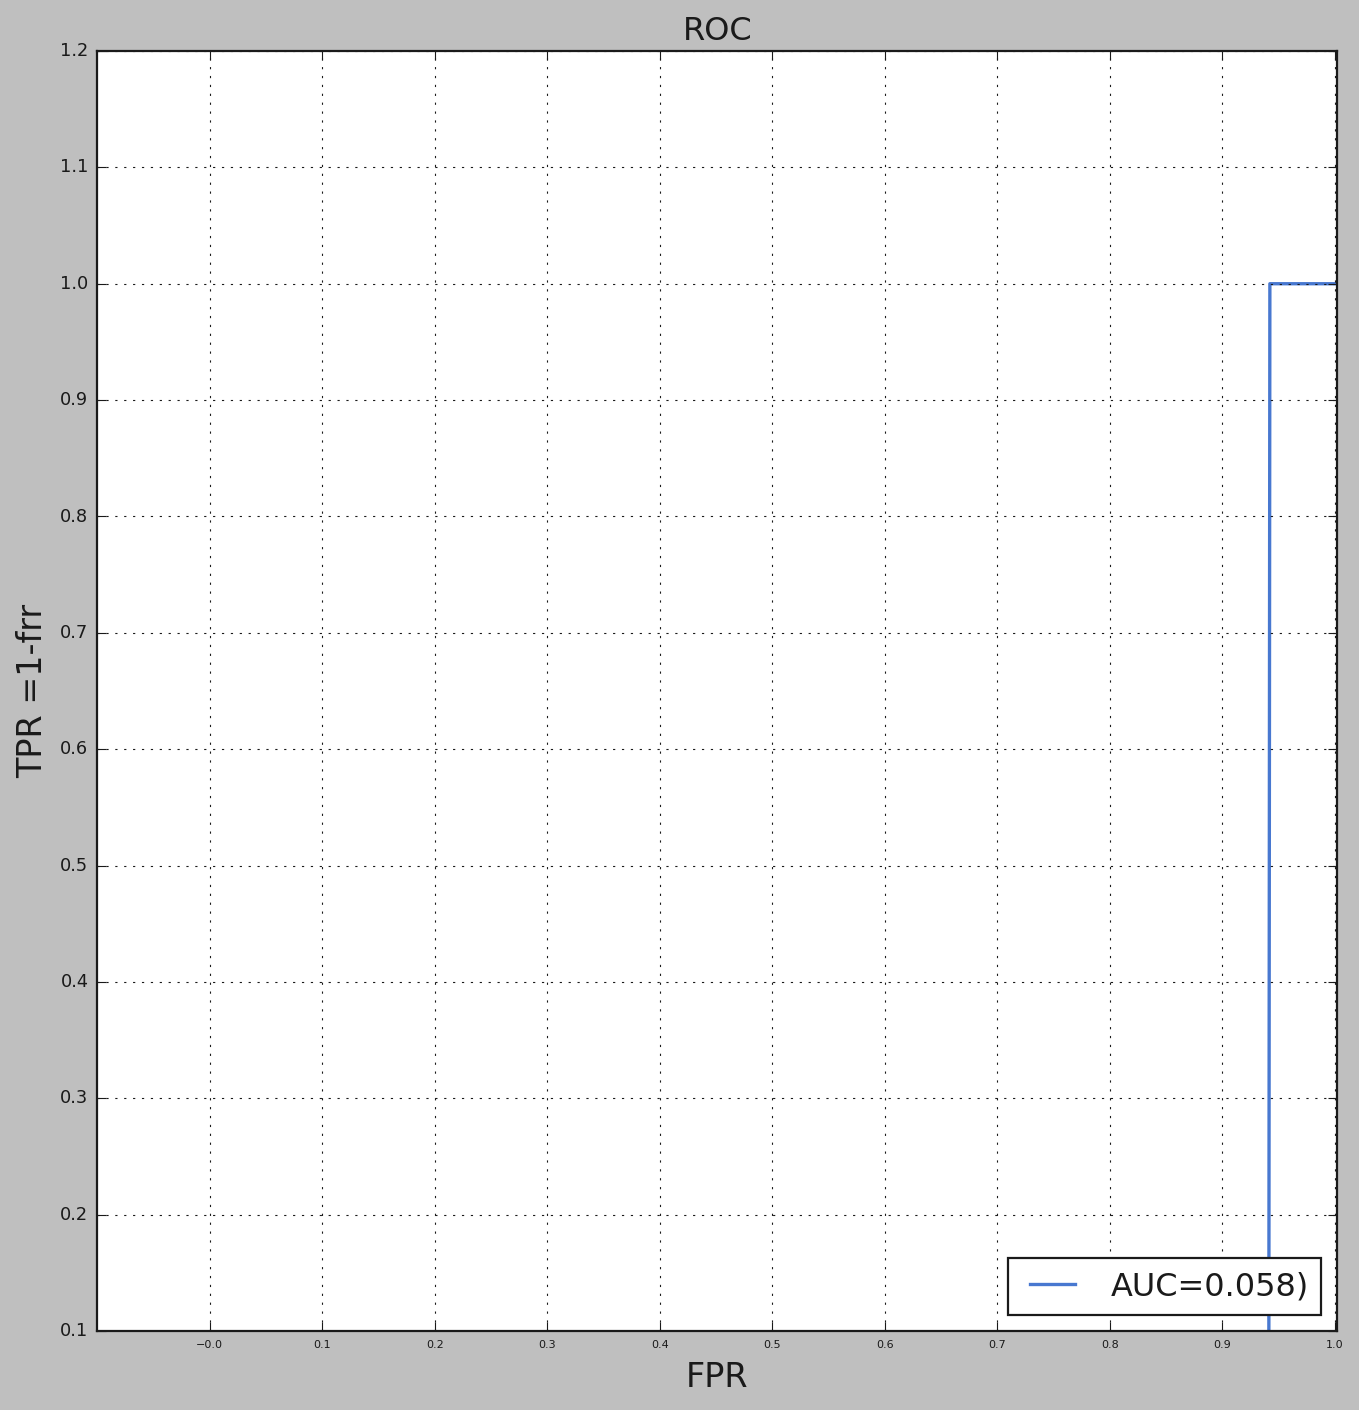

0.53325


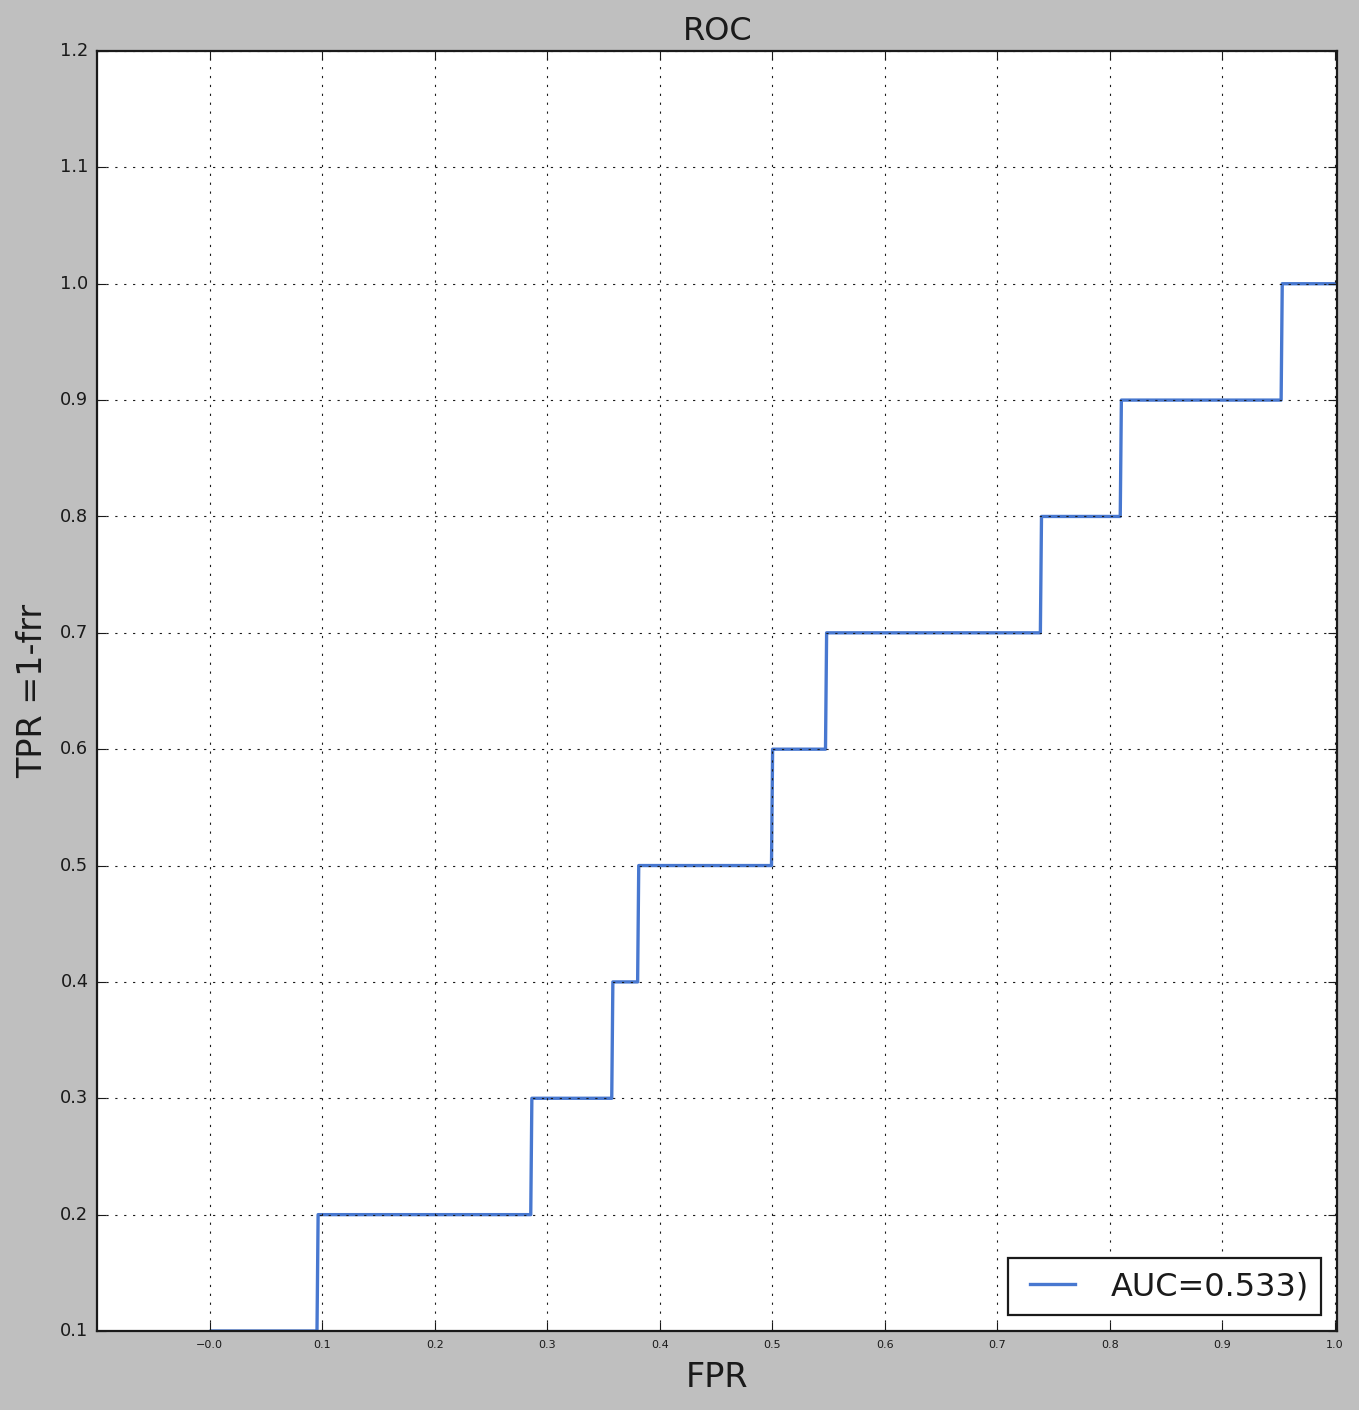

0.4705


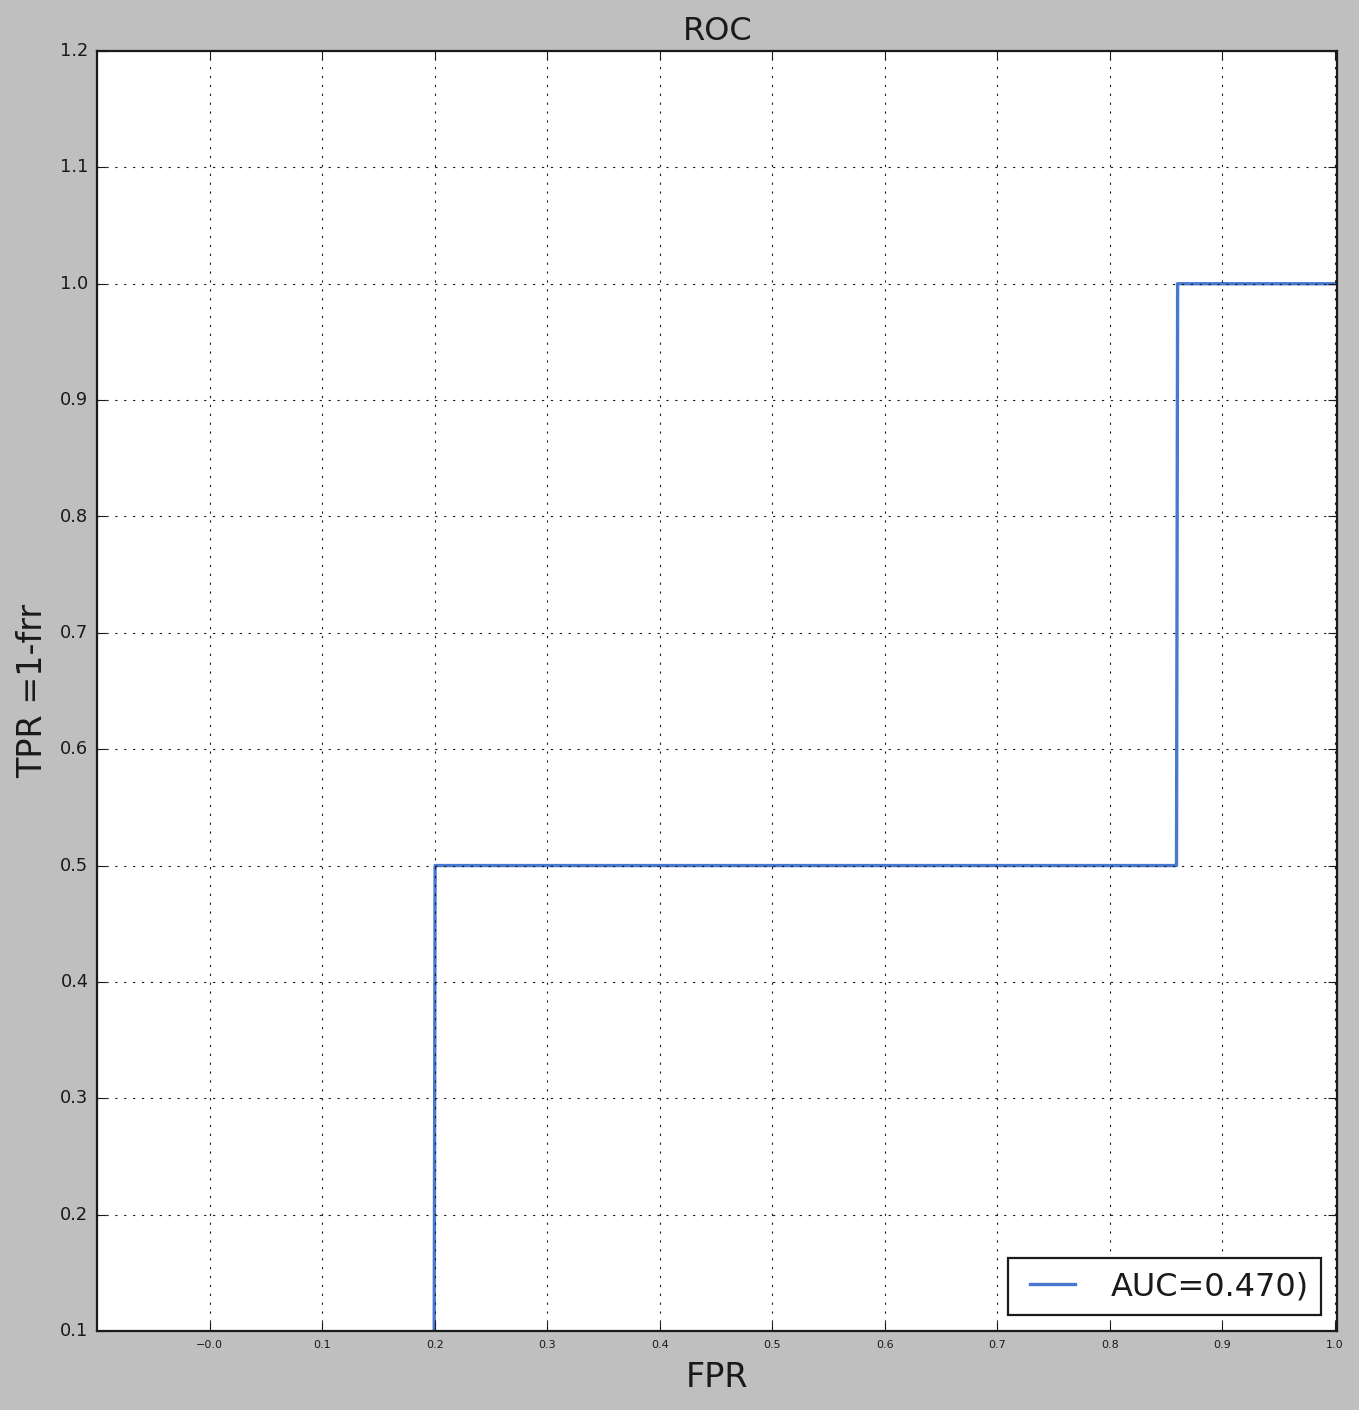

0.5299999999999999


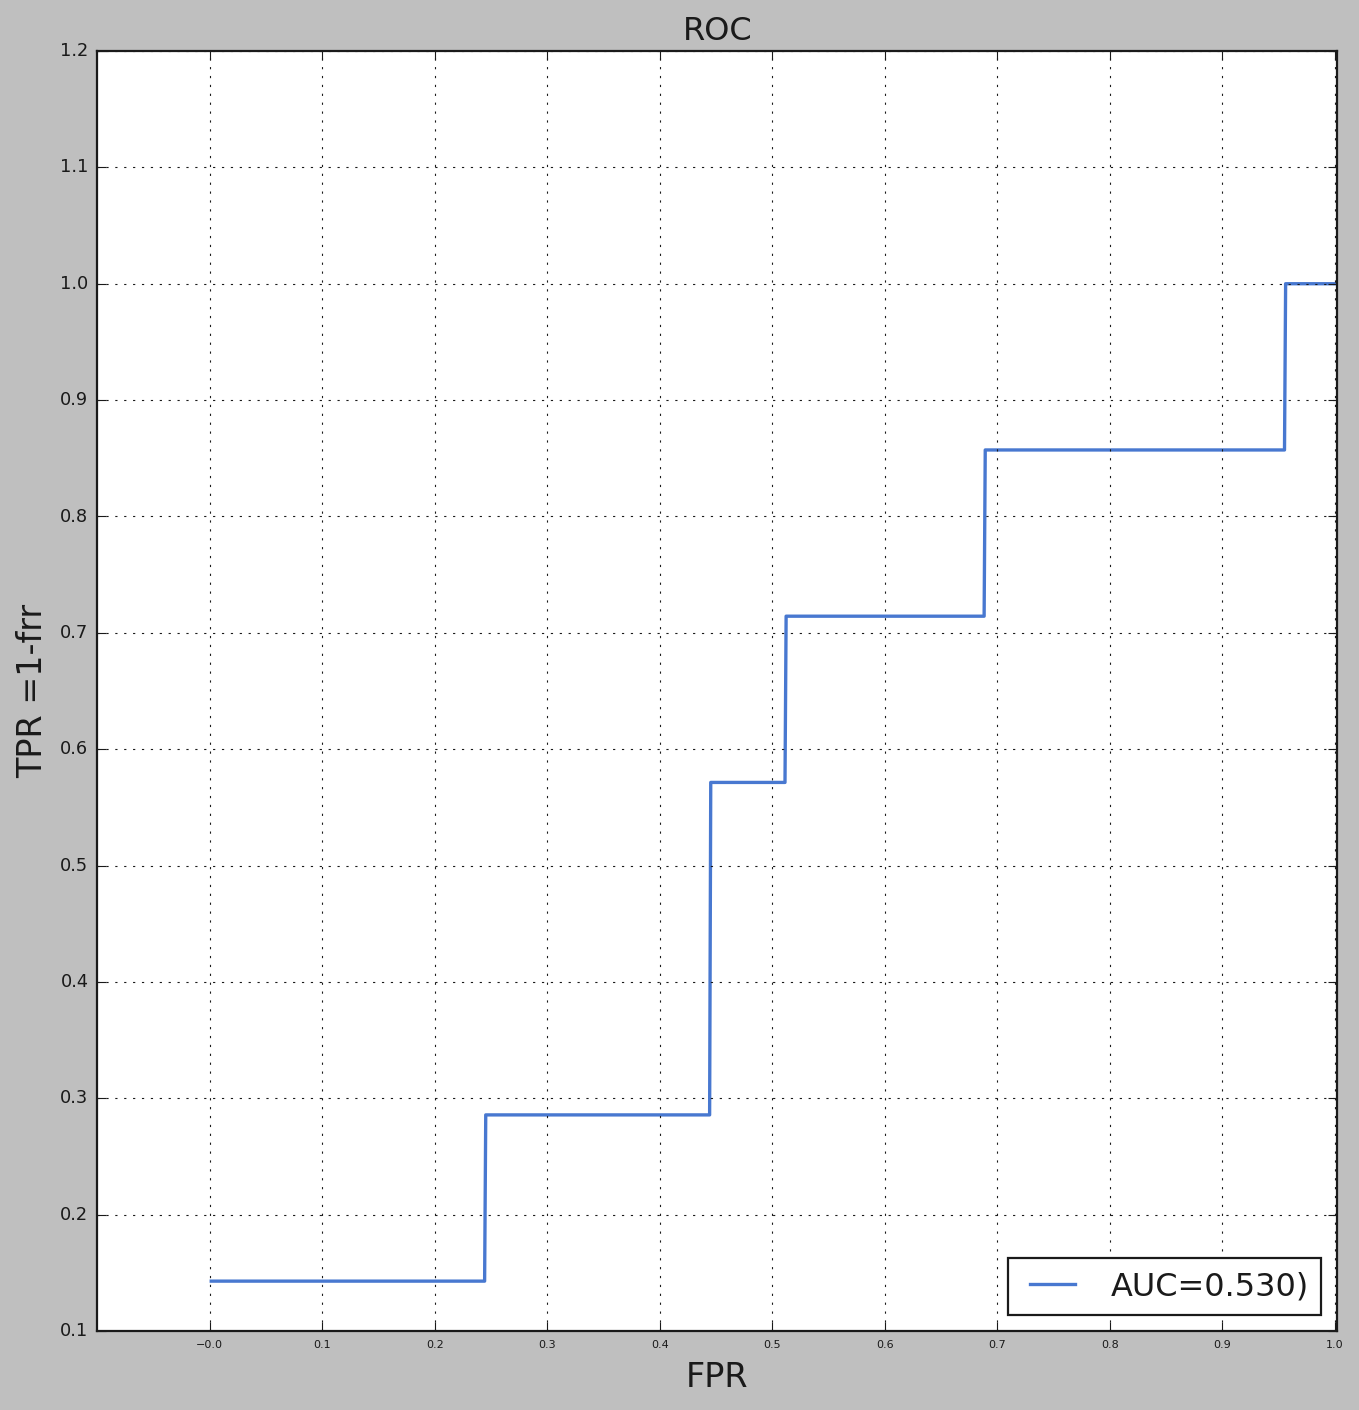

0.8049821428571428


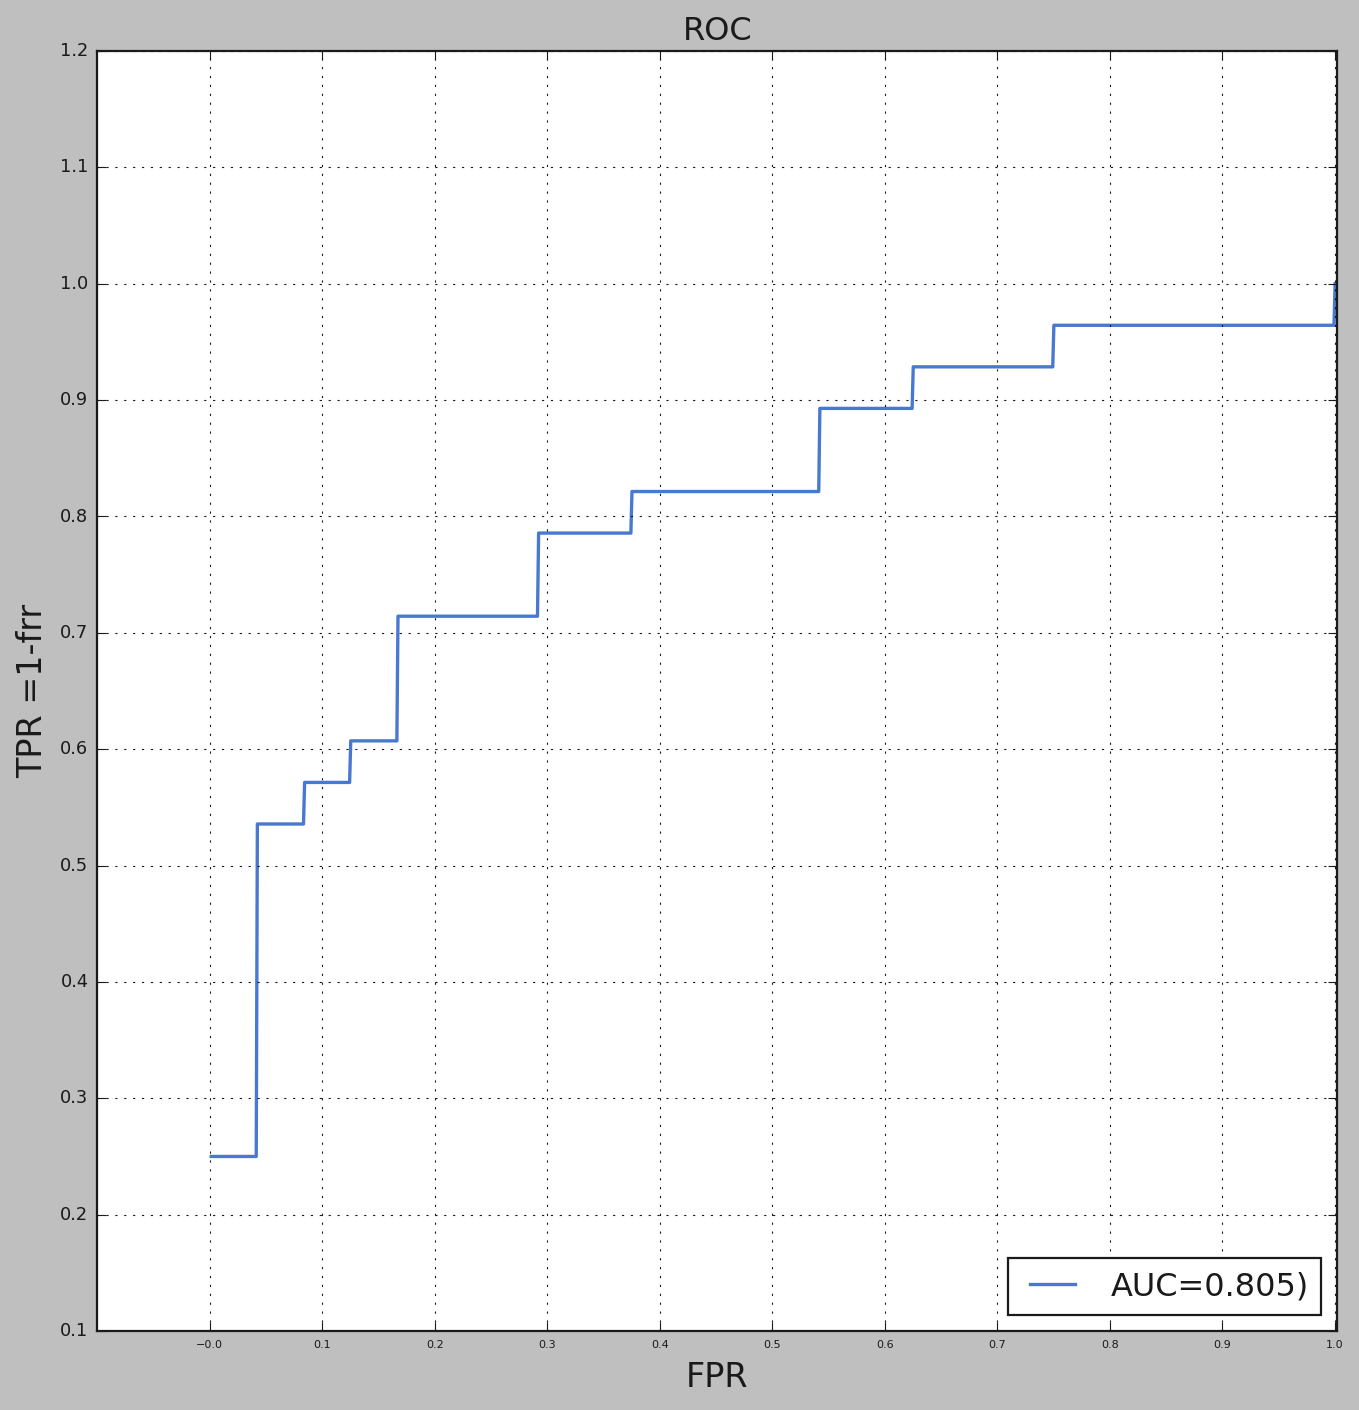

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


nan


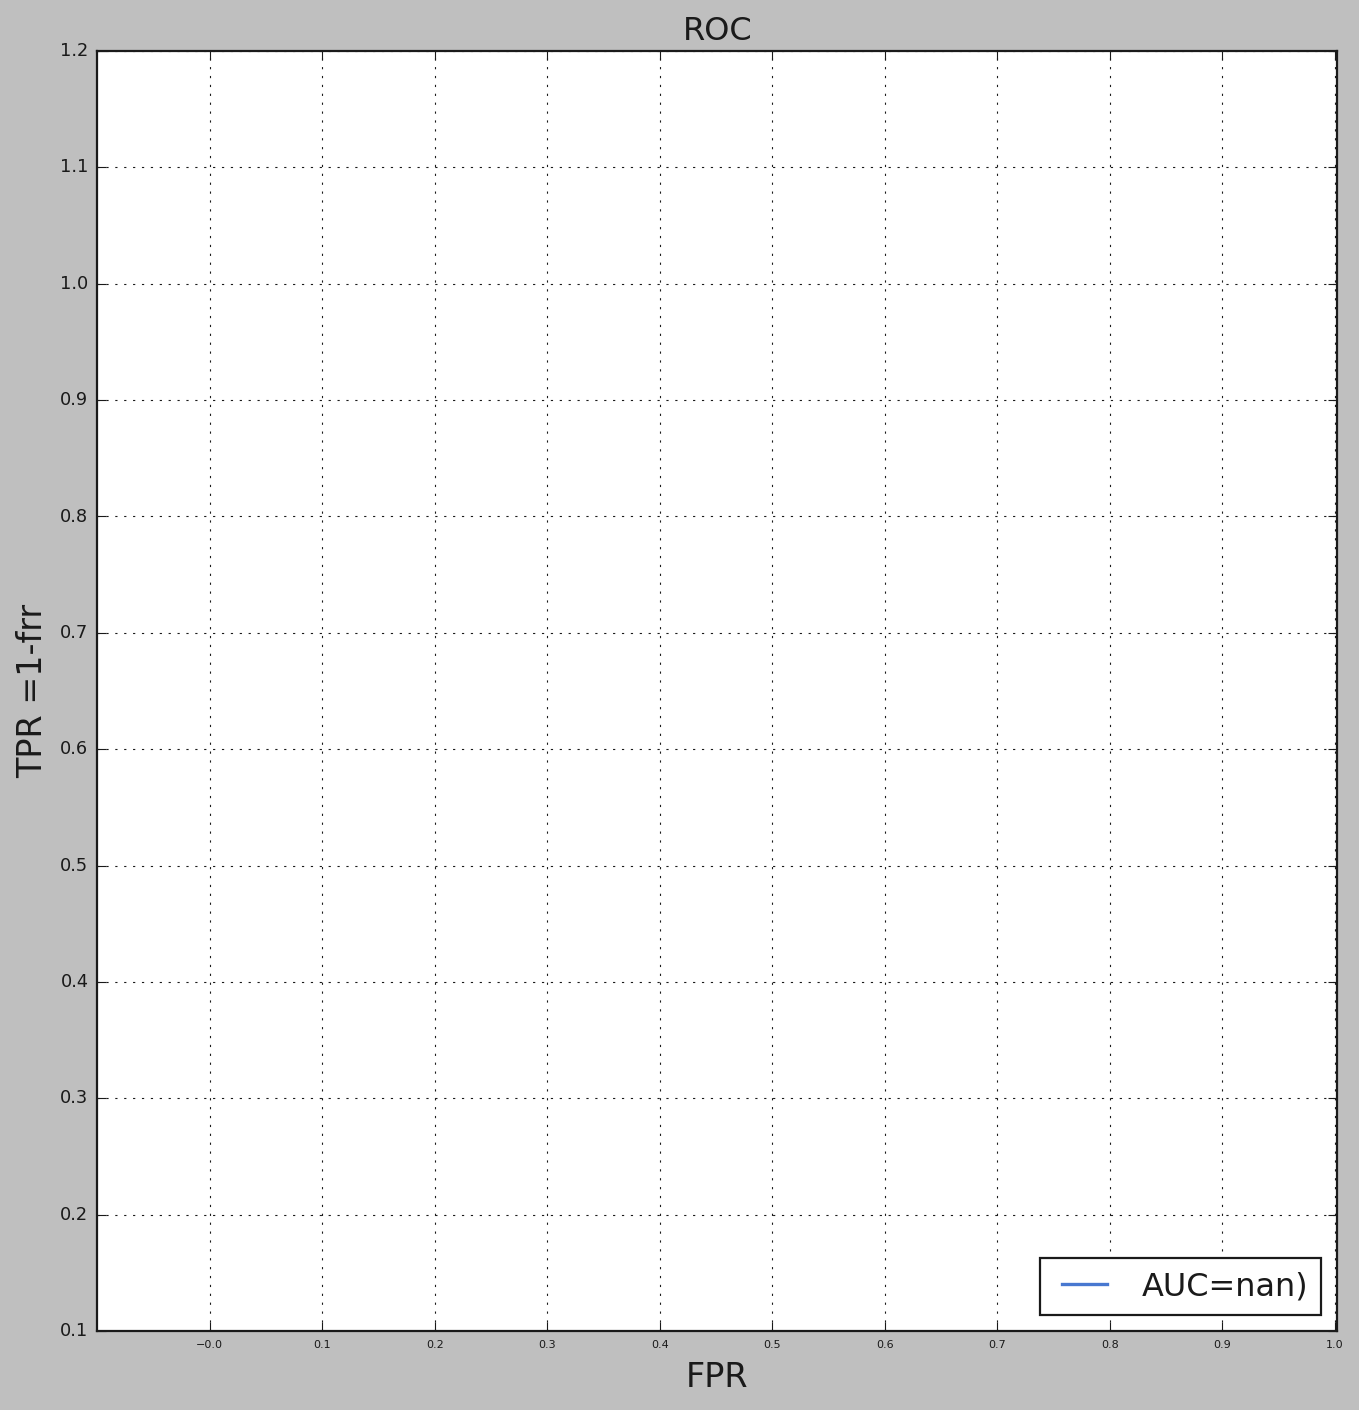

0.6740571428571428


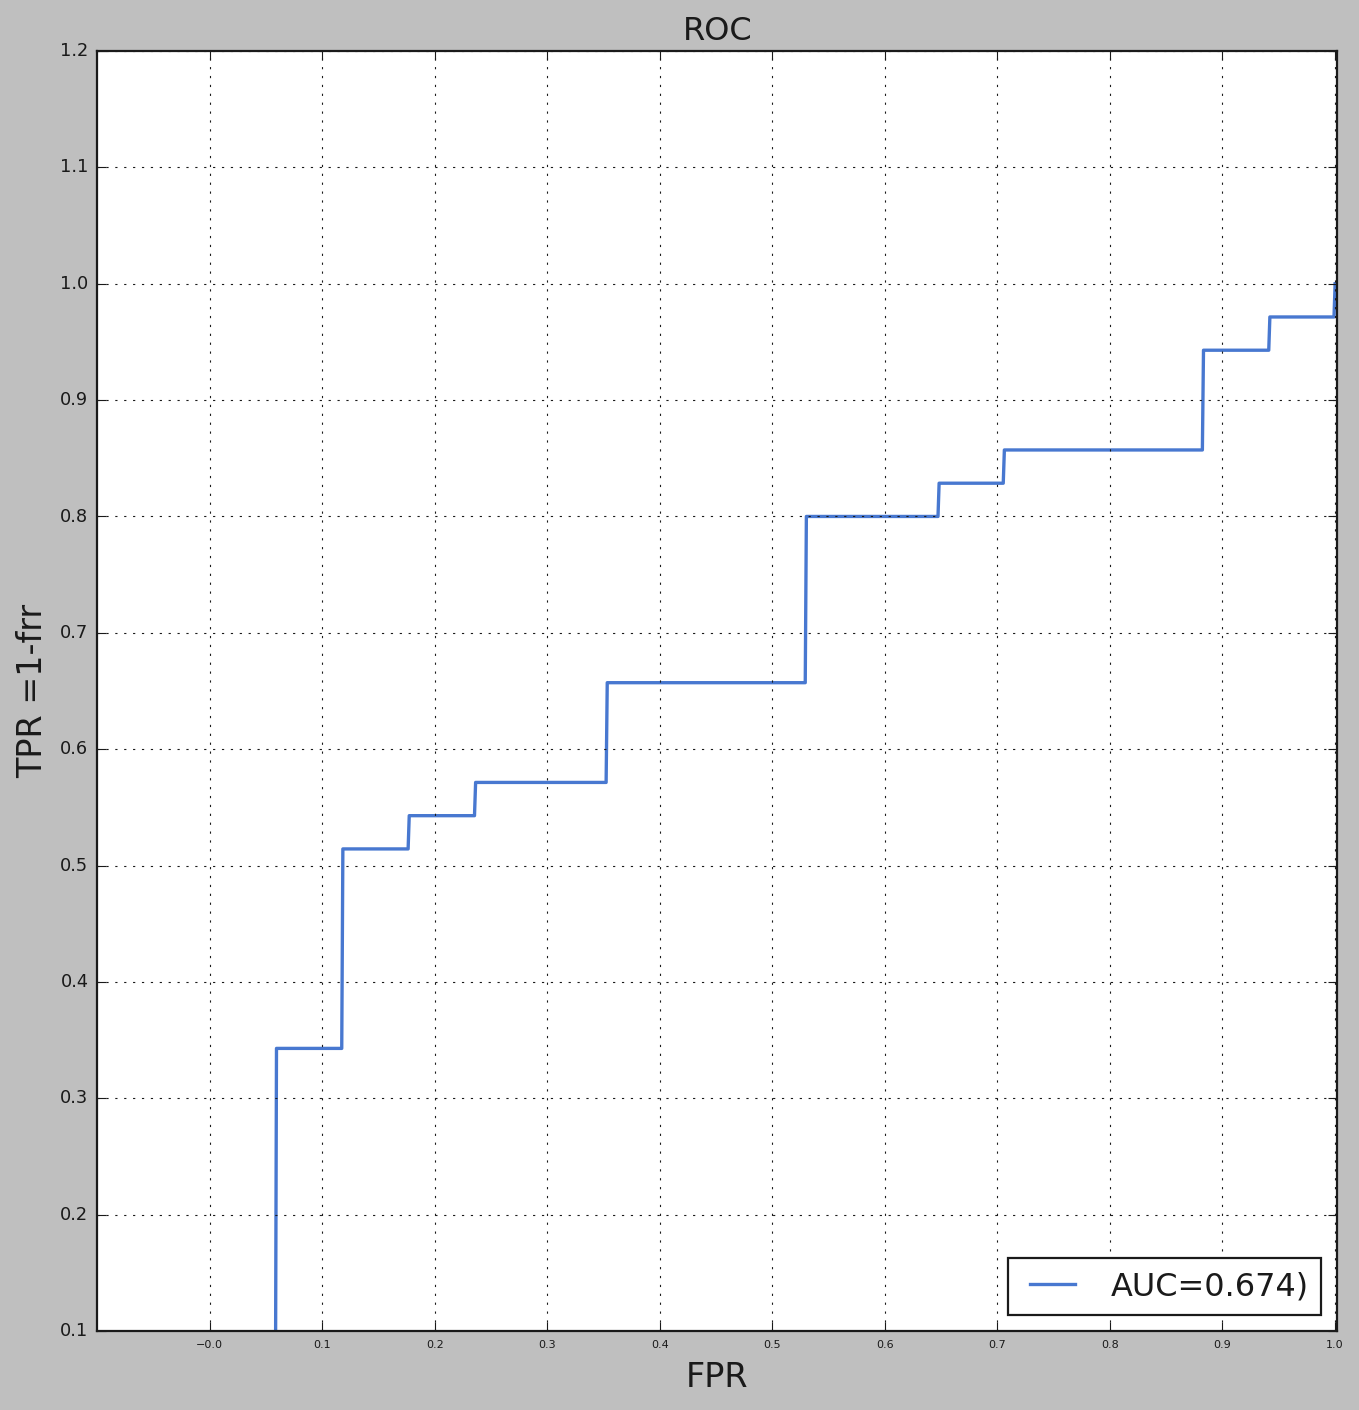

0.4488333333333333


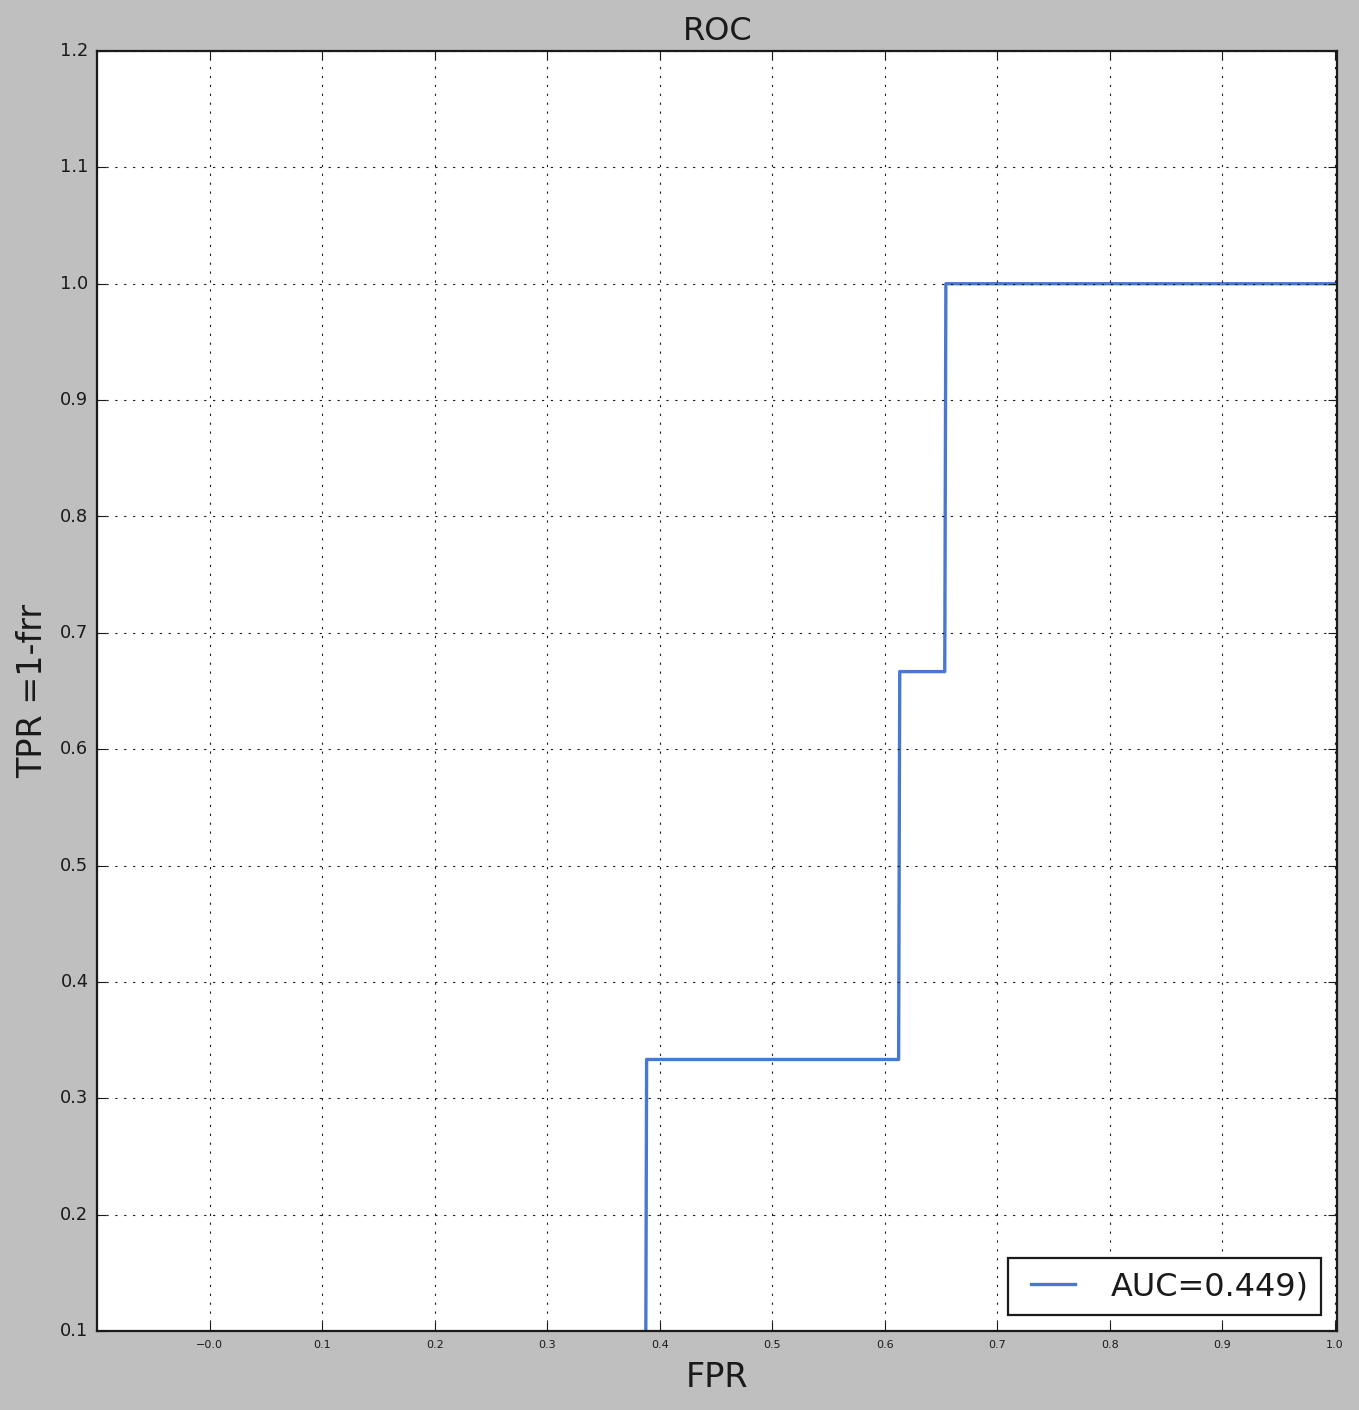

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


nan


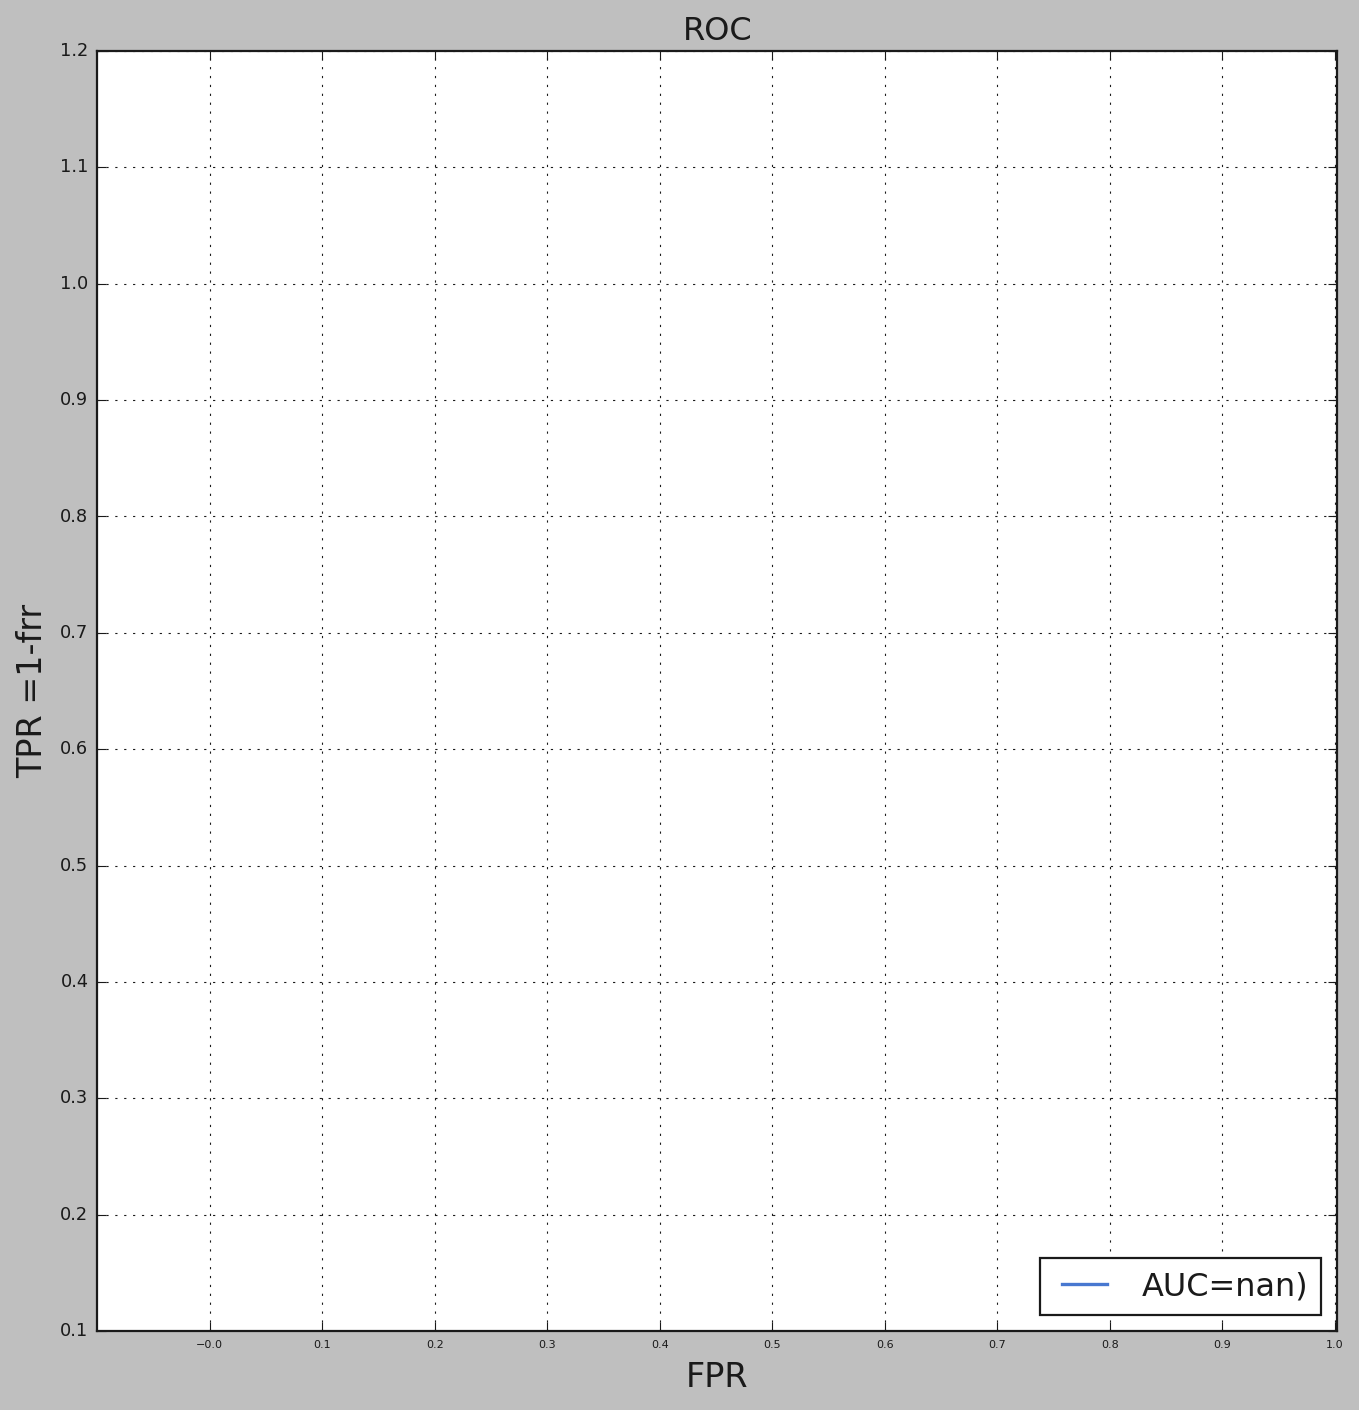

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


nan


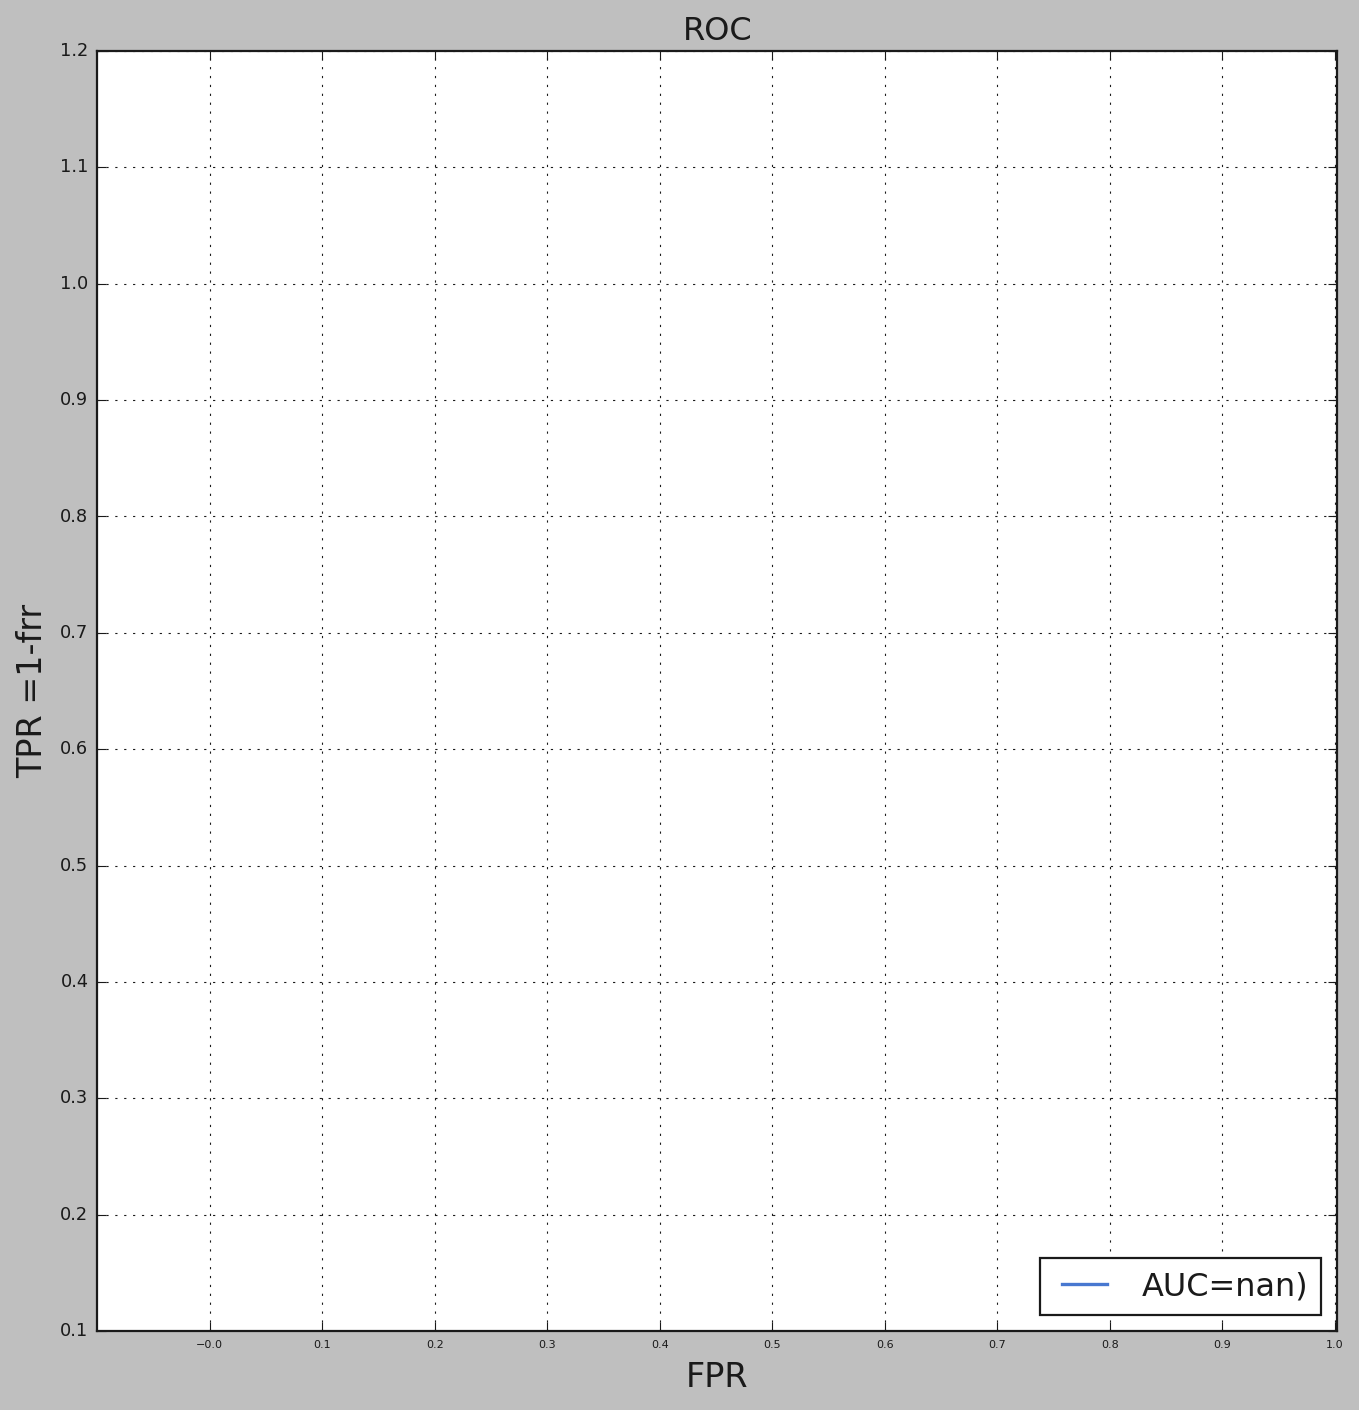

0.9005


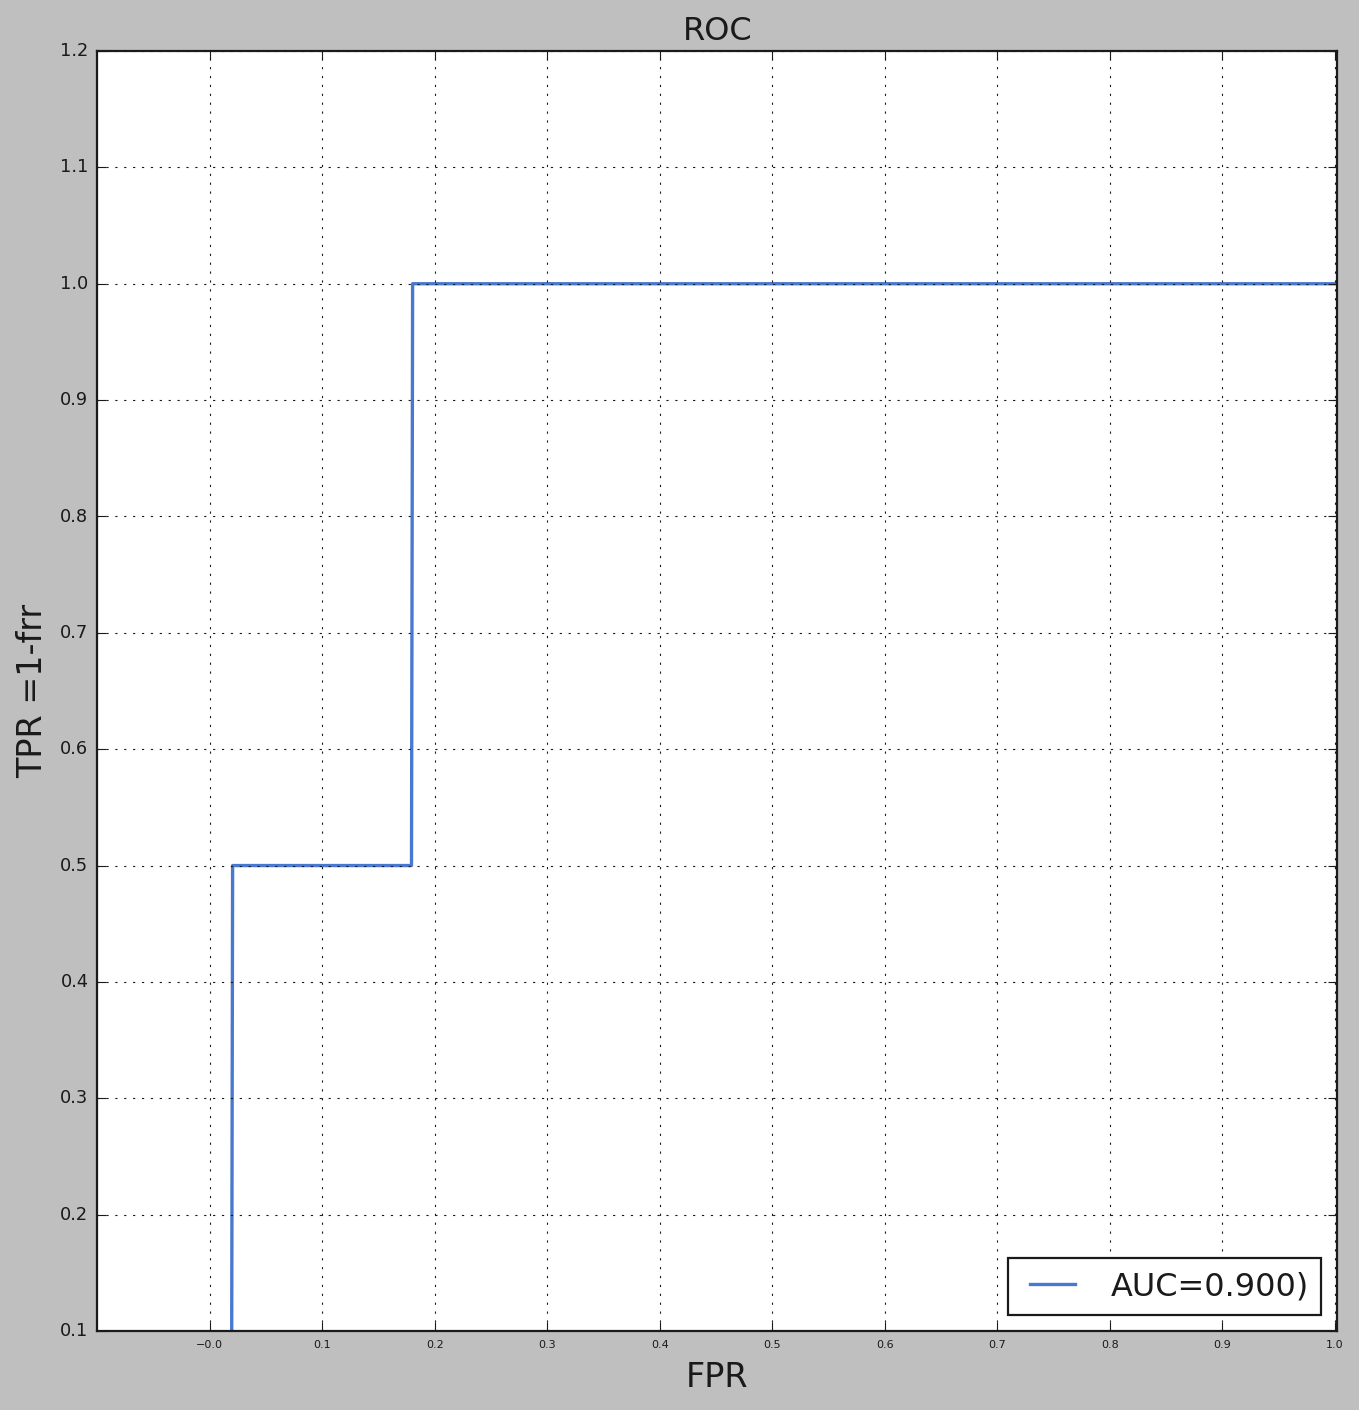

0.9415


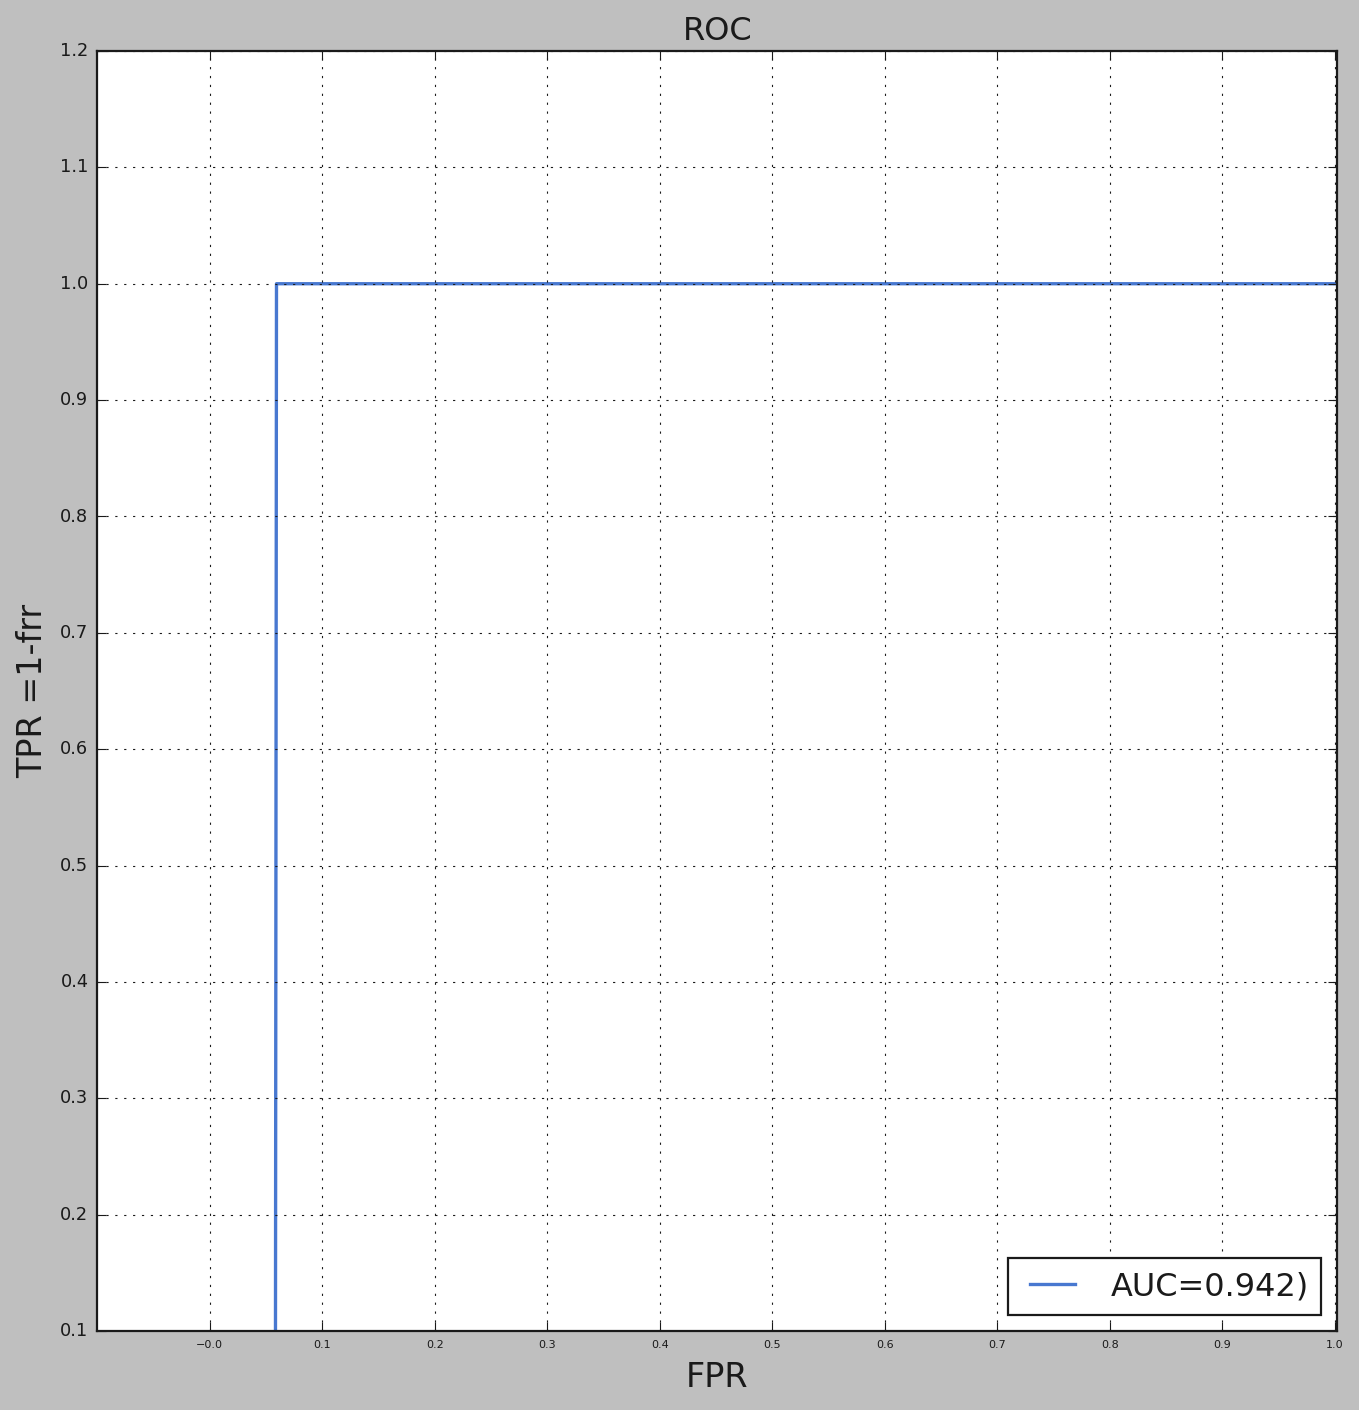

0.7105416666666666


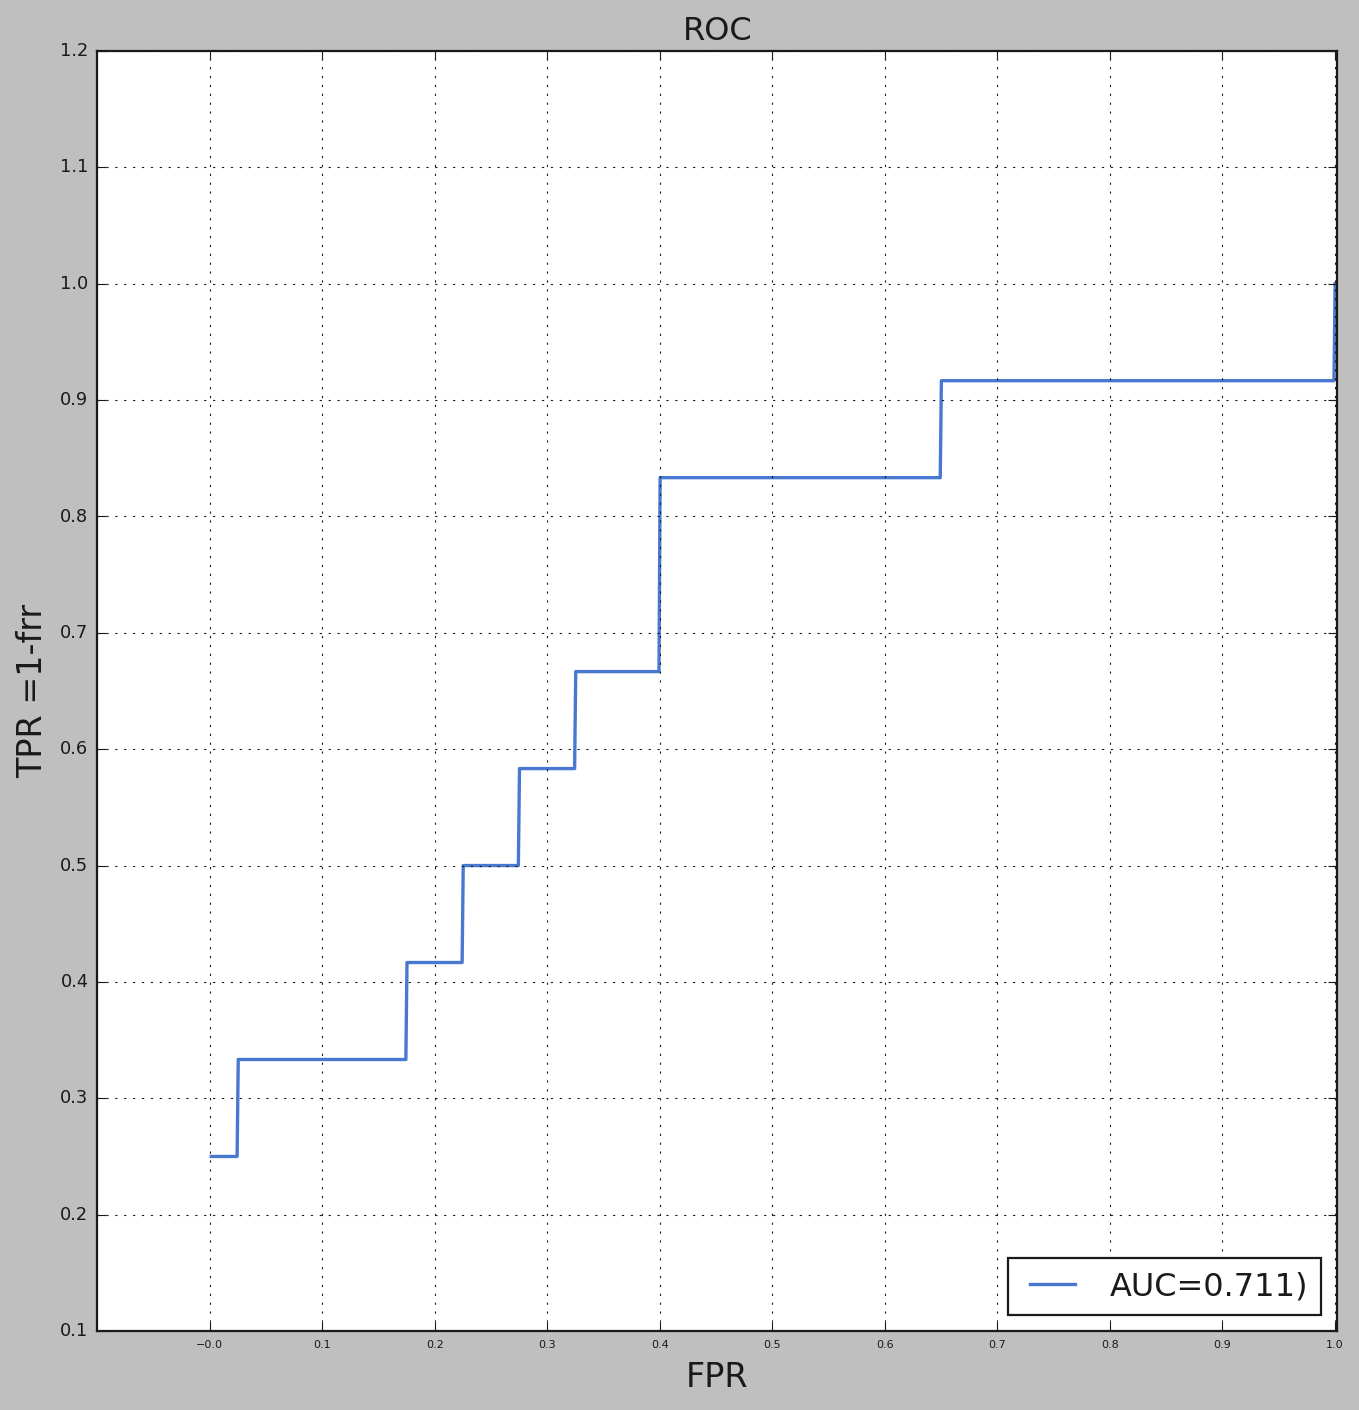

0.2355


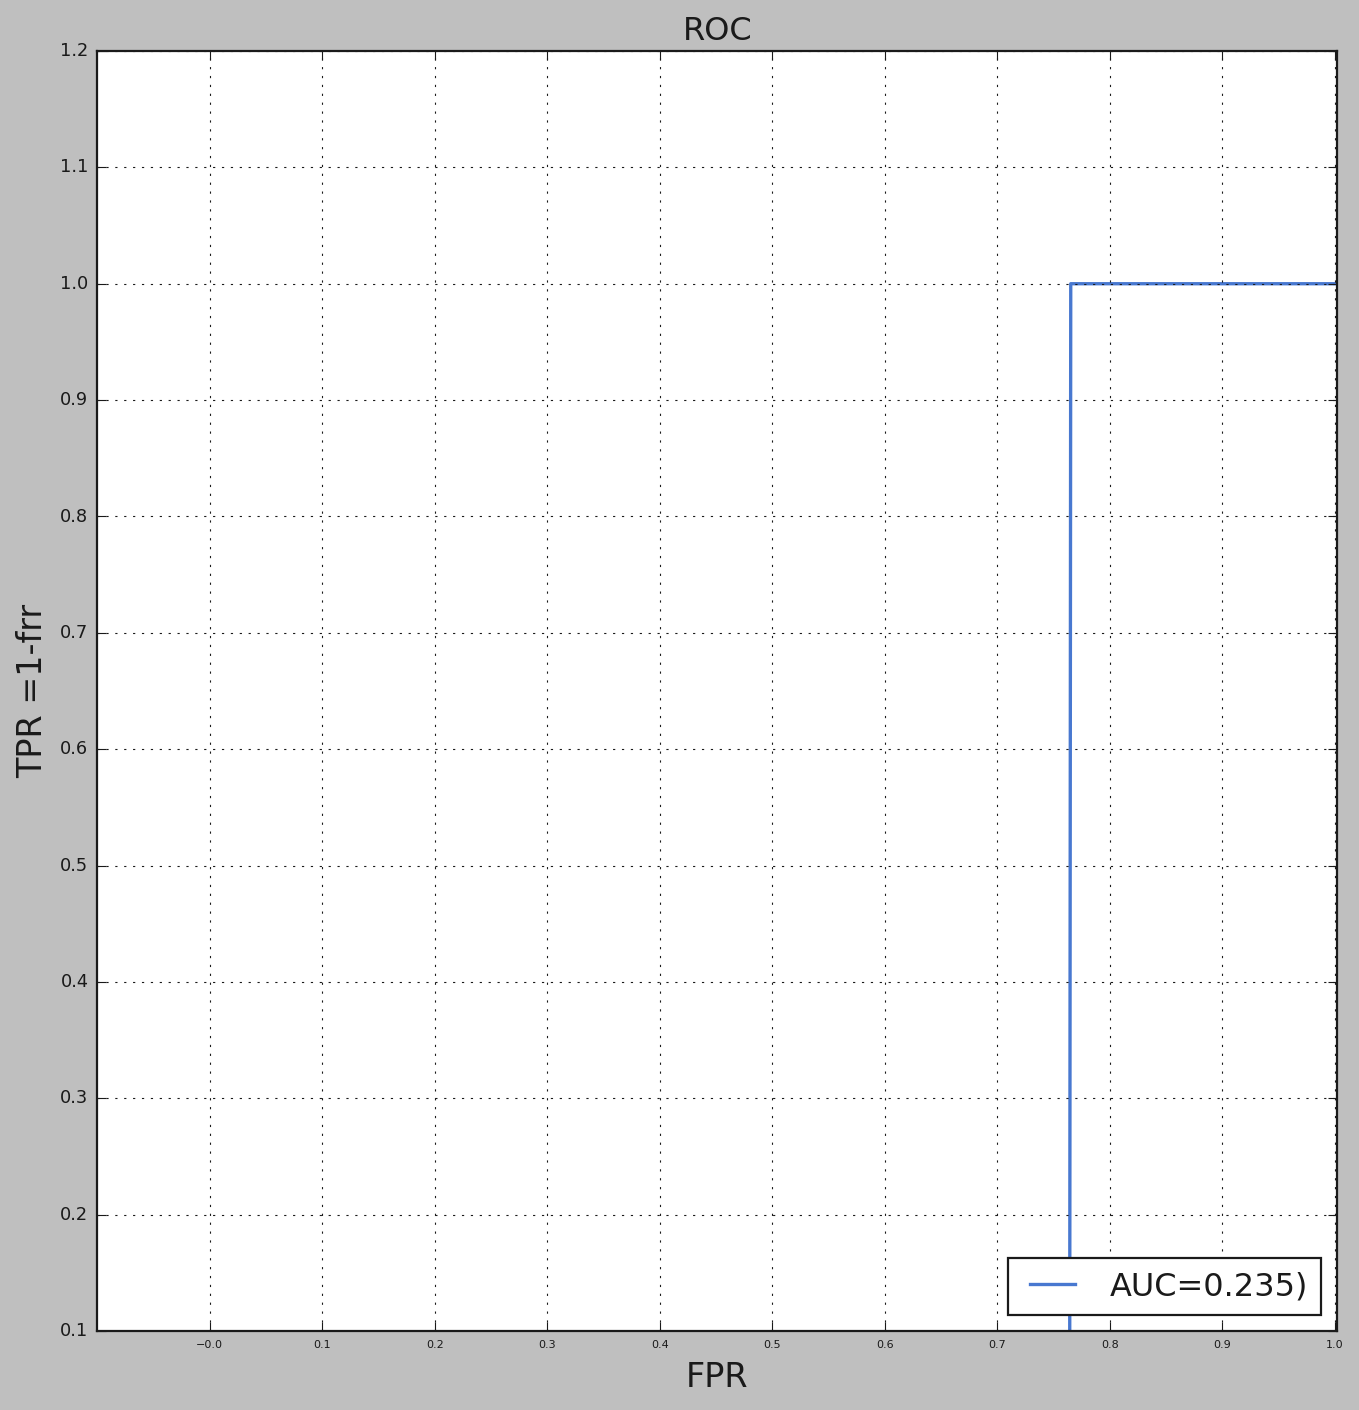

0.999


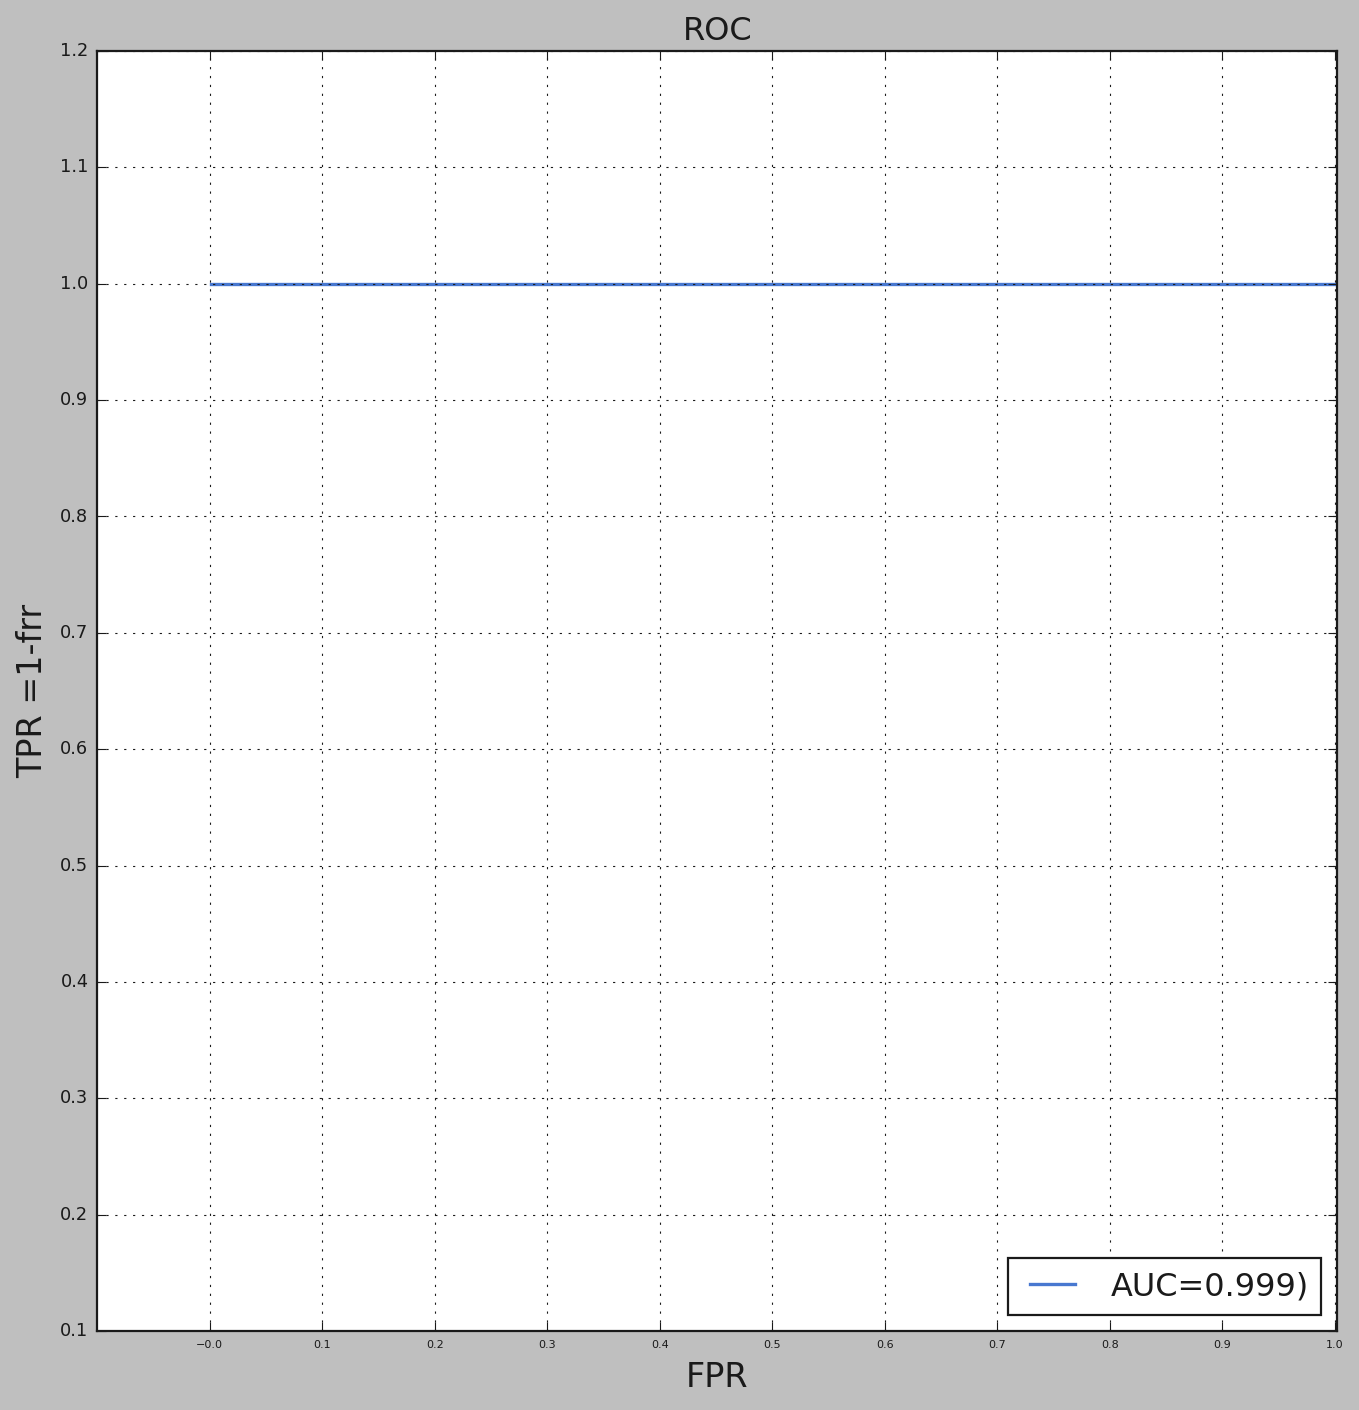

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

for i in range(len(propaganda_techniques_names)):
    
    labels = dev_df[propaganda_techniques_names[i]].to_list()
    scores = [s[i] for s in scoress]

    plt.style.use('classic')
    fpr, tpr, thresholds = roc_curve(labels,scores, pos_label=1)
    from scipy.interpolate import interp1d
    predict= interp1d(fpr, tpr, kind="linear")
    fpr2=np.linspace(0.001,1,1000)
    tpr2=np.array([predict(x) for x in fpr2])

    auc_value = auc(fpr2,tpr2)
    print(auc_value)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr2,tpr2, lw=1.5, label="AUC=%.3f)"%auc_value)
    plt.xlim([-0.100211101, 1.002])
    plt.ylim([0.1, 1.05])
    plt.xlabel("FPR",fontsize=15)
    plt.ylabel("TPR =1-frr",fontsize=15)
    plt.xticks(np.arange(-0.0004, 1.0011, 0.1), size=5)
    plt.yticks(np.arange(0.1, 1.3, 0.1), size=8)
    plt.grid()
    # plt.axvline(x = 0.001, color = 'r', label = 'axvline - full height')

    plt.title("ROC")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
predictions = [pred(row['text']) for index, row in test_df.iterrows()]
labels = [np.array(row[propaganda_techniques_names]) for index, row in test_df.iterrows()]

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
def accuracies(y_pred_pos,y_true,threshold):
    y_pred_class = y_pred_pos > threshold
    y_pred_class = np.array([int(c) for c in y_pred_class])
    tp , fp, tn, fn = cm(y_true, y_pred_class)
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    return accuracy, tp , tn,fp , fn 
    
def cm(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

for i, name in enumerate(propaganda_techniques_names): 
    acc,tp , tn ,fp , fn = accuracies(predictions[i],labels[i],THRESHOLDS[name])
    print(f"{name}: {acc}: {tp + tn}  {THRESHOLDS[name]}")


Appeal to authority: 0.8947368421052632: 17  0.097
Appeal to fear/prejudice: 1.0: 19  0.125
Black-and-white Fallacy/Dictatorship: 0.7894736842105263: 15  0.086
Causal Oversimplification: 0.47368421052631576: 9  0.069
Doubt: 0.5263157894736842: 10  0.071
Exaggeration/Minimisation: 0.8947368421052632: 17  0.12
Flag-waving: 0.8421052631578947: 16  0.083
Glittering generalities (Virtue): 0.8421052631578947: 16  0.101
Loaded Language: 0.8947368421052632: 17  0.404
Misrepresentation of Someone's Position (Straw Man): 0.631578947368421: 12  0.07
Name calling/Labeling: 0.7894736842105263: 15  0.292
Obfuscation, Intentional vagueness, Confusion: 0.47368421052631576: 9  0.069
Presenting Irrelevant Data (Red Herring): 0.8421052631578947: 16  0.085
Reductio ad hitlerum: 0.5789473684210527: 11  0.073
Repetition: 0.631578947368421: 12  0.073
Slogans: 0.8421052631578947: 16  0.081
Smears: 0.9473684210526315: 18  0.142
Thought-terminating cliché: 0.6842105263157895: 13  0.083
Whataboutism: 0.842105263

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Personality')
    plt.xlabel('Predicted Personality');

In [ ]:
predictio = []
for i, name in enumerate(propaganda_techniques_names): 
  predictions0 = []
  for p in np.array(predictions)[:, i]:
    if p>THRESHOLDS[name] :
      predictions0.append(1)
    else:
      predictions0.append(0)
  predictio.append(predictions0)
predictio = np.array(predictio)
predictio.shape

(19, 323)

In [ ]:
predictio = []
for i, name in enumerate(propaganda_techniques_names): 
  predictions0 = []
  for p in np.array(predictions)[:, i]:
    if p>0.2 :
      predictions0.append(1)
    else:
      predictions0.append(0)
  predictio.append(predictions0)
predictio = np.array(predictio)
predictio.shape

(19, 323)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       322
           1       0.00      0.00      0.00         1

    accuracy                           1.00       323
   macro avg       0.50      0.50      0.50       323
weighted avg       0.99      1.00      1.00       323



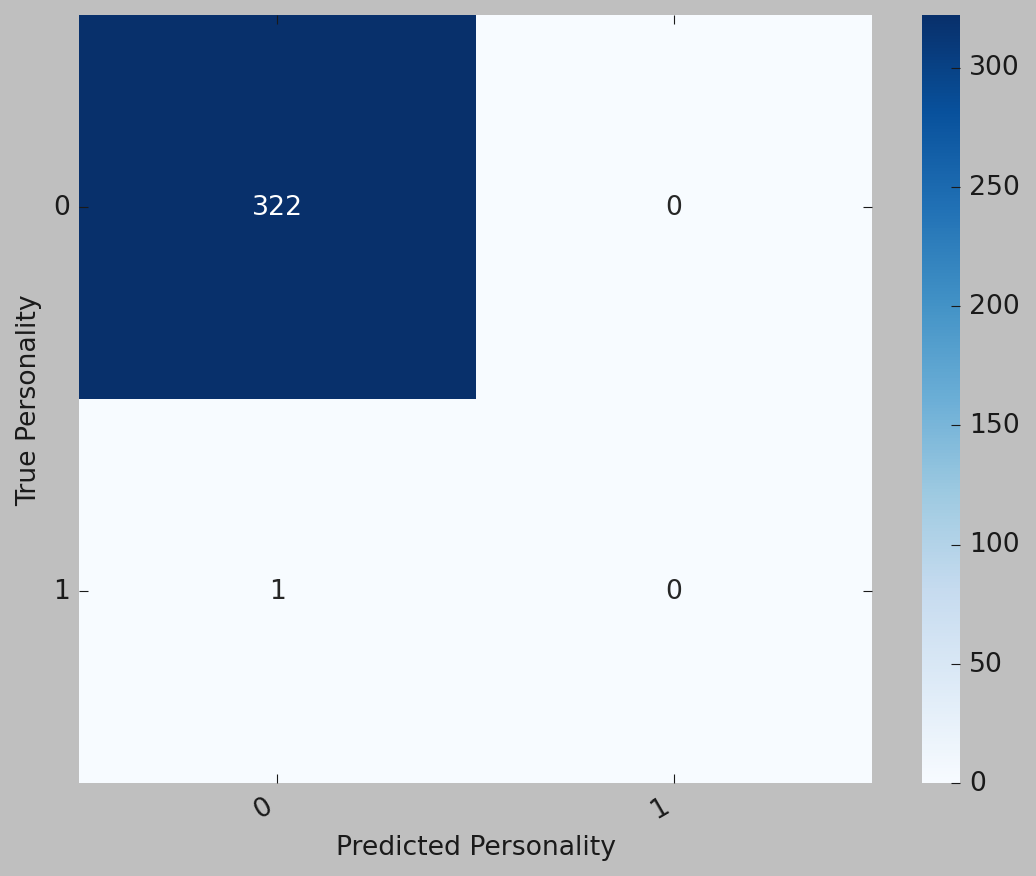

In [ ]:
i = 0
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96       298
           1       0.00      0.00      0.00        25

    accuracy                           0.92       323
   macro avg       0.46      0.50      0.48       323
weighted avg       0.85      0.92      0.89       323



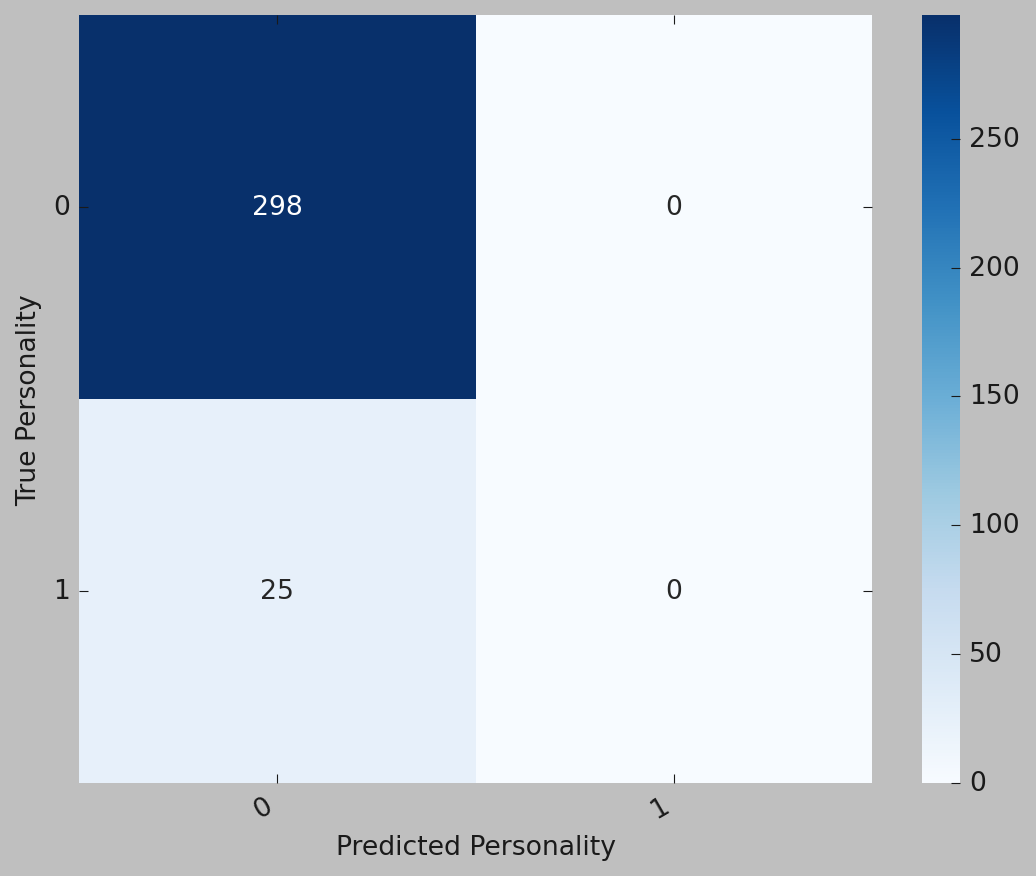

In [ ]:
i = 1
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       316
           1       0.00      0.00      0.00         7

    accuracy                           0.98       323
   macro avg       0.49      0.50      0.49       323
weighted avg       0.96      0.98      0.97       323



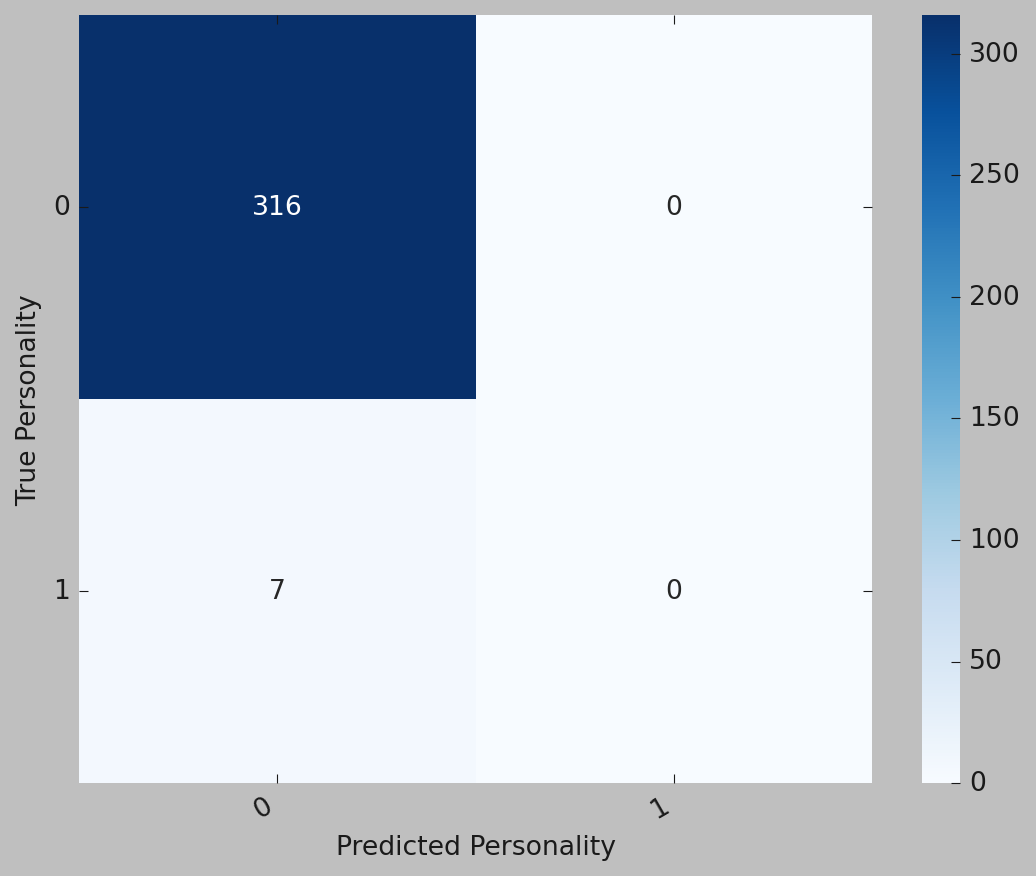

In [ ]:
i = 2
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       319
           1       0.00      0.00      0.00         4

    accuracy                           0.99       323
   macro avg       0.49      0.50      0.50       323
weighted avg       0.98      0.99      0.98       323



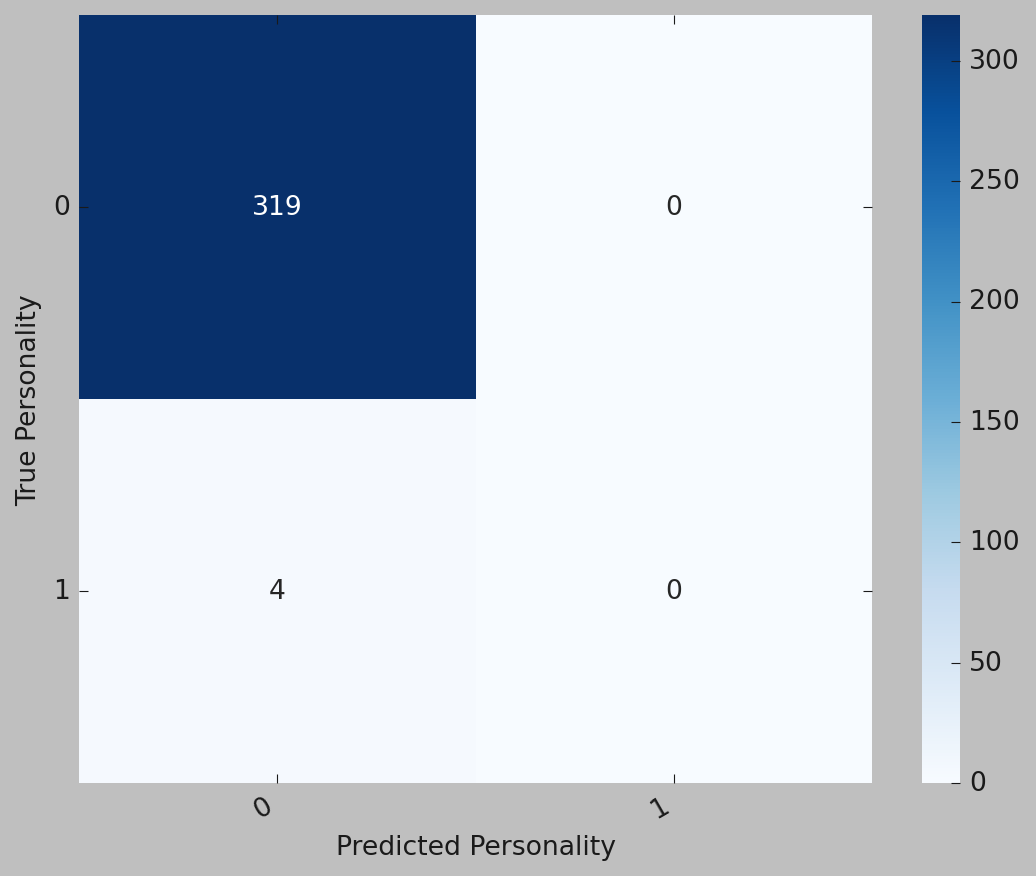

In [ ]:
i = 3
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       304
           1       0.00      0.00      0.00        19

    accuracy                           0.94       323
   macro avg       0.47      0.50      0.48       323
weighted avg       0.89      0.94      0.91       323



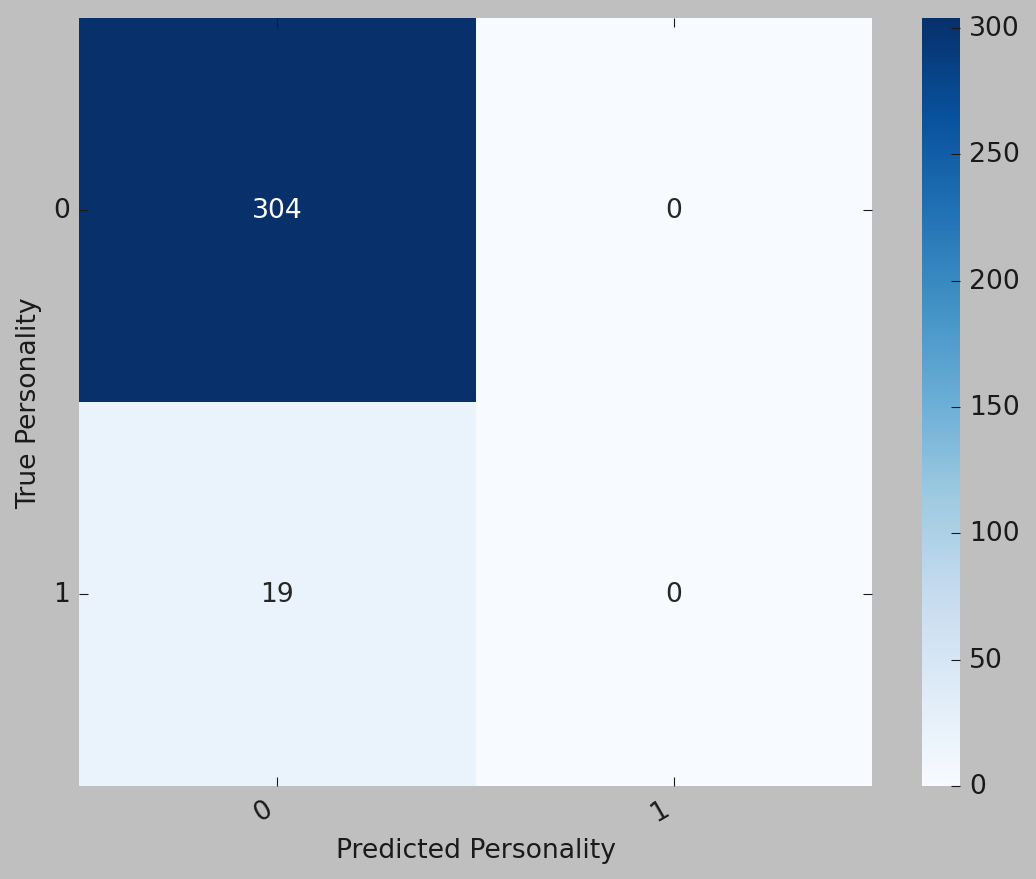

In [ ]:
i = 4
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.93      1.00      0.96       300
           1       0.00      0.00      0.00        23

    accuracy                           0.93       323
   macro avg       0.46      0.50      0.48       323
weighted avg       0.86      0.93      0.89       323



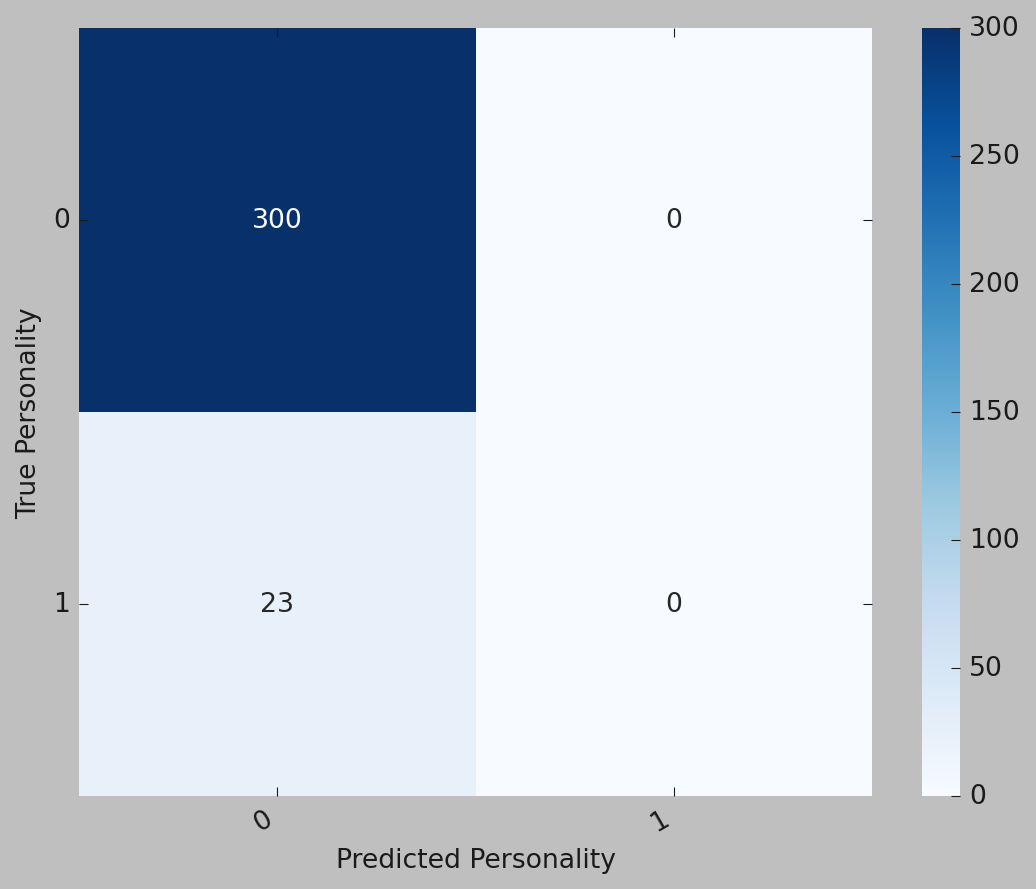

In [ ]:
i = 5
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98       313
           1       0.00      0.00      0.00        10

    accuracy                           0.97       323
   macro avg       0.48      0.50      0.49       323
weighted avg       0.94      0.97      0.95       323



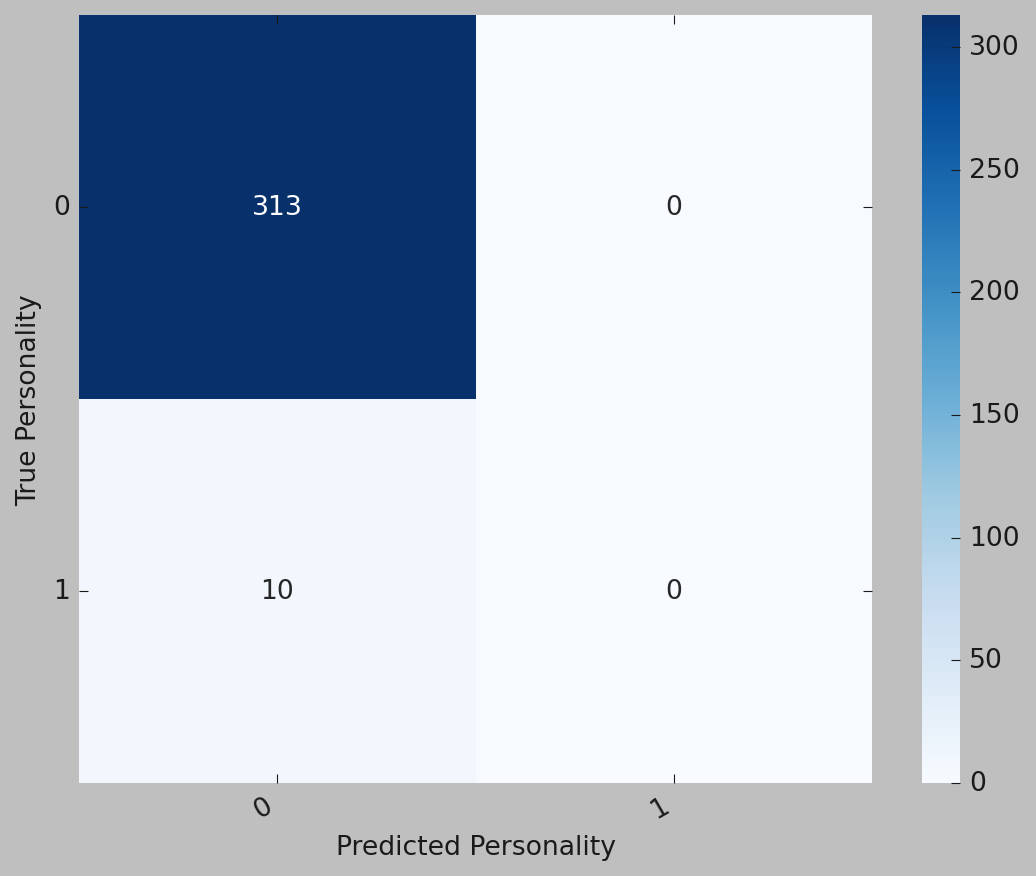

In [ ]:
i = 6
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       322
           1       0.00      0.00      0.00         1

    accuracy                           1.00       323
   macro avg       0.50      0.50      0.50       323
weighted avg       0.99      1.00      1.00       323



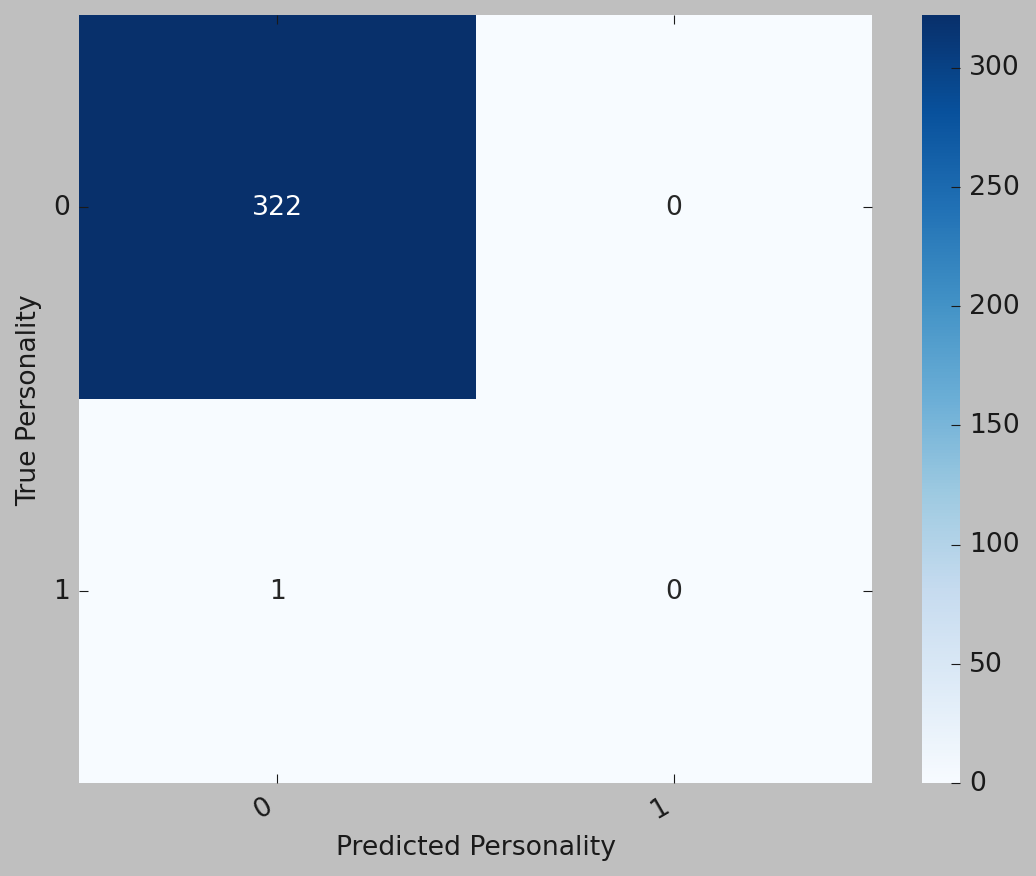

In [ ]:
i = 7
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.69      1.00      0.82       223

    accuracy                           0.69       323
   macro avg       0.35      0.50      0.41       323
weighted avg       0.48      0.69      0.56       323



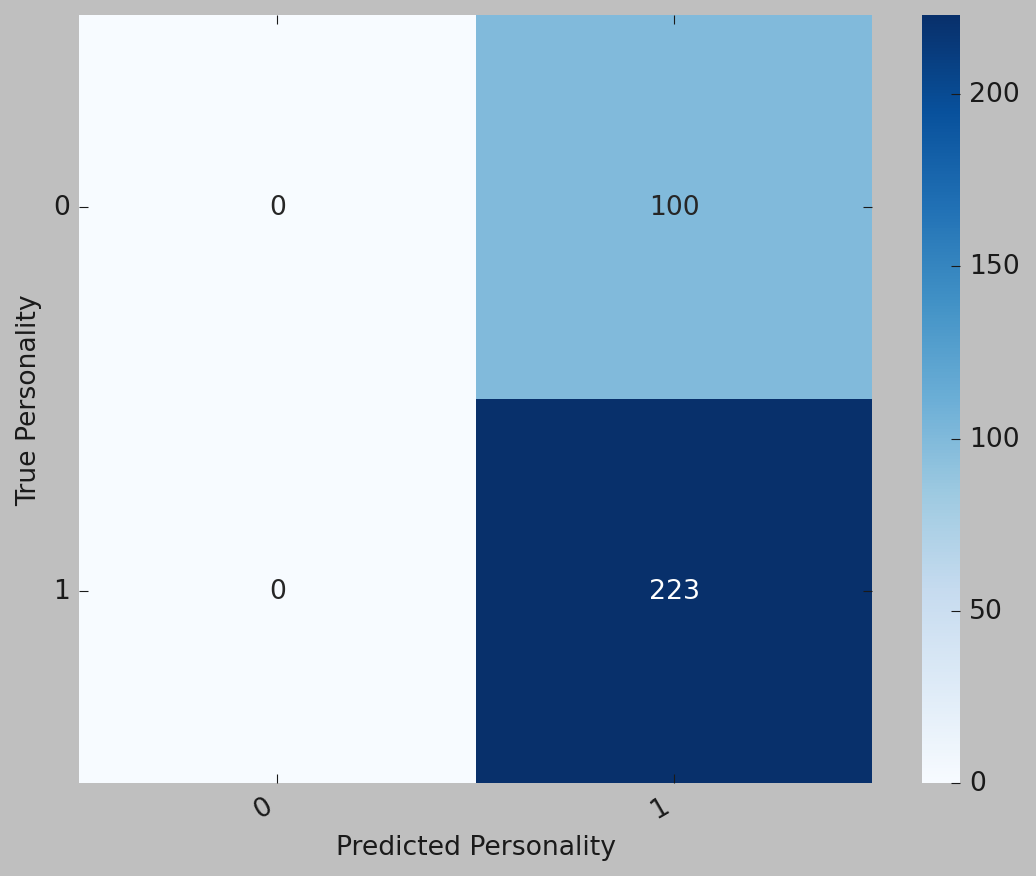

In [ ]:
i = 8
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       322
           1       0.00      0.00      0.00         1

    accuracy                           1.00       323
   macro avg       0.50      0.50      0.50       323
weighted avg       0.99      1.00      1.00       323



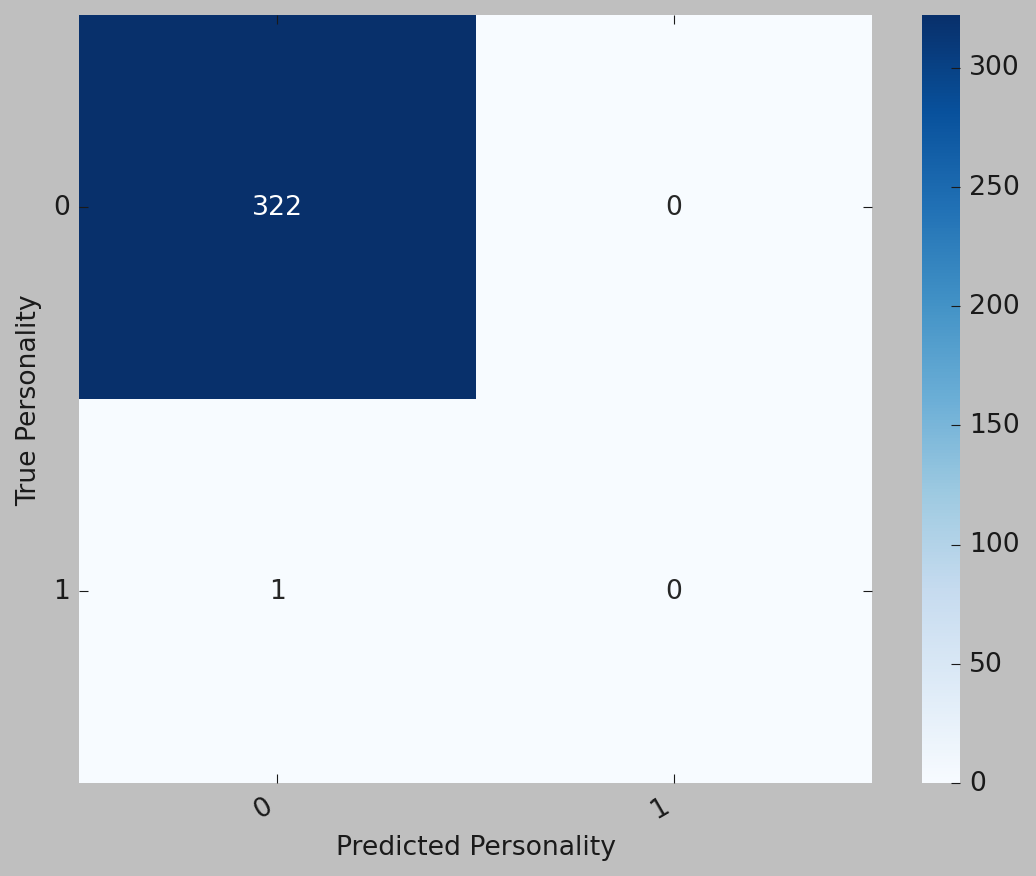

In [ ]:
i = 9
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       181
           1       0.44      1.00      0.61       142

    accuracy                           0.44       323
   macro avg       0.22      0.50      0.31       323
weighted avg       0.19      0.44      0.27       323



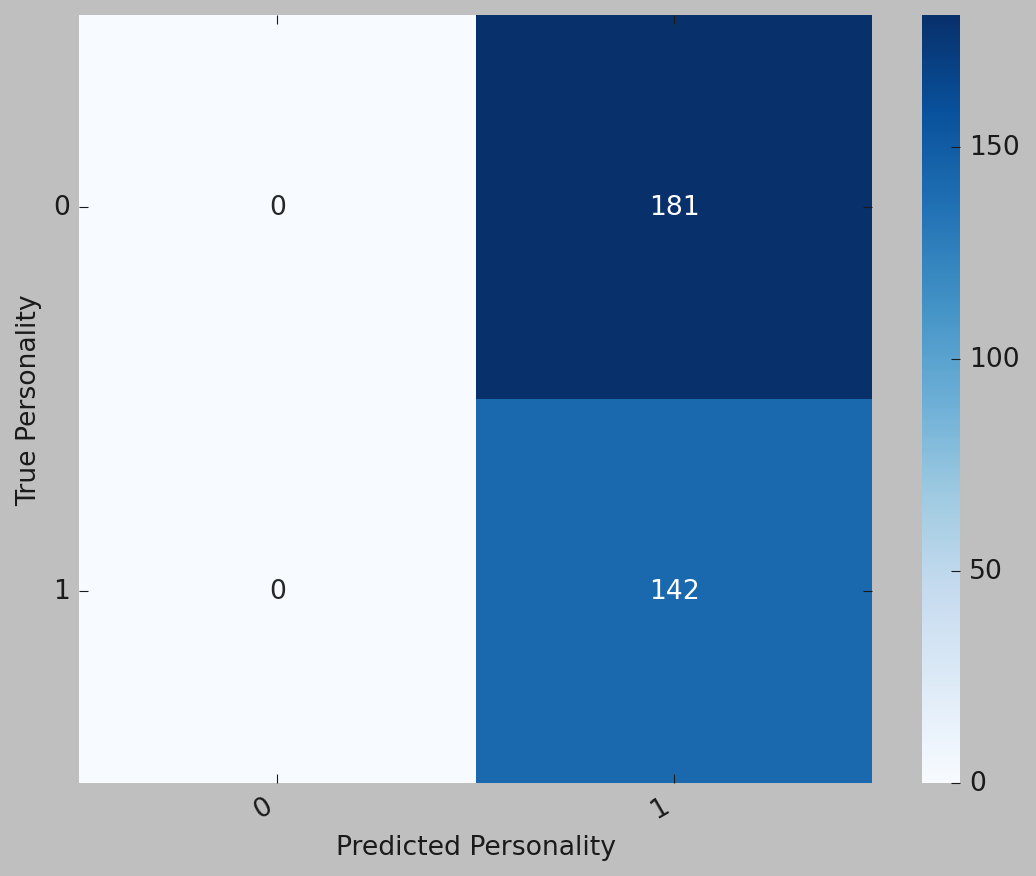

In [ ]:
i = 10
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       317
           1       0.00      0.00      0.00         6

    accuracy                           0.98       323
   macro avg       0.49      0.50      0.50       323
weighted avg       0.96      0.98      0.97       323



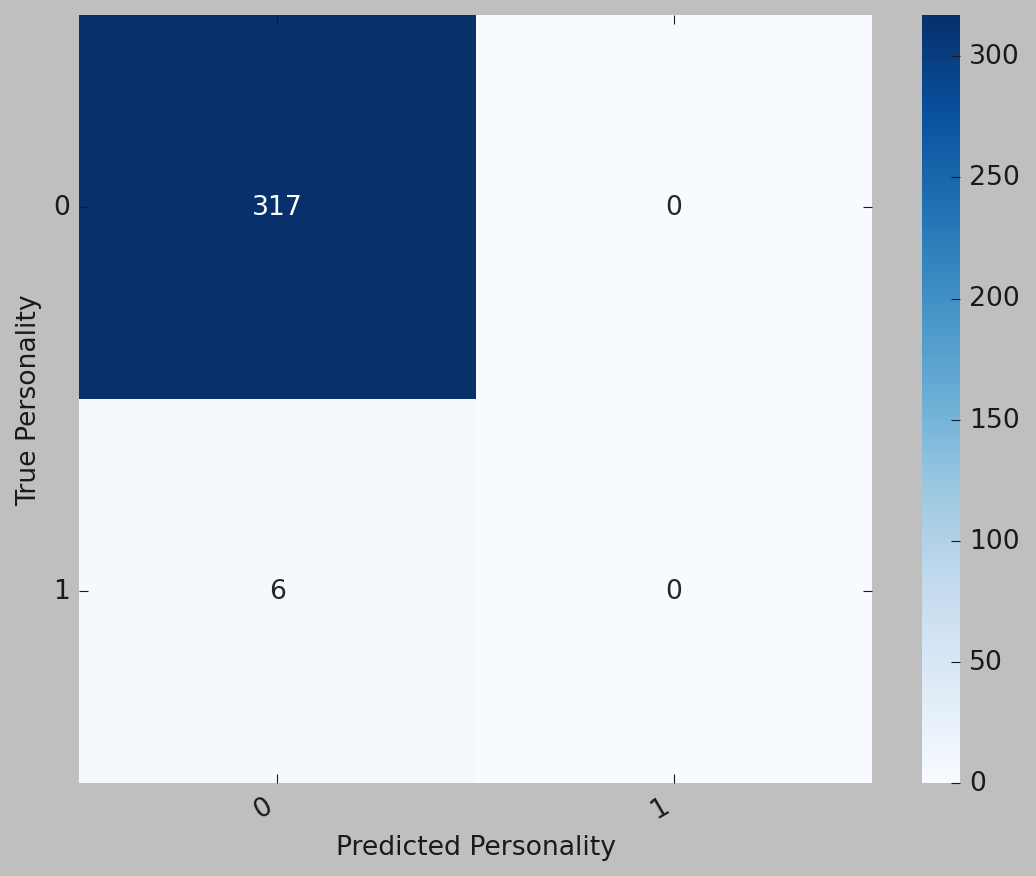

In [ ]:
i = 11
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323

    accuracy                           1.00       323
   macro avg       1.00      1.00      1.00       323
weighted avg       1.00      1.00      1.00       323



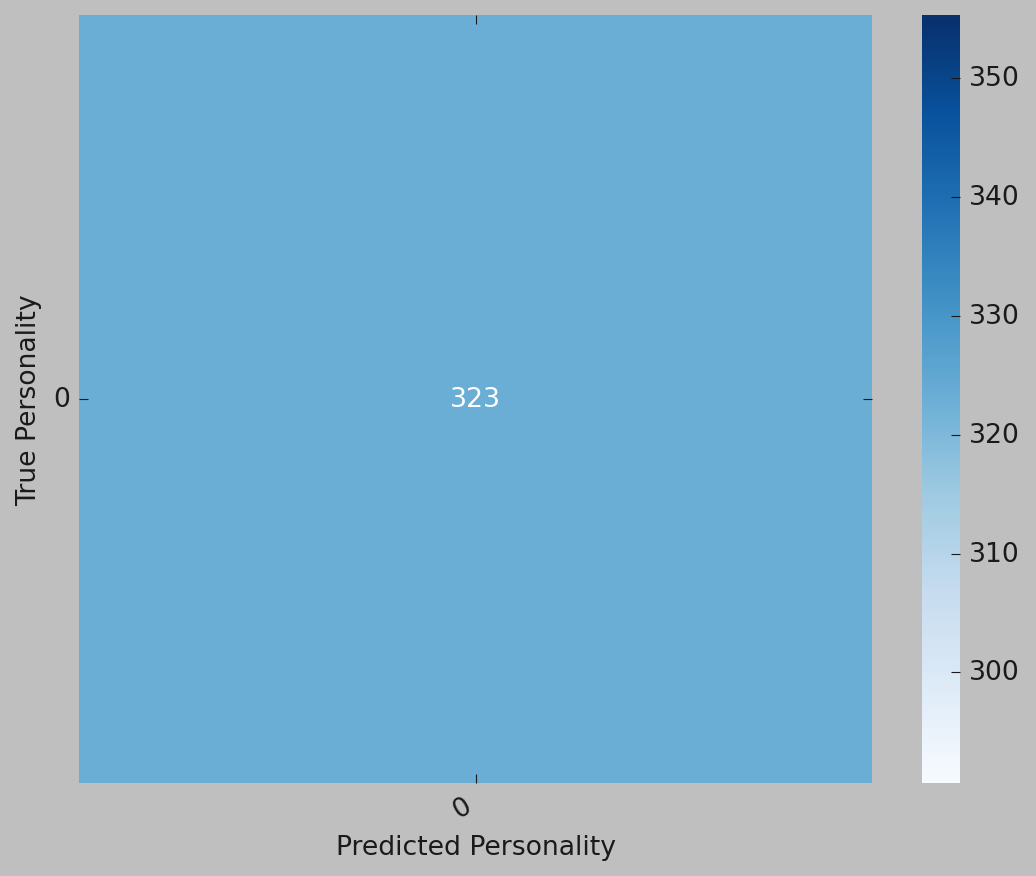

In [ ]:
i = 12
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323

    accuracy                           1.00       323
   macro avg       1.00      1.00      1.00       323
weighted avg       1.00      1.00      1.00       323



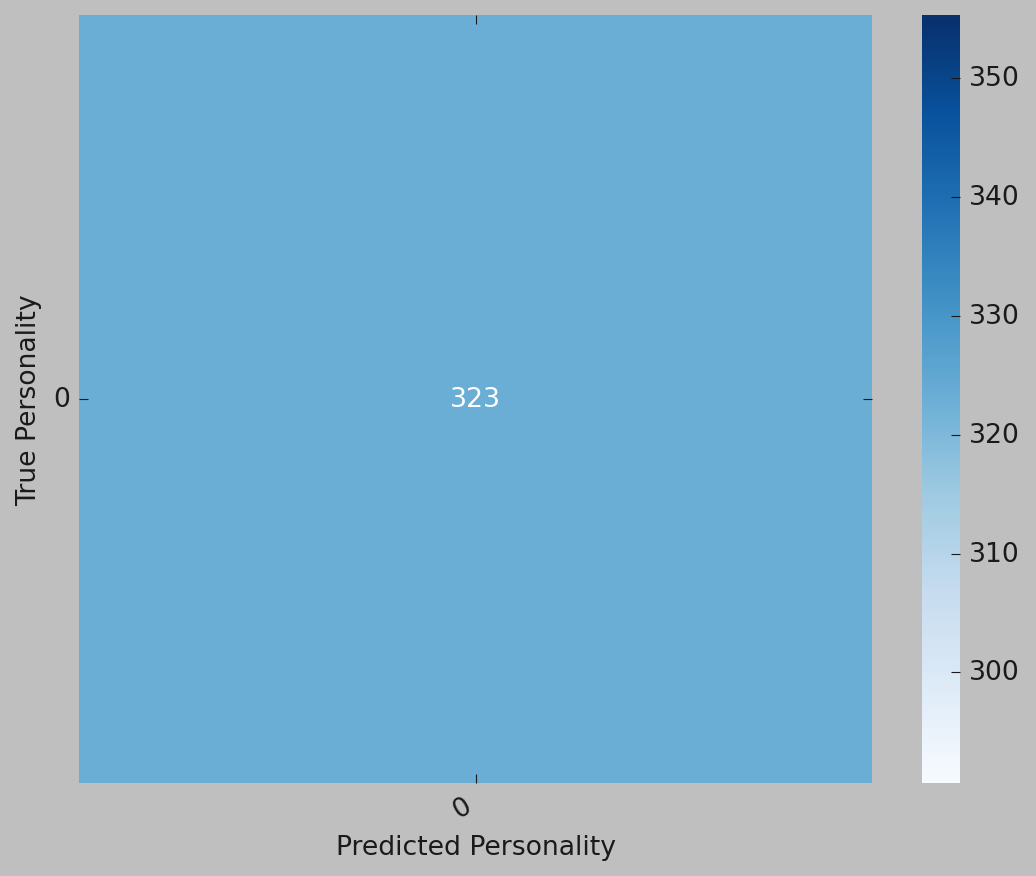

In [ ]:
i = 13
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       320
           1       0.00      0.00      0.00         3

    accuracy                           0.99       323
   macro avg       0.50      0.50      0.50       323
weighted avg       0.98      0.99      0.99       323



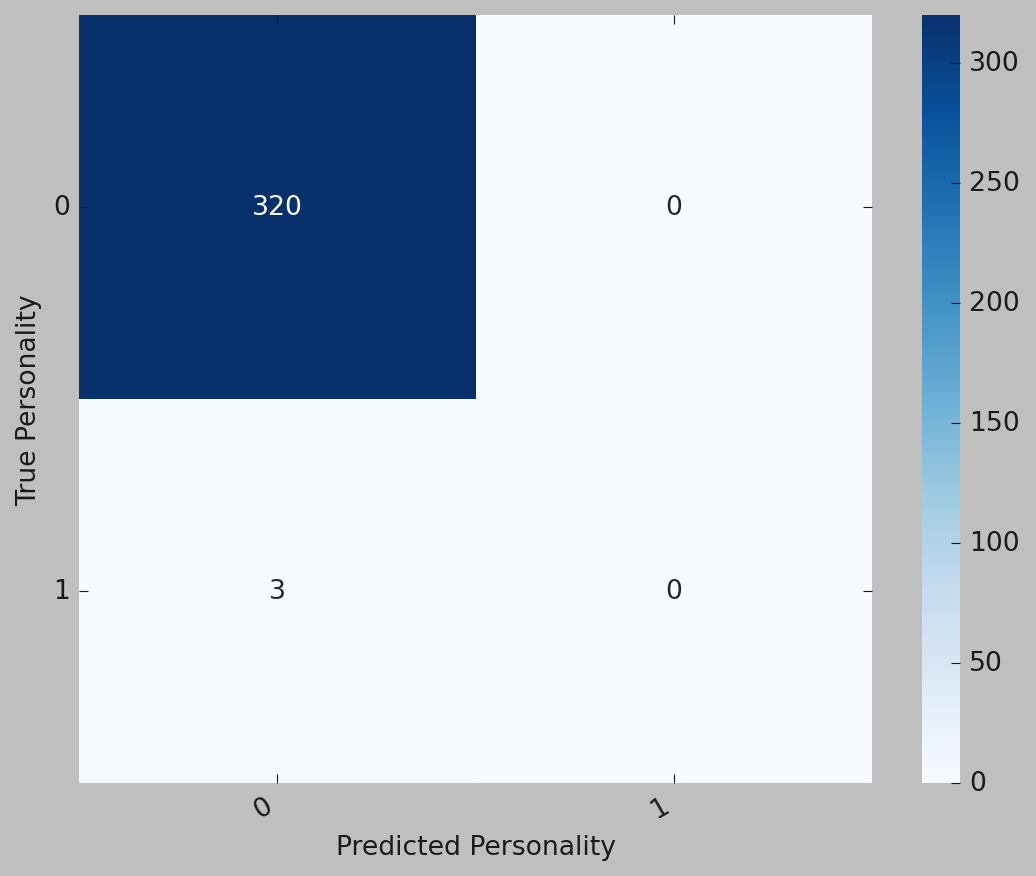

In [ ]:
i = 14
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       316
           1       0.00      0.00      0.00         7

    accuracy                           0.98       323
   macro avg       0.49      0.50      0.49       323
weighted avg       0.96      0.98      0.97       323



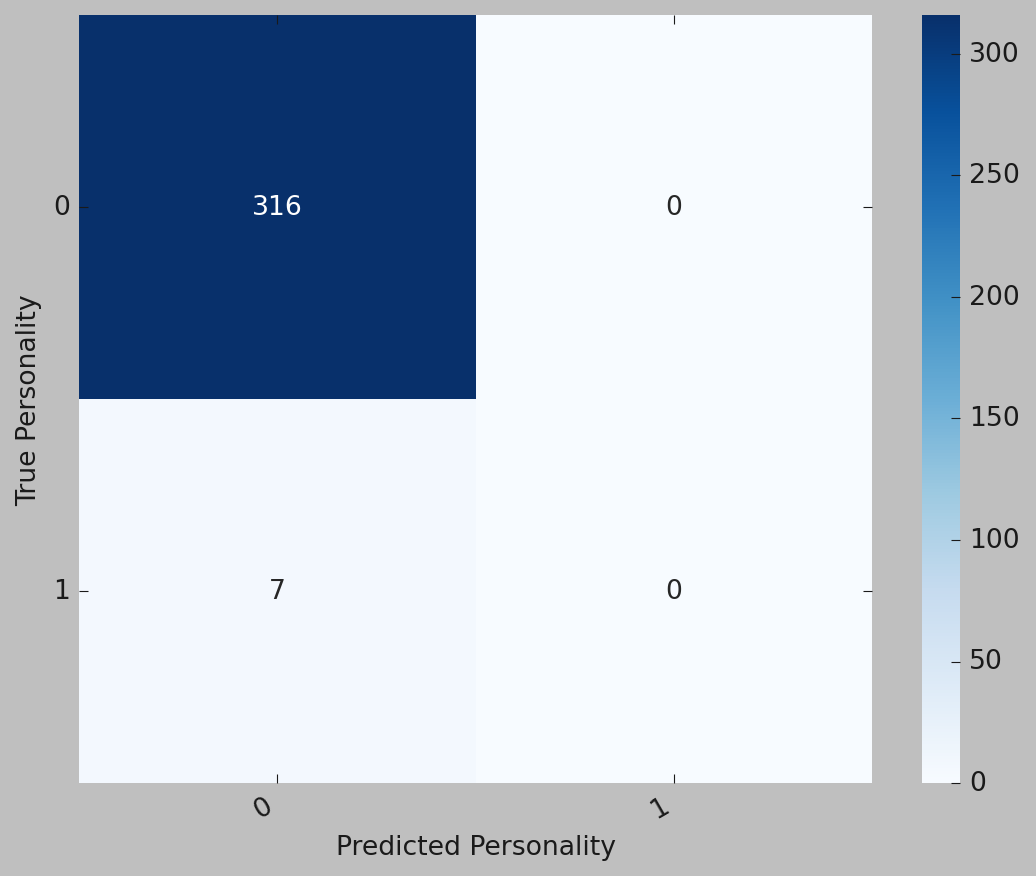

In [ ]:
i = 15
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.85      1.00      0.92       273
           1       0.00      0.00      0.00        50

    accuracy                           0.85       323
   macro avg       0.42      0.50      0.46       323
weighted avg       0.71      0.85      0.77       323



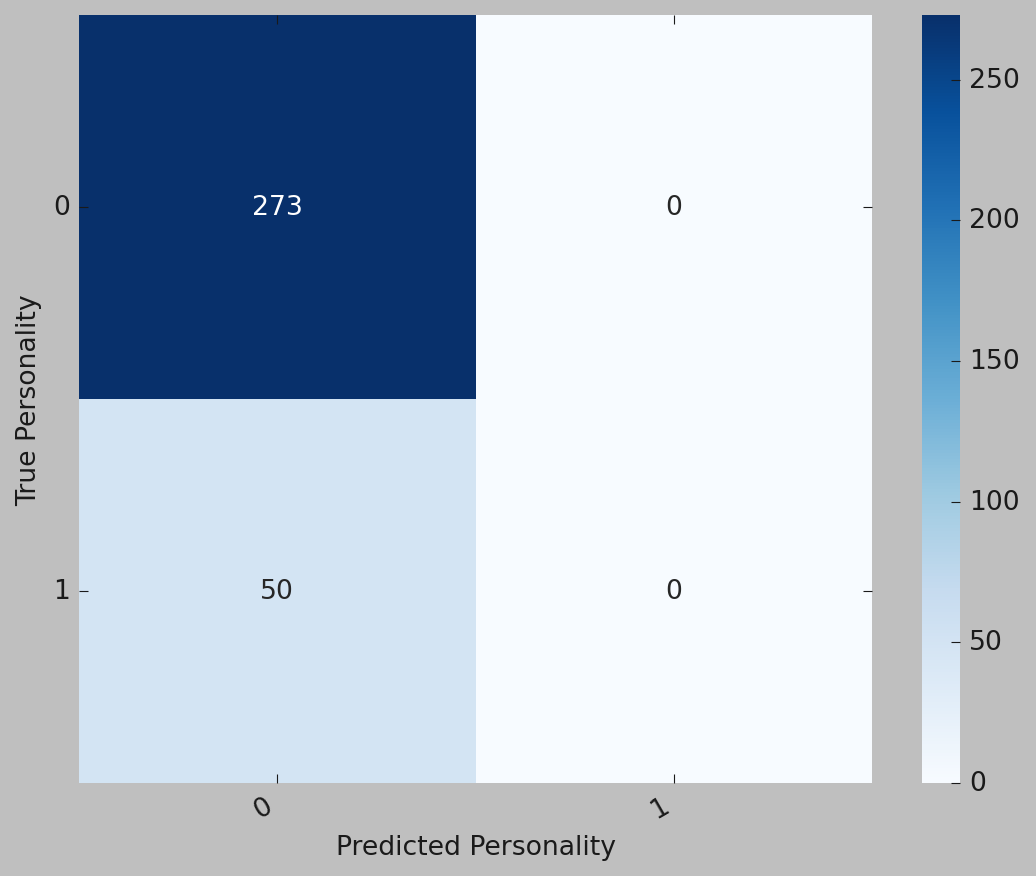

In [ ]:
i = 16
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323

    accuracy                           1.00       323
   macro avg       1.00      1.00      1.00       323
weighted avg       1.00      1.00      1.00       323



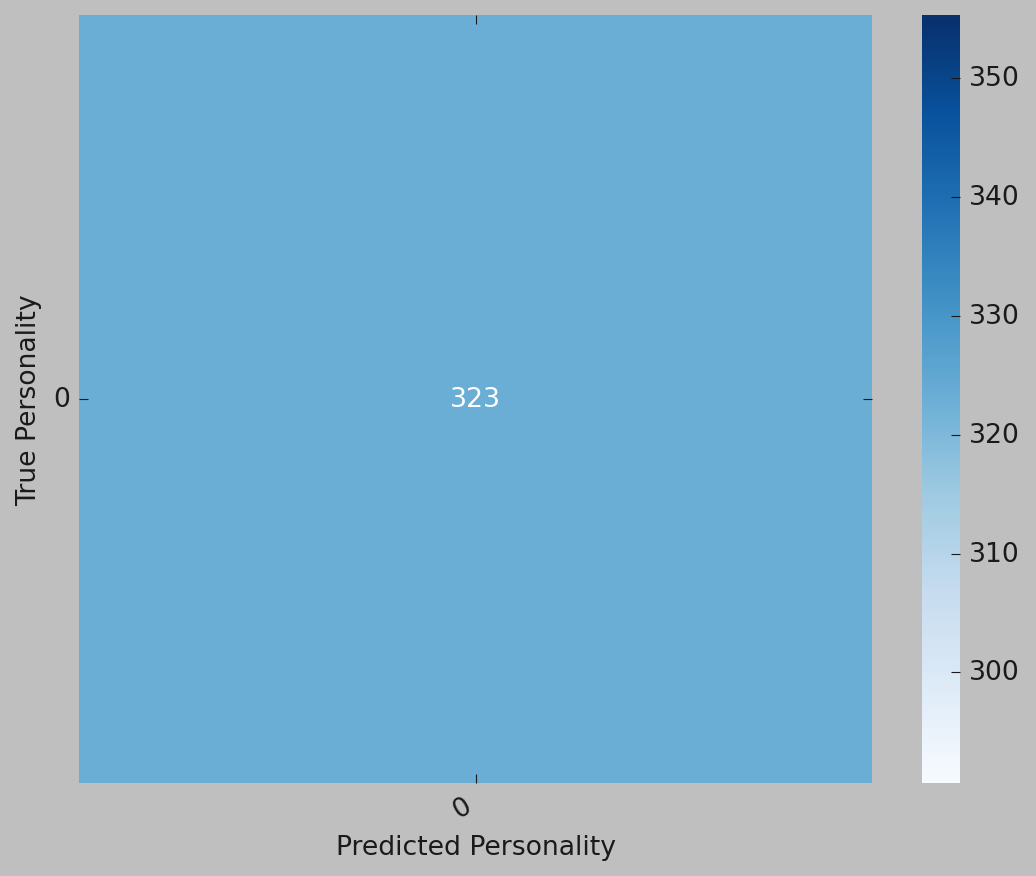

In [ ]:
i = 17
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323

    accuracy                           1.00       323
   macro avg       1.00      1.00      1.00       323
weighted avg       1.00      1.00      1.00       323



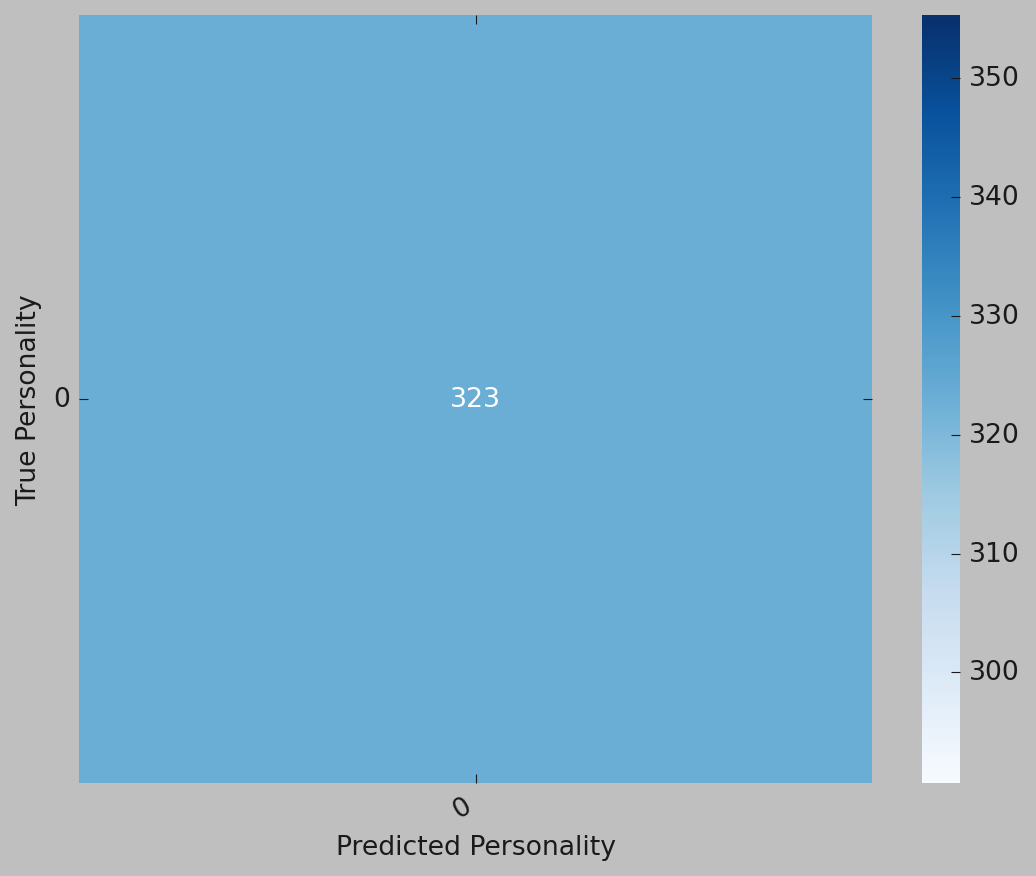

In [ ]:
i = 18
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

In [ ]:
def plot_roc_auc(y_test, y_score, classes):
    assert len(classes) > 1, "len classes must be > 1"
    plt.figure()
    if len(classes) > 2:  # multi-label
        # Compute ROC curve and ROC area for each class
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc))
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.plot(fpr, tpr, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
    else:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

[[[322   0]
  [  1   0]]

 [[298   0]
  [ 25   0]]

 [[316   0]
  [  7   0]]

 [[319   0]
  [  4   0]]

 [[304   0]
  [ 19   0]]

 [[300   0]
  [ 23   0]]

 [[313   0]
  [ 10   0]]

 [[322   0]
  [  1   0]]

 [[  0 100]
  [  0 223]]

 [[322   0]
  [  1   0]]

 [[  0 181]
  [  0 142]]

 [[317   0]
  [  6   0]]

 [[323   0]
  [  0   0]]

 [[323   0]
  [  0   0]]

 [[320   0]
  [  3   0]]

 [[316   0]
  [  7   0]]

 [[273   0]
  [ 50   0]]

 [[323   0]
  [  0   0]]

 [[323   0]
  [  0   0]]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        19
           5       0.00      0.00      0.00        23
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1
           8       

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedM

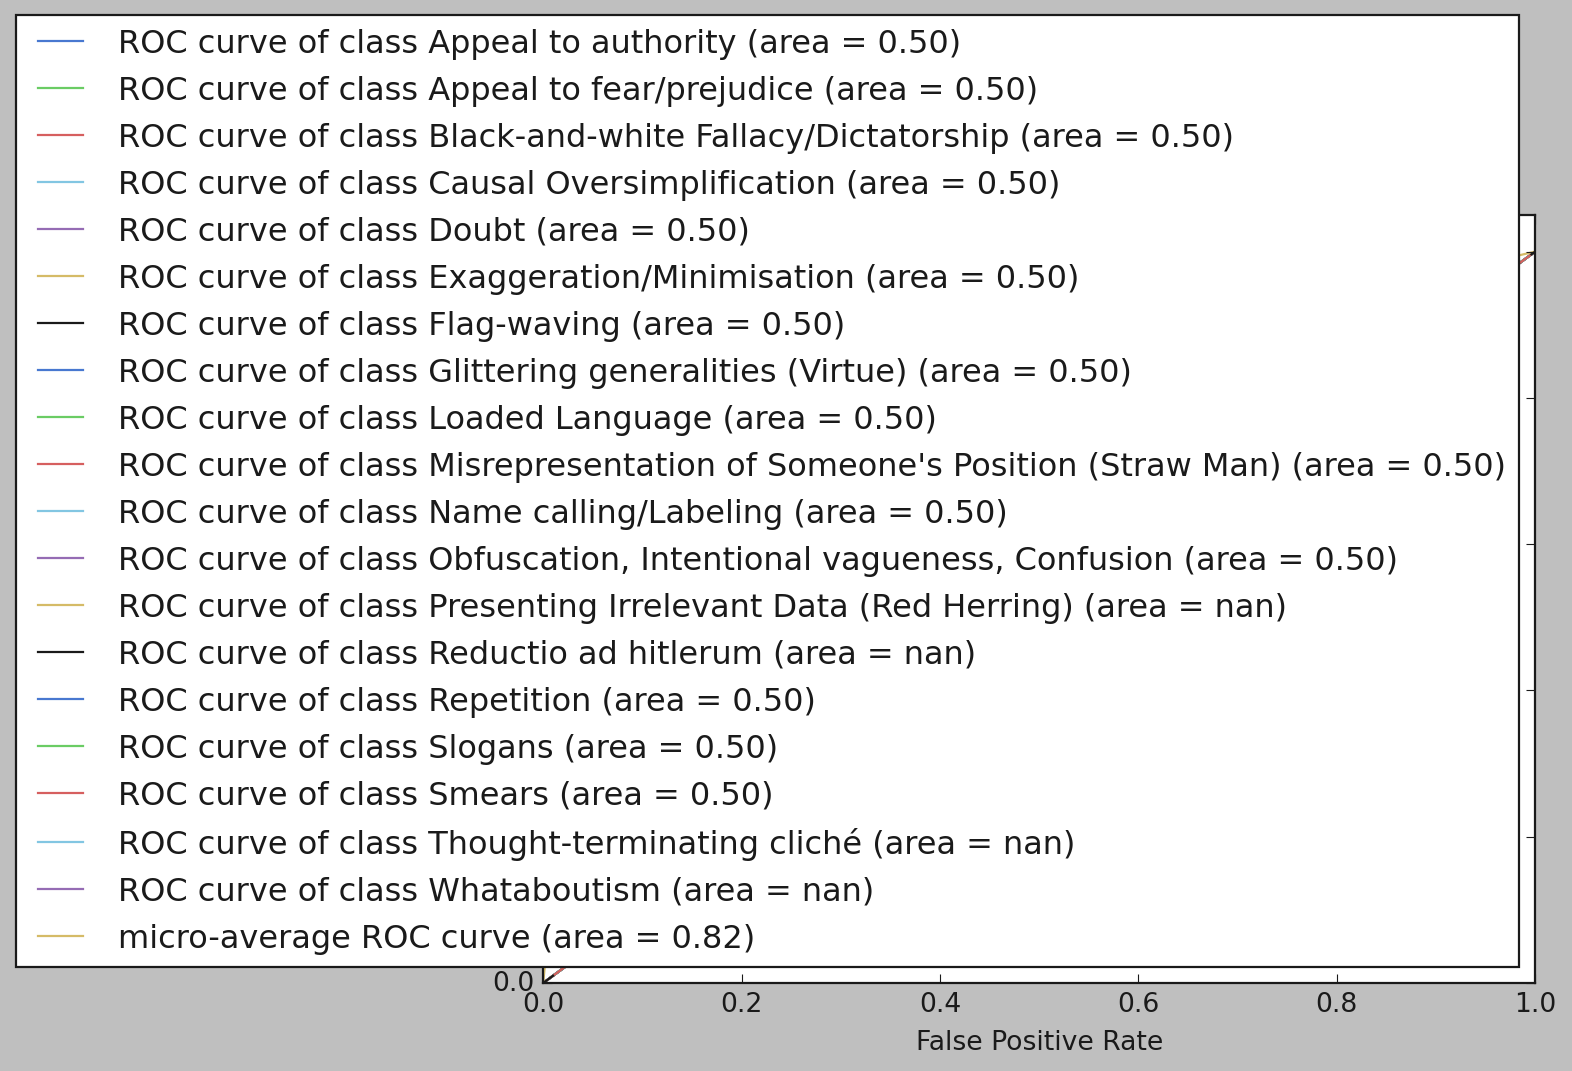

In [ ]:
import sklearn.metrics as skm

a = []
for k in labels:
  a.append(list(k))


p = []
for i in range(predictio.shape[1]):
  p.append(list(predictio[:,i]))

  
cm = skm.multilabel_confusion_matrix(a, p)
print(cm)
print( skm.classification_report(a,p))

a = np.array(a)
p = np.array(p)
from sklearn.metrics import auc, roc_curve

plot_roc_auc(a, p, propaganda_techniques_names)

In [ ]:
predictio.shape

(19, 323)

In [ ]:
output = []
for id,p in zip(testjsonobj,predictio.T):
    output.append({'id': id['id'], 'text': id['text'], 'labels': [propaganda_techniques_names[j] for j in [i for i, e in enumerate(p) if e == 1]]})


In [ ]:
with open("output.json", "w") as final:
   json.dump(output, final)

In [ ]:
!python3 scorer/task1.py  --log_to_file --gold_file_path='data/task1_test_gold_label_final.json' --pred_file_path='output.json' --classes_file_path="techniques_list_task1-2.txt"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
0.06798107166770762	0.6023102310231023
